# ADULT WEIGHT PREDICTION IN A TERTIARY HOSPITAL IN GHANA

## Project setup

In [9]:
# !pip install h2o -q -U
# !pip install --force-reinstall numpy==1.25.2

In [10]:
# Import packages
import numpy as np # Numeric computation
import pandas as pd # Data manipulation
import matplotlib as mp # Visualisation
import matplotlib.pyplot as plt # Visualisation
import seaborn as sns # Visualisation
import h2o # Automated ML
from h2o.automl import H2OAutoML #Automated ML
# Evaluate multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor # VIF
# Pre-processing and model selection
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
# System and warnings
import sys
import os
import warnings
# Save models
import joblib

In [11]:
# Print version of libraries
print(f"Python version: {sys.version}")
print("-------------------------------")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {mp.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"h2o version: {h2o.__version__}")

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
-------------------------------
Pandas version: 2.2.2
Matplotlib version: 3.10.0
Seaborn version: 0.13.2
h2o version: 3.46.0.6


In [12]:
# Initialise h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         39 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.6
H2O_cluster_version_age:    4 months and 16 days
H2O_cluster_name:           H2O_from_python_unknownUser_ul2byl
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.170 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.11 final
--------------------------  -----------------------------------------------------------------------------------------

# Prepare Data
## Import

In [13]:
try:
    df = pd.read_csv('muac.csv')
    display(df.head())
    print(df.shape)
    print(df.info())
except FileNotFoundError:
    print("Error: 'muac.csv' not found. Please ensure the file is in the current directory.")

sex      religion     education_level     employment  age  \
0  female  christianity   sss_shs_secondary        retired   67   
1  female  christianity  pre_primary___none  self_employed   53   
2  female  christianity      jss_jhs_middle        retired   68   
3  female  christianity  pre_primary___none  self_employed   70   
4  female  christianity              higher        retired   74   

   height_meters  height  weight    cc  muac   bmi     bmi_cat  
0          1.491   149.1    50.0  31.2  30.0  22.5      Normal  
1          1.582   158.2    55.0  31.5  31.0  22.0      Normal  
2          1.828   182.8    90.8  49.2  48.9  27.2  Overweight  
3          1.590   159.0    50.8  31.8  32.3  20.1      Normal  
4          1.592   159.2    50.2  32.0  30.0  19.8      Normal

(389, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              389 non-null    object 
 1   religion         389 non-null    object 
 2   education_level  389 non-null    object 
 3   employment       389 non-null    object 
 4   age              389 non-null    int64  
 5   height_meters    389 non-null    float64
 6   height           389 non-null    float64
 7   weight           389 non-null    float64
 8   cc               389 non-null    float64
 9   muac             389 non-null    float64
 10  bmi              389 non-null    float64
 11  bmi_cat          389 non-null    object 
dtypes: float64(6), int64(1), object(5)
memory usage: 36.6+ KB
None


In [14]:
# Remove height in metres
del df["height_meters"]

In [15]:
# Convert sex into a factor
df["sex"] = df["sex"].astype("category")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   sex              389 non-null    category
 1   religion         389 non-null    object  
 2   education_level  389 non-null    object  
 3   employment       389 non-null    object  
 4   age              389 non-null    int64   
 5   height           389 non-null    float64 
 6   weight           389 non-null    float64 
 7   cc               389 non-null    float64 
 8   muac             389 non-null    float64 
 9   bmi              389 non-null    float64 
 10  bmi_cat          389 non-null    object  
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 31.0+ KB


## Explore

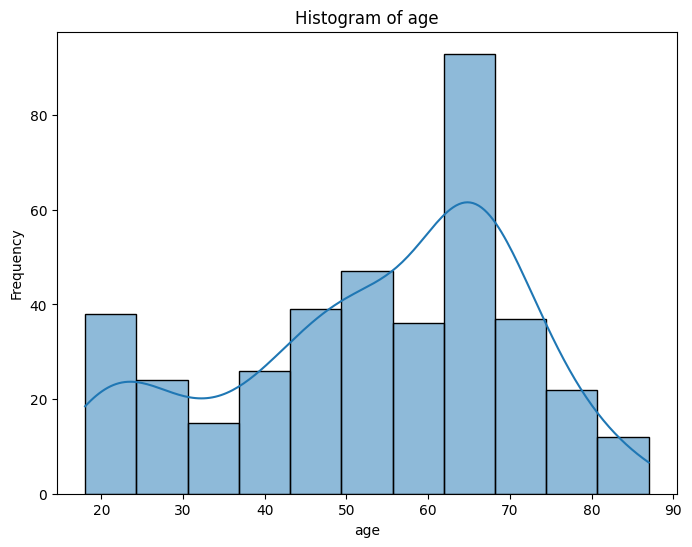

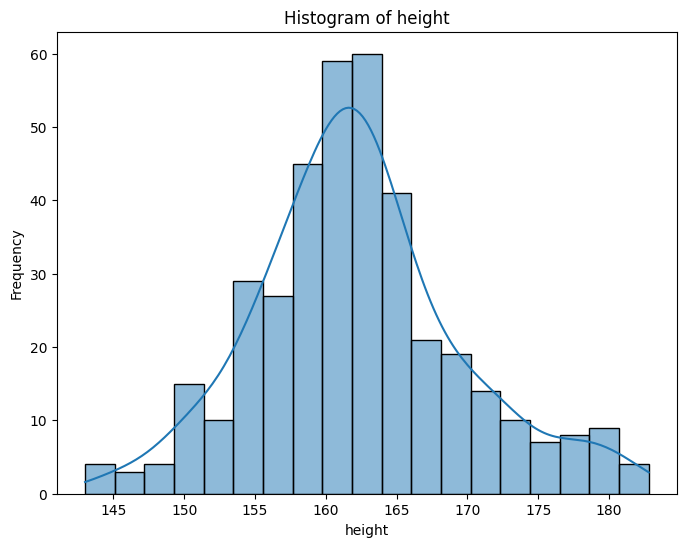

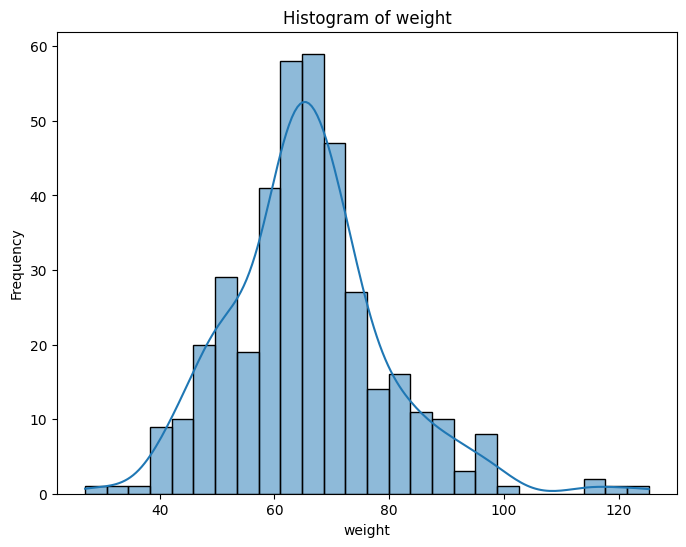

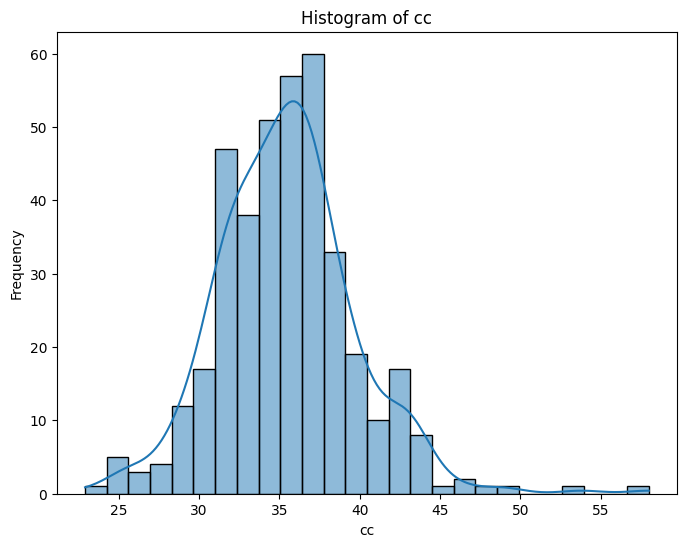

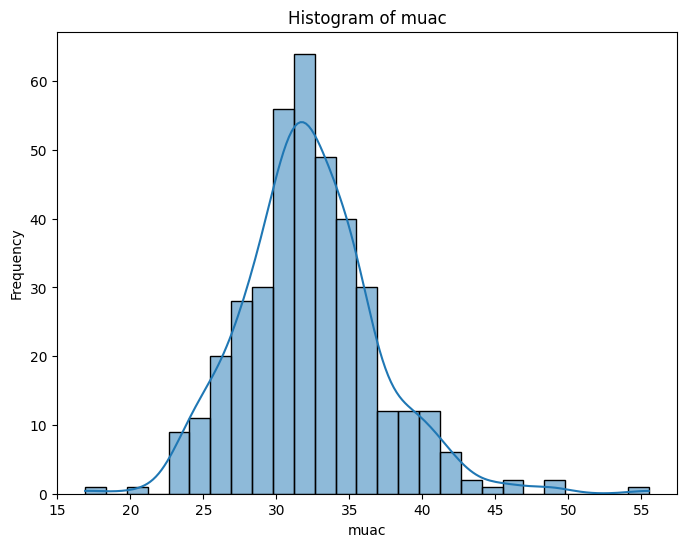

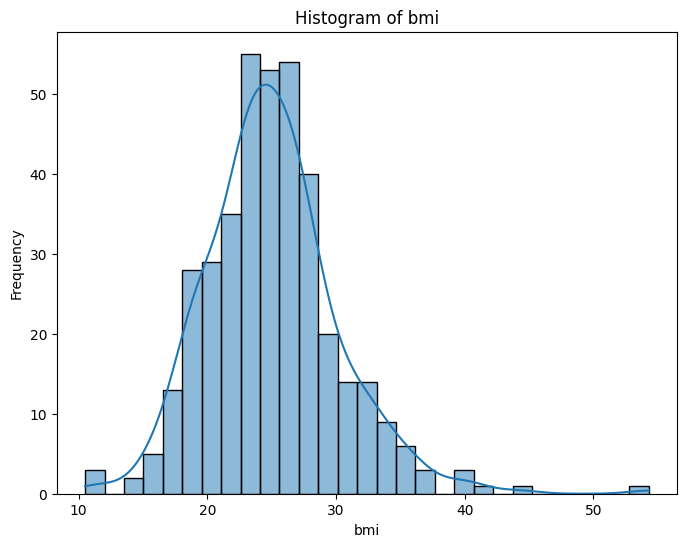

In [17]:
# Histogram of numeric variables
numeric_cols_original = df.select_dtypes(include=np.number).columns
for col in numeric_cols_original:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

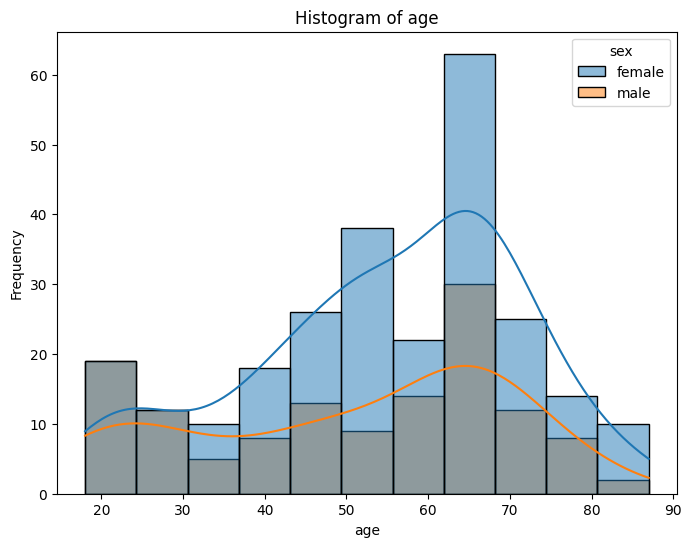

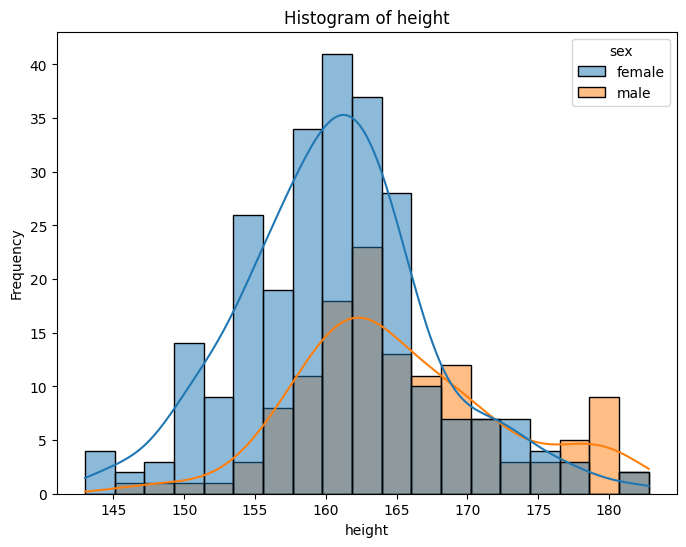

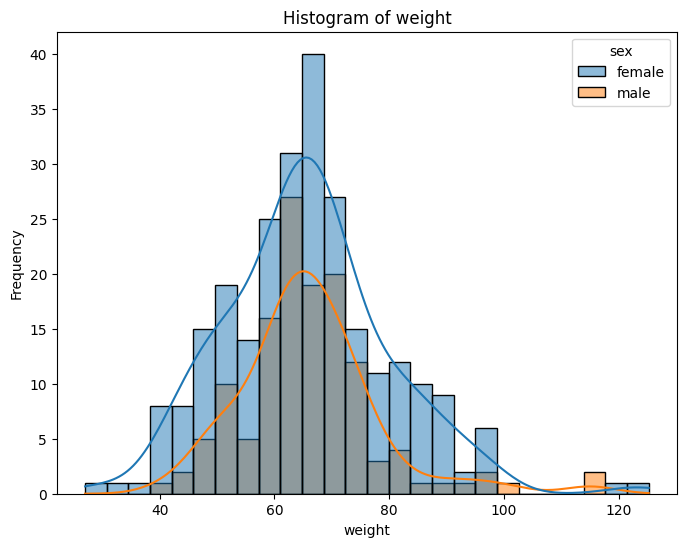

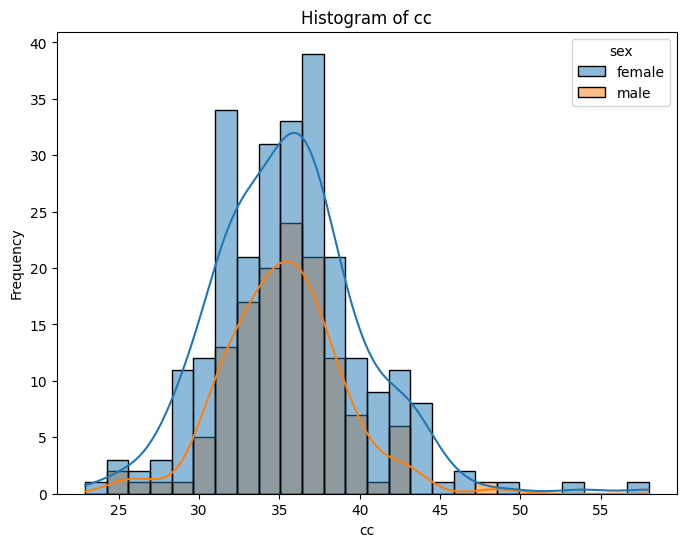

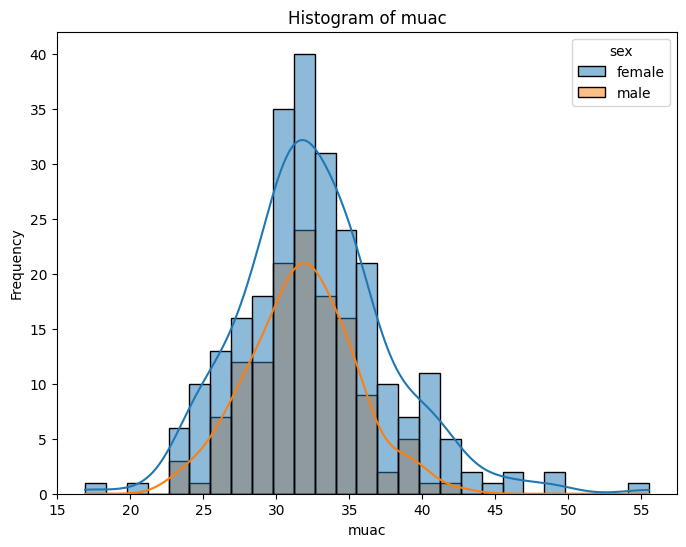

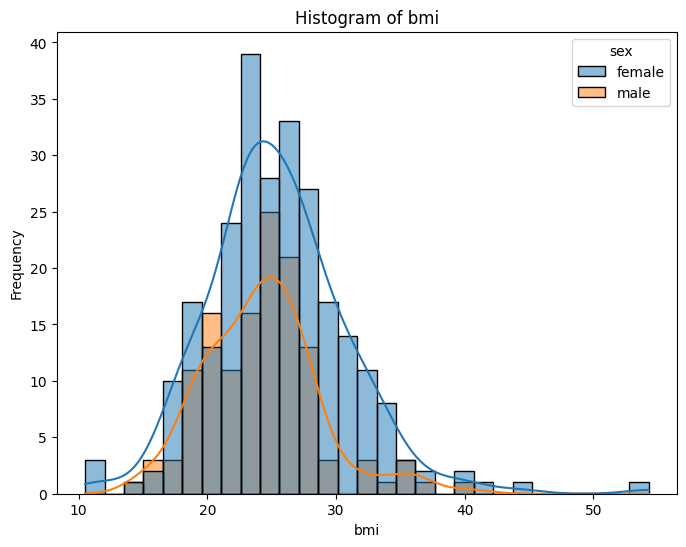

In [18]:
# Histogram of numeric variables by sex
numeric_cols_original = df.select_dtypes(include=np.number).columns
for col in numeric_cols_original:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df, x=col, kde=True, hue=df["sex"])
    plt.title(f'Histogram of {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Frequency')
    plt.show()

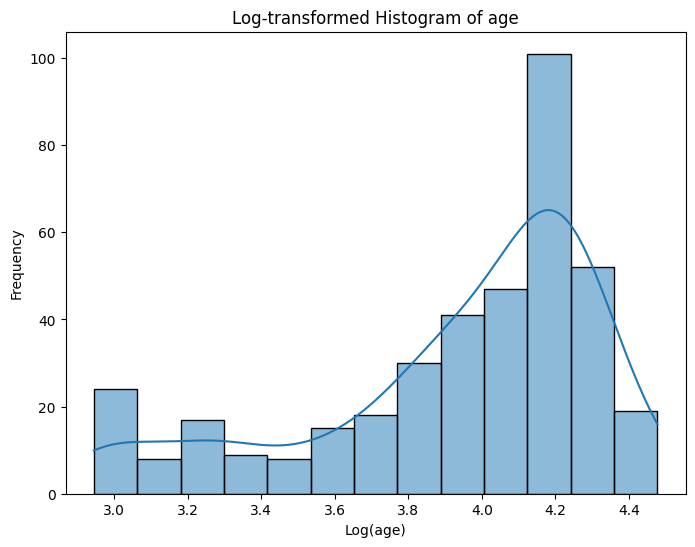

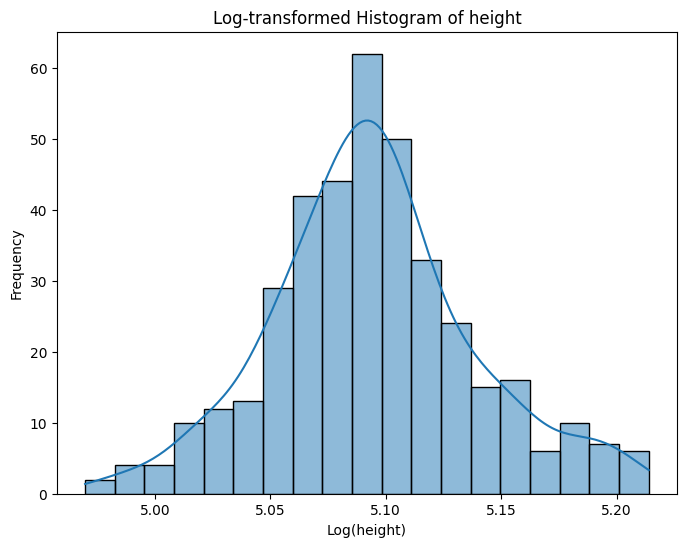

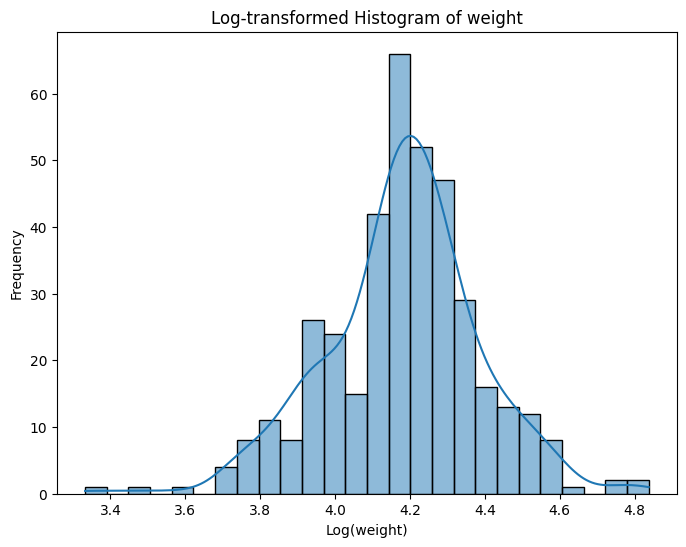

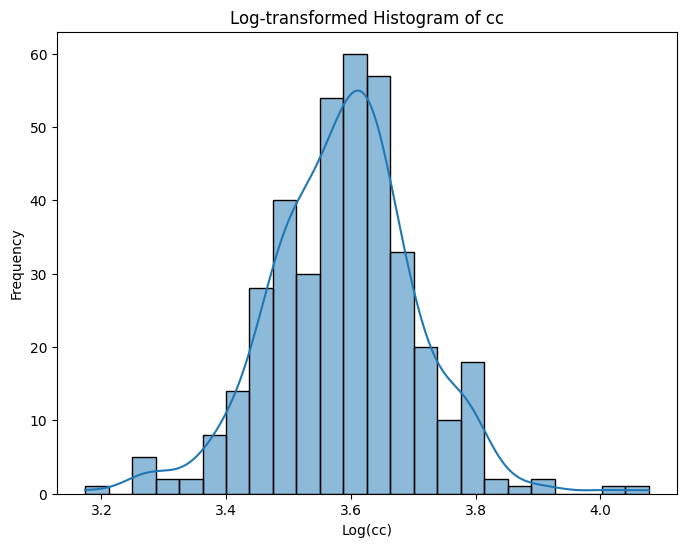

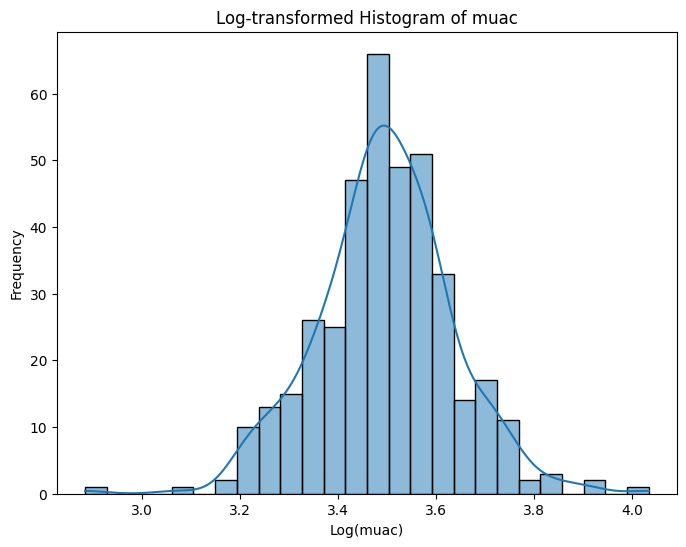

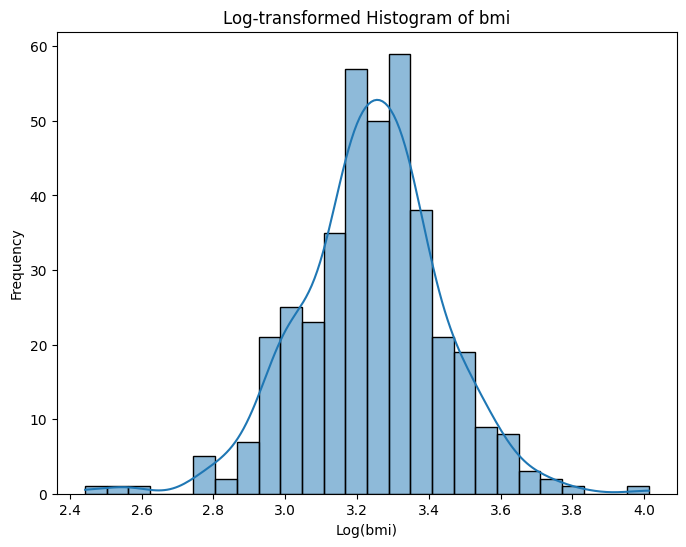

In [19]:
# Histogram of log transformed variables
numeric_cols_log = df.select_dtypes(include=np.number).columns
for col in numeric_cols_log:
    df[f'{col}_log'] = np.log1p(df[col])
    plt.figure(figsize=(8, 6))
    sns.histplot(data =df, x=f'{col}_log', kde=True)
    plt.title(f'Log-transformed Histogram of {col}')
    plt.xlabel(f'Log({col})')
    plt.ylabel('Frequency')
    plt.show()

age      height      weight          cc        muac         bmi  \
count  389.000000  389.000000  389.000000  389.000000  389.000000  389.000000   
mean    53.406170  162.254499   65.772879   35.459897   32.312339   25.017224   
std     17.637079    7.276654   13.655995    4.313200    4.666308    5.154153   
min     18.000000  143.000000   27.000000   22.900000   16.900000   10.500000   
25%     42.000000  157.900000   58.000000   32.500000   29.500000   21.900000   
50%     57.000000  161.800000   65.000000   35.400000   32.000000   24.600000   
75%     66.000000  165.700000   72.000000   37.600000   34.900000   27.600000   
max     87.000000  182.800000  125.200000   58.000000   55.500000   54.300000   

          age_log  height_log  weight_log      cc_log    muac_log     bmi_log  
count  389.000000  389.000000  389.000000  389.000000  389.000000  389.000000  
mean     3.928296    5.094327    4.180635    3.589365    3.496314    3.239621  
std      0.398082    0.044319    0.204828    0.117016    0.138848    0.196565  
min      2.944439    4.969813    3.332205    3.173878    2.884801    2.442347  
25%      3.761200    5.068275    4.077537    3.511545    3.417727    3.131137  
50%      4.060443    5.092522    4.189655    3.594569    3.496508    3.242592  
75%      4.204693    5.116196    4.290459    3.653252    3.580737    3.353407  
max      4.477337    5.213848    4.837868    4.077537    4.034241    4.012773


Distribution of religion:
religion
christianity    334
islamic          53
traditional       2
Name: count, dtype: int64

Distribution of education_level:
education_level
sss_shs_secondary     98
jss_jhs_middle        95
pre_primary___none    76
higher                75
primary               45
Name: count, dtype: int64

Distribution of employment:
employment
self_employed    196
retired          117
unemployed        59
employed          17
Name: count, dtype: int64

Distribution of bmi_cat:
bmi_cat
Normal         180
Overweight     125
Obese           56
Underweight     28
Name: count, dtype: int64


age    height    weight        cc      muac       bmi
age     1.000000 -0.144259  0.078816  0.011080  0.061995  0.132959
height -0.144259  1.000000  0.232526  0.153026  0.066738 -0.178965
weight  0.078816  0.232526  1.000000  0.776900  0.781598  0.910265
cc      0.011080  0.153026  0.776900  1.000000  0.767352  0.723182
muac    0.061995  0.066738  0.781598  0.767352  1.000000  0.774334
bmi     0.132959 -0.178965  0.910265  0.723182  0.774334  1.000000

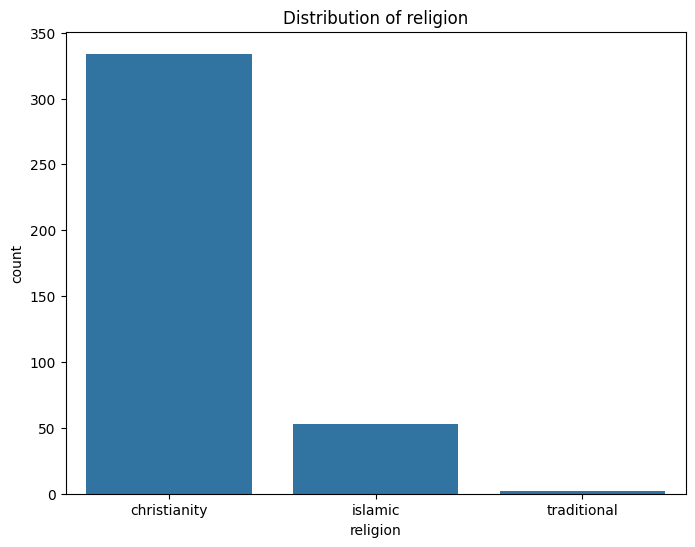

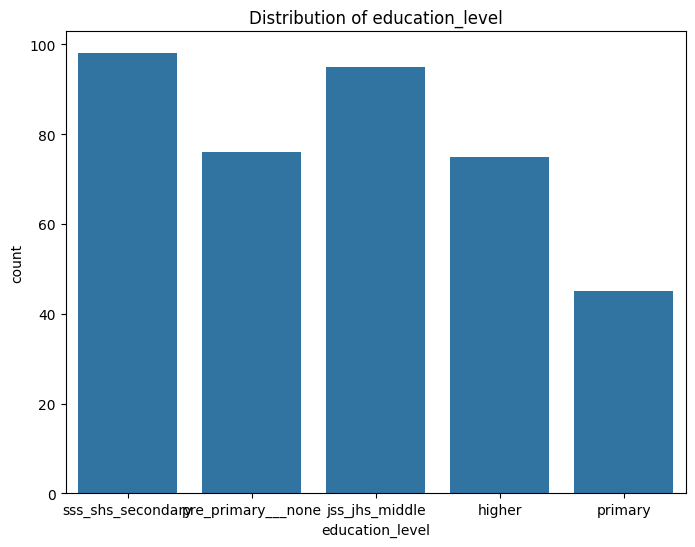

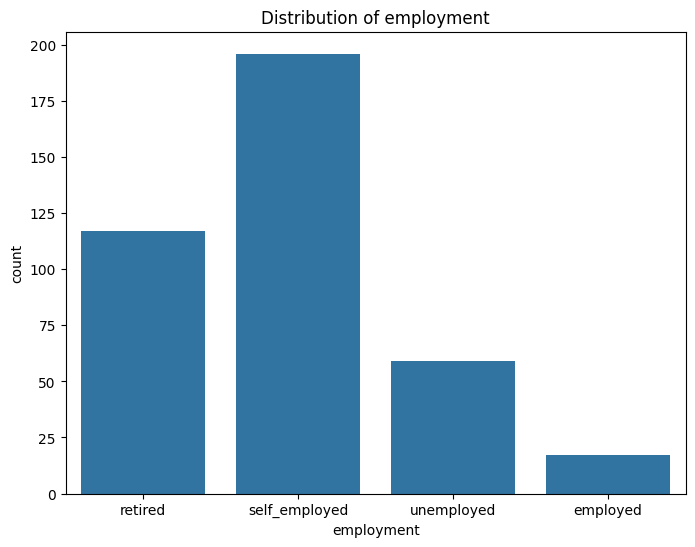

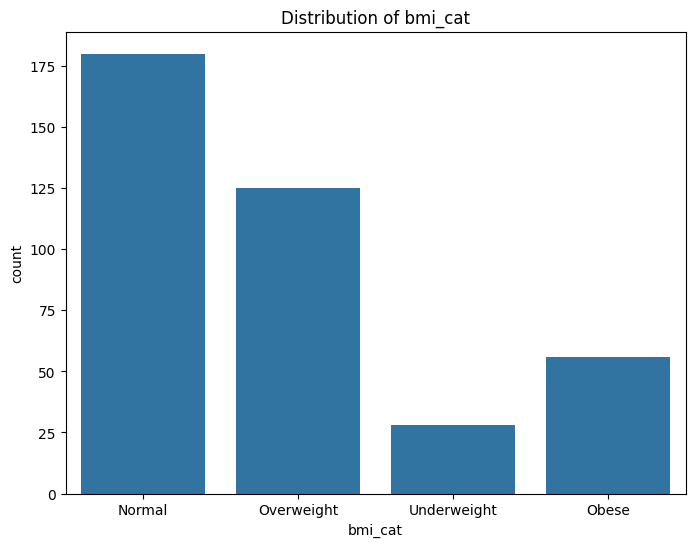

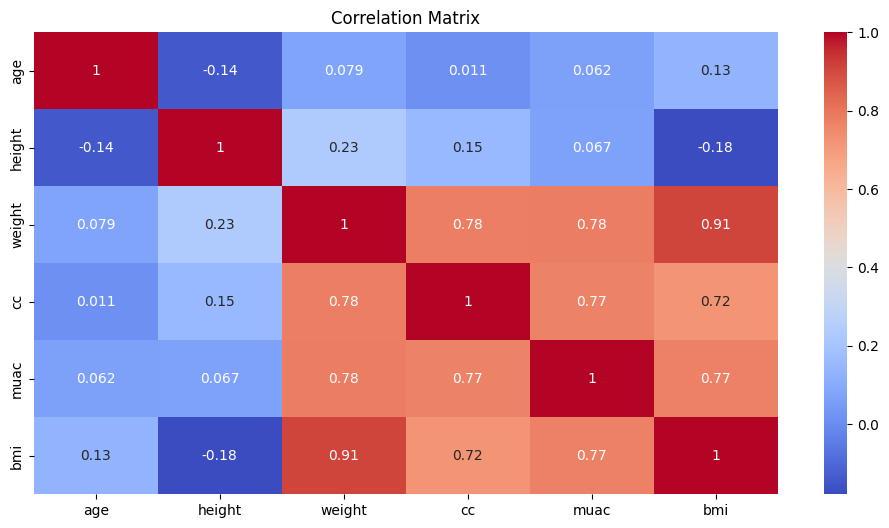


Missing Values:
sex                0
religion           0
education_level    0
employment         0
age                0
height             0
weight             0
cc                 0
muac               0
bmi                0
bmi_cat            0
age_log            0
height_log         0
weight_log         0
cc_log             0
muac_log           0
bmi_log            0
dtype: int64

Missing Value Percentage:
sex                0.0
religion           0.0
education_level    0.0
employment         0.0
age                0.0
height             0.0
weight             0.0
cc                 0.0
muac               0.0
bmi                0.0
bmi_cat            0.0
age_log            0.0
height_log         0.0
weight_log         0.0
cc_log             0.0
muac_log           0.0
bmi_log            0.0
dtype: float64


In [20]:
# Calculate descriptive statistics for numerical features
numerical_stats = df.describe()
display(numerical_stats)

# Analyze the distribution of categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())
    # Bar plot
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')

# Investigate the correlation between numerical features
correlation_matrix = df[numeric_cols_original].corr()
display(correlation_matrix)

# Plot correlation matrix
plt.figure(figsize=(12,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Identify missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print("\nMissing Values:")
print(missing_values)
print("\nMissing Value Percentage:")
print(missing_percentage)

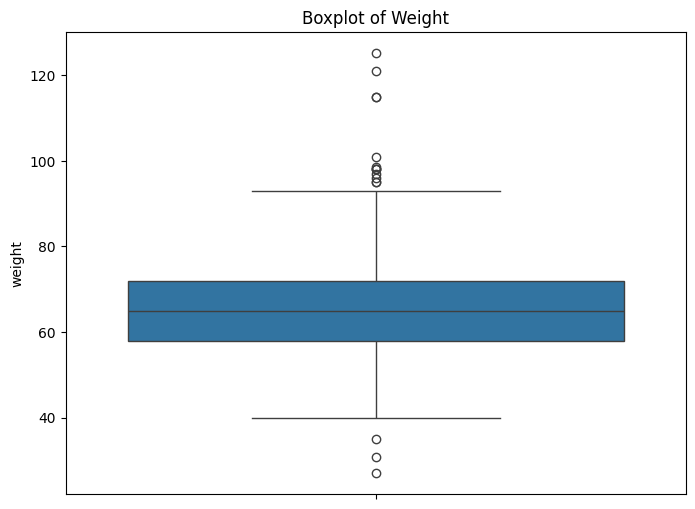

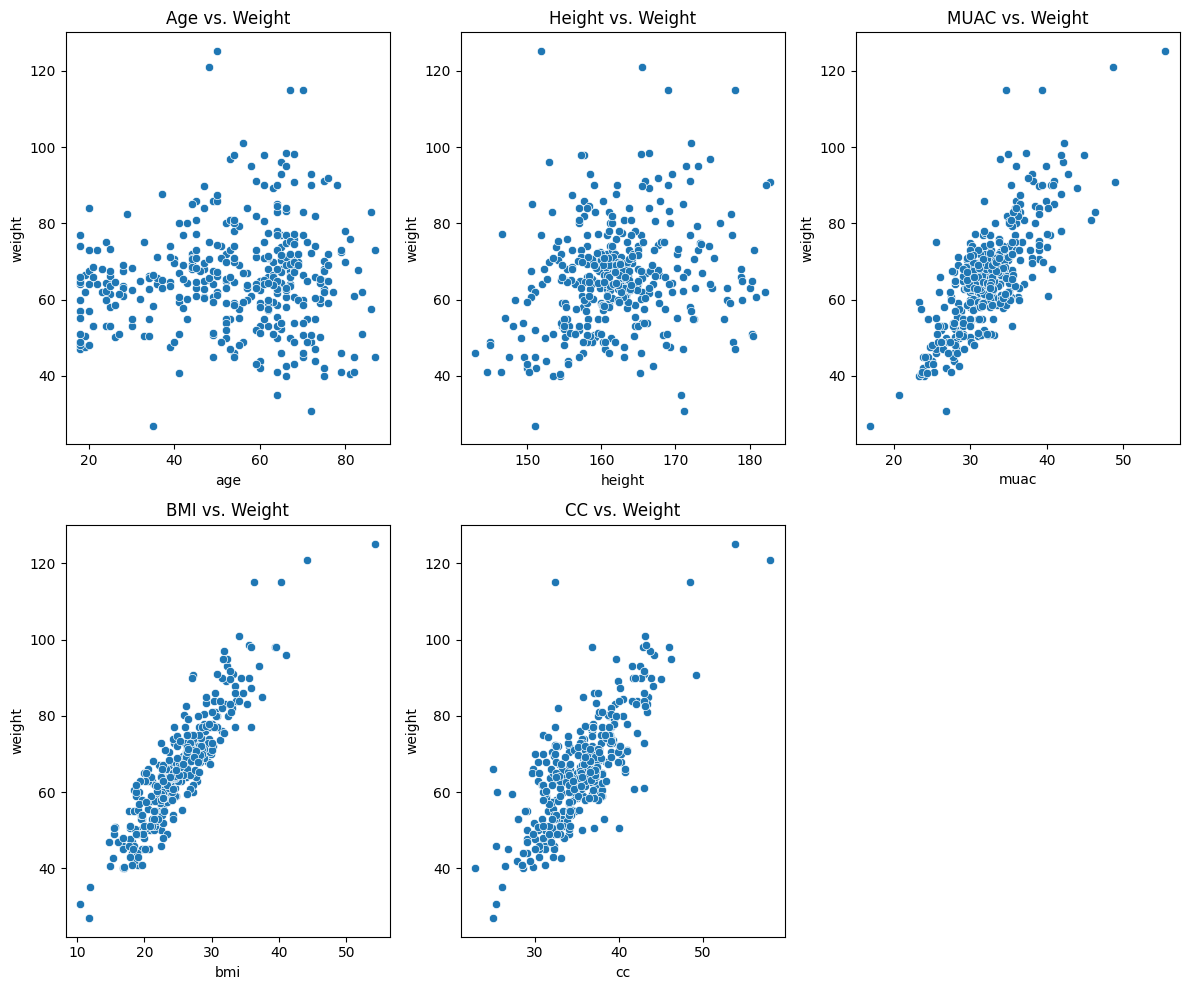

age       0.078816
height    0.232526
muac      0.781598
cc        0.776900
bmi       0.910265
weight    1.000000
Name: weight, dtype: float64


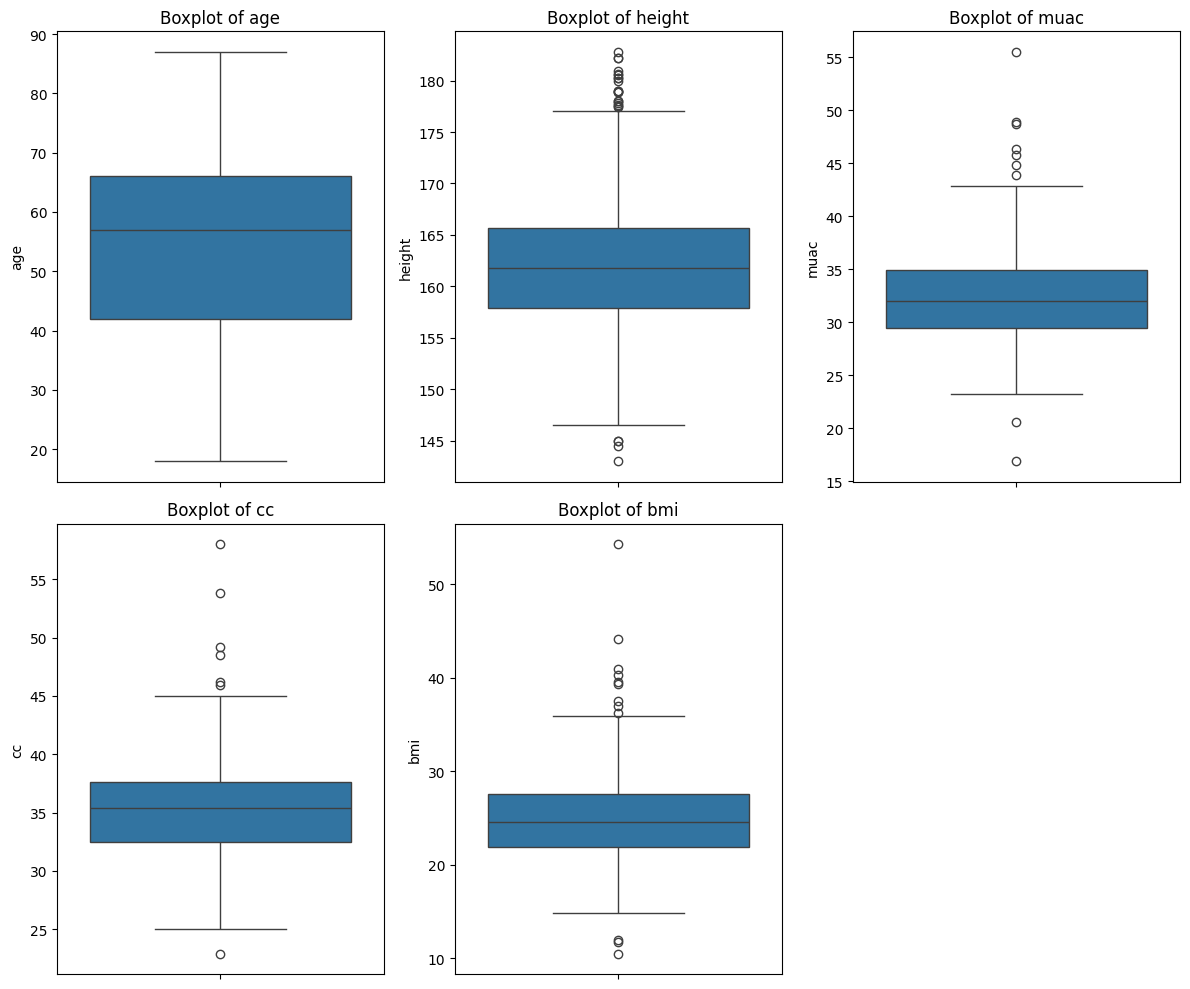

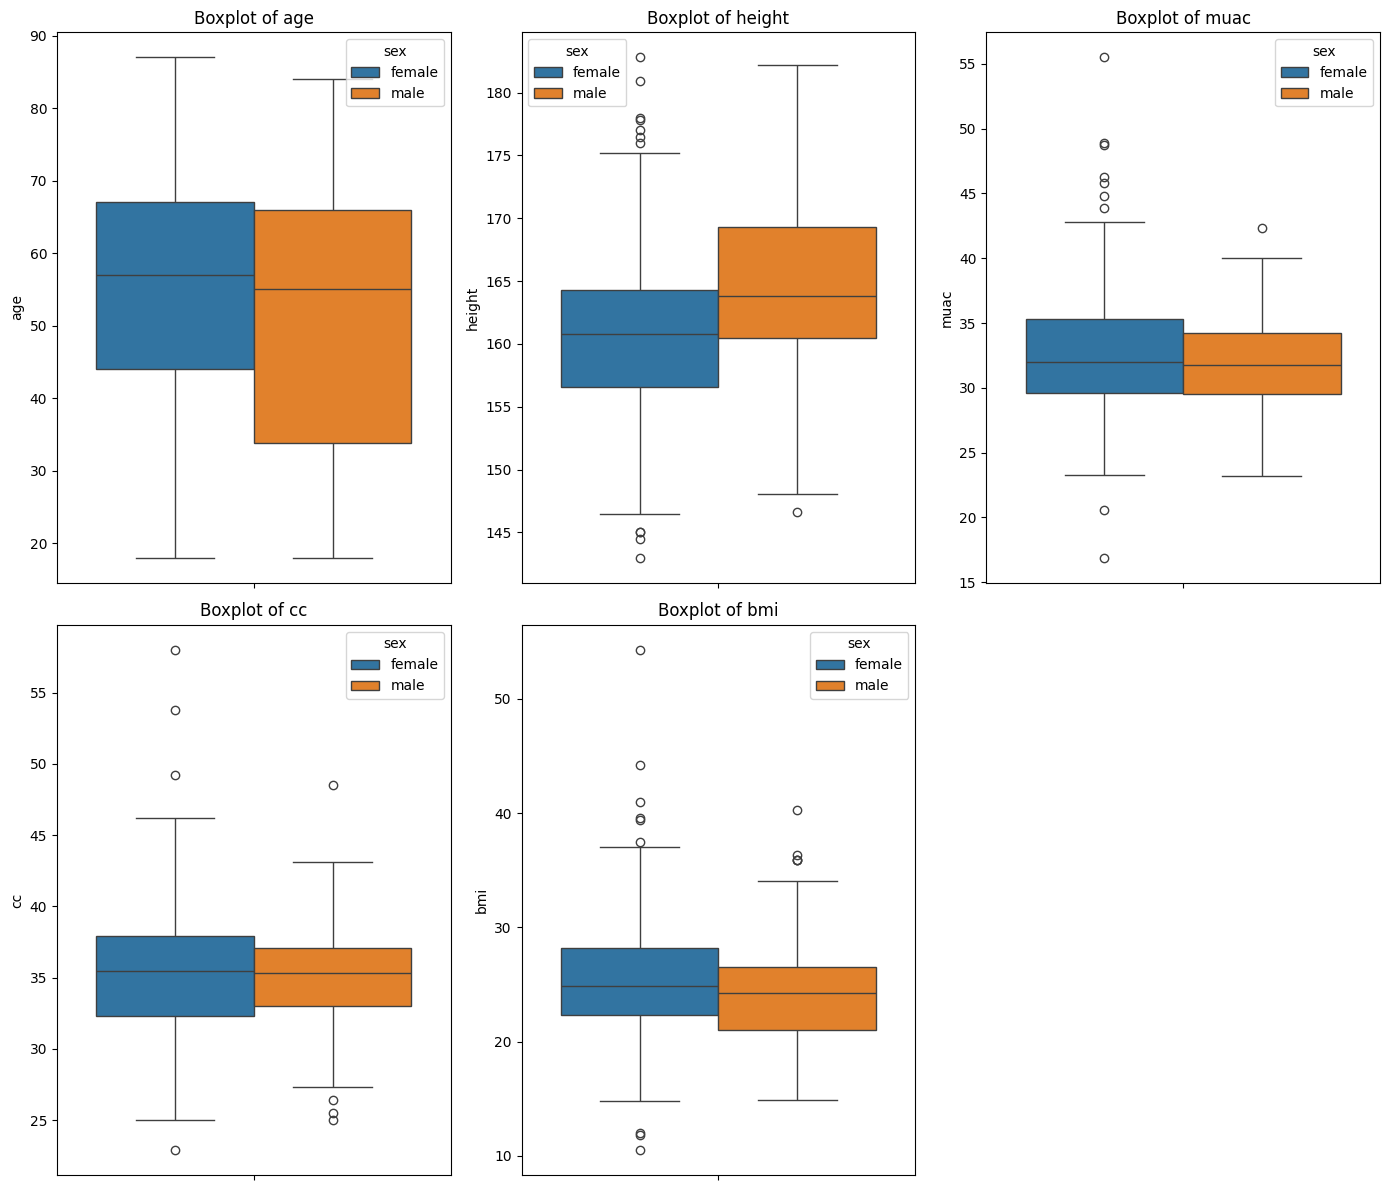

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)
# Box plot of target variable
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['weight'])
plt.title('Boxplot of Weight')
plt.show()


# Explore relationships between features and target
plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
sns.scatterplot(x='age', y='weight', data=df)
plt.title('Age vs. Weight')

plt.subplot(2, 3, 2)
sns.scatterplot(x='height', y='weight', data=df)
plt.title('Height vs. Weight')

plt.subplot(2, 3, 3)
sns.scatterplot(x='muac', y='weight', data=df)
plt.title('MUAC vs. Weight')

plt.subplot(2, 3, 4)
sns.scatterplot(x='bmi', y='weight', data=df)
plt.title('BMI vs. Weight')

plt.subplot(2, 3, 5)
sns.scatterplot(x='cc', y='weight', data=df)
plt.title('CC vs. Weight')

plt.tight_layout()
plt.show()

print(df[["age", "height", "muac", 'cc', "bmi", "weight"]].corr()['weight'])


# Identify potential outliers
plt.figure(figsize=(12, 10))
for i, col in enumerate(['age', 'height', 'muac', 'cc', 'bmi']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Box plot stratified by sex
plt.figure(figsize=(14, 12))
for i, col in enumerate(['age', 'height', 'muac', 'cc', 'bmi']):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col], hue=df["sex"])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

## Data cleaning

Detect and handle outliers in 'weight', 'height' 'muac', 'cc' and 'bmi' using the IQR method.  Winsorize the outliers at the 1st and 99th percentiles to limit their influence without removing valid data points.



In [22]:
# Outlier detection and treatment using IQR for 'weight' and 'bmi'
def handle_outliers_iqr(column):
    Q1 = column.quantile(0.01)
    Q3 = column.quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column.clip(lower=lower_bound, upper=upper_bound)

columns = ["weight", "height", "muac", "cc", "bmi"]
for col in columns:
  df[col] = handle_outliers_iqr(df[col])
display(df.describe())

age      height      weight          cc        muac         bmi  \
count  389.000000  389.000000  389.000000  389.000000  389.000000  389.000000   
mean    53.406170  162.254499   65.772879   35.459897   32.312339   25.017224   
std     17.637079    7.276654   13.655995    4.313200    4.666308    5.154153   
min     18.000000  143.000000   27.000000   22.900000   16.900000   10.500000   
25%     42.000000  157.900000   58.000000   32.500000   29.500000   21.900000   
50%     57.000000  161.800000   65.000000   35.400000   32.000000   24.600000   
75%     66.000000  165.700000   72.000000   37.600000   34.900000   27.600000   
max     87.000000  182.800000  125.200000   58.000000   55.500000   54.300000   

          age_log  height_log  weight_log      cc_log    muac_log     bmi_log  
count  389.000000  389.000000  389.000000  389.000000  389.000000  389.000000  
mean     3.928296    5.094327    4.180635    3.589365    3.496314    3.239621  
std      0.398082    0.044319    0.204828    0.117016    0.138848    0.196565  
min      2.944439    4.969813    3.332205    3.173878    2.884801    2.442347  
25%      3.761200    5.068275    4.077537    3.511545    3.417727    3.131137  
50%      4.060443    5.092522    4.189655    3.594569    3.496508    3.242592  
75%      4.204693    5.116196    4.290459    3.653252    3.580737    3.353407  
max      4.477337    5.213848    4.837868    4.077537    4.034241    4.012773

# Automated Machine Learning

In [23]:
# Select features to retain
features = ["age", "sex", "height", "cc", "muac", "bmi_cat", "weight"]
muac_features = ["age", "sex", "muac", "weight"]
cc_features = ["age", "sex", "cc", "weight"]
cc_muac_features = ["age", "sex", "cc", "muac", "weight"]
cc_muac_bmi = ["age", "sex", "cc", "muac", "bmi_cat", "weight"]


# Training frames
df_full = df[features]
df_muac = df[muac_features]
df_cc = df[cc_features]
df_cc_muac = df[cc_muac_features]
df_cc_muac_bmi = df[cc_muac_bmi]


# Set y target
y = "weight"

In [24]:
# Convert dataframe to H2O frame
df_full = h2o.H2OFrame(df_full)

# Convert sex into a factor
df_full["sex"] = df_full["sex"].asfactor()
df_full["bmi_cat"] = df_full["bmi_cat"].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
# Split into train & test
splits = df_full.split_frame(ratios = [0.8], seed = 1)
train = splits[0]
test = splits[1]

In [26]:
model_full = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_full")
model_full.train(y=y, training_frame=train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20250318_144744


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       2/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       0/1
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           0/1
# DRF base models (used / total)           0/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 9.383122363990484
RMSE: 3.0631882678004767
MAE: 2.293284122150482
RMSLE: 0.04689665052269142
Mean Residual Deviance: 9.383122363990484
R^2: 0.9492290317683467
Null degrees of freedom: 311
Residual degrees of freedom: 309
Null deviance: 57661.578644860085
Residual deviance: 2927.5341775650313
AIC: 1591.9583703828134

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 18.917426624566197
RMSE: 4.349416814305821
MAE: 3.188024503504421
RMSLE: 0.06672884302625995
Mean Residual Deviance: 18.917426624566197
R^2: 0.897640036128446
Null degrees of freedom: 311
Residual degrees of freedom: 309
Null deviance: 57959.42420728823
Residual deviance: 5902.2371068646535
AIC: 1810.723709471882

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     366.275    34.545      351.977       413.747       381.013       320.519       364.12
loglikelihood           0          0           0             0             0             0             0
mae                     3.18497    0.355739    3.07441       3.19897       3.72539       2.73586       3.19023
mean_residual_deviance  18.9316    6.19894     16.4626       17.7585       29.3415       12.812        18.2835
mse                     18.9316    6.19894     16.4626       17.7585       29.3415       12.812        18.2835
null_deviance           11591.9    2733.29     10390.4       12797.5       11885.1       15107.6       7778.78
r2                      0.890412   0.0426137   0.901745      0.900683      0.845277      0.950735      0.853619
residual_deviance       1180.45    376.644     1004.22       1260.85       1760.49       743.096       1133.58
rmse                    4.30872    0.676925    4.05742       4.21408       5.41678       3.57939       4.27592
rmsle                   0.0661308  0.00912531  0.0755355     0.066392      0.0720565     0.0517053     0.0649644

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse      mse      mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  -------  -------  -------  ---------  ------------------------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_1_20250318_144744_model_96             4.4476   19.7811  3.36196  0.0625895                   19.7811                 100                   0.064163  GBM
XGBoost_grid_1_AutoML_1_20250318_144744_model_26         4.47871  20.0589  3.34256  0.0651426                   20.0589                 467                   0.010156  XGBoost
GBM_grid_1_AutoML_1_20250318_144744_model_172            4.49987  20.2489  3.34938  0.0626382                   20.2489                 104                   0.032807  GBM
XGBoost_grid_1_AutoML_1_20250318_144744_model_16         4.51704  20.4036  3.26785  0.0636507                   20.4036                 280                   0.009648  XGBoost
GBM_grid_1_AutoML_1_20250318_144744_model_94             4.51755  20.4082  3.39877  0.0614135                   20.4082                  65                   0.023866  GBM
GBM_grid_1_AutoML_1_20250318_144744_model_170            4.53745  20.5884  3.36156  0.0640919                   20.5884                 101                   0.021125  GBM
DeepLearning_grid_2_AutoML_1_20250318_144744_model_1     4.57047  20.8892  3.40233  0.0621338                   20.8892                7426                   0.054228  DeepLearning
XGBoost_grid_1_AutoML_1_20250318_144744_model_7          4.57298  20.9122  3.18854  0.0626706                   20.9122                 510                   0.015599  XGBoost
GBM_grid_1_AutoML_1_20250318_144744_model_32             4.5786   20.9635  3.28681  0.062925                    20.9635                 101                   0.027919  GBM
GBM_grid_1_AutoML_1_20250318_144744_model_42             4.57994  20.9759  3.4984   0.0648849                   20.9759                  75                   0.024135  GBM
StackedEnsemble_AllModels_4_AutoML_1_20250318_144744     4.58087  20.9844  3.37944  0.0624786                   20.9844                1108                   1.73708   StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20250318_144744     4.58087  20.9844  3.37944  0.0624786                   20.9844                1122                   0.89065   StackedEnsemble
GBM_grid_1_AutoML_1_20250318_144744_model_119            4.61326  21.2821  3.35899  0.0654012                   21.2821                 118                   0.025446  GBM
XGBoost_grid_1_AutoML_1_20250318_144744_model_18         4.61671  21.314   3.49197  0.0626823                   21.314                  232                   0.010041  XGBoost
GBM_grid_1_AutoML_1_20250318_144744_model_160            4.63756  21.507   3.45199  0.0641803                   21.507                  112                   0.02409   GBM
StackedEnsemble_BestOfFamily_6_AutoML_1_20250318_144744  4.65435  21.6629  3.38392  0.0677086                   21.6629                 536                   0.122525  StackedEnsemble
XGBoost_grid_1_AutoML_1_20250318_144744_model_29         4.65782  21.6953  3.48417  0.0651263                   21.6953                 340                   0.009185  XGBoost
StackedEnsemble_BestOfFamily_1_AutoML_1_20250318_144744  4.66585  21.7702  3.64424  0.0686183                   21.7702                 239                   0.08394   StackedEnsemble
XGBoost_grid_1_AutoML_1_20250318_144744_model_17         4.69153  22.0105  3.51531  0.0720461                   22.0105                 238                   0.014699  XGBoost
XGBoost_1_AutoML_1_20250318_144744                       4.71473  22.2287  3.64982  0.0665518                   22.2287                 459                   0.010626  XGBoost
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

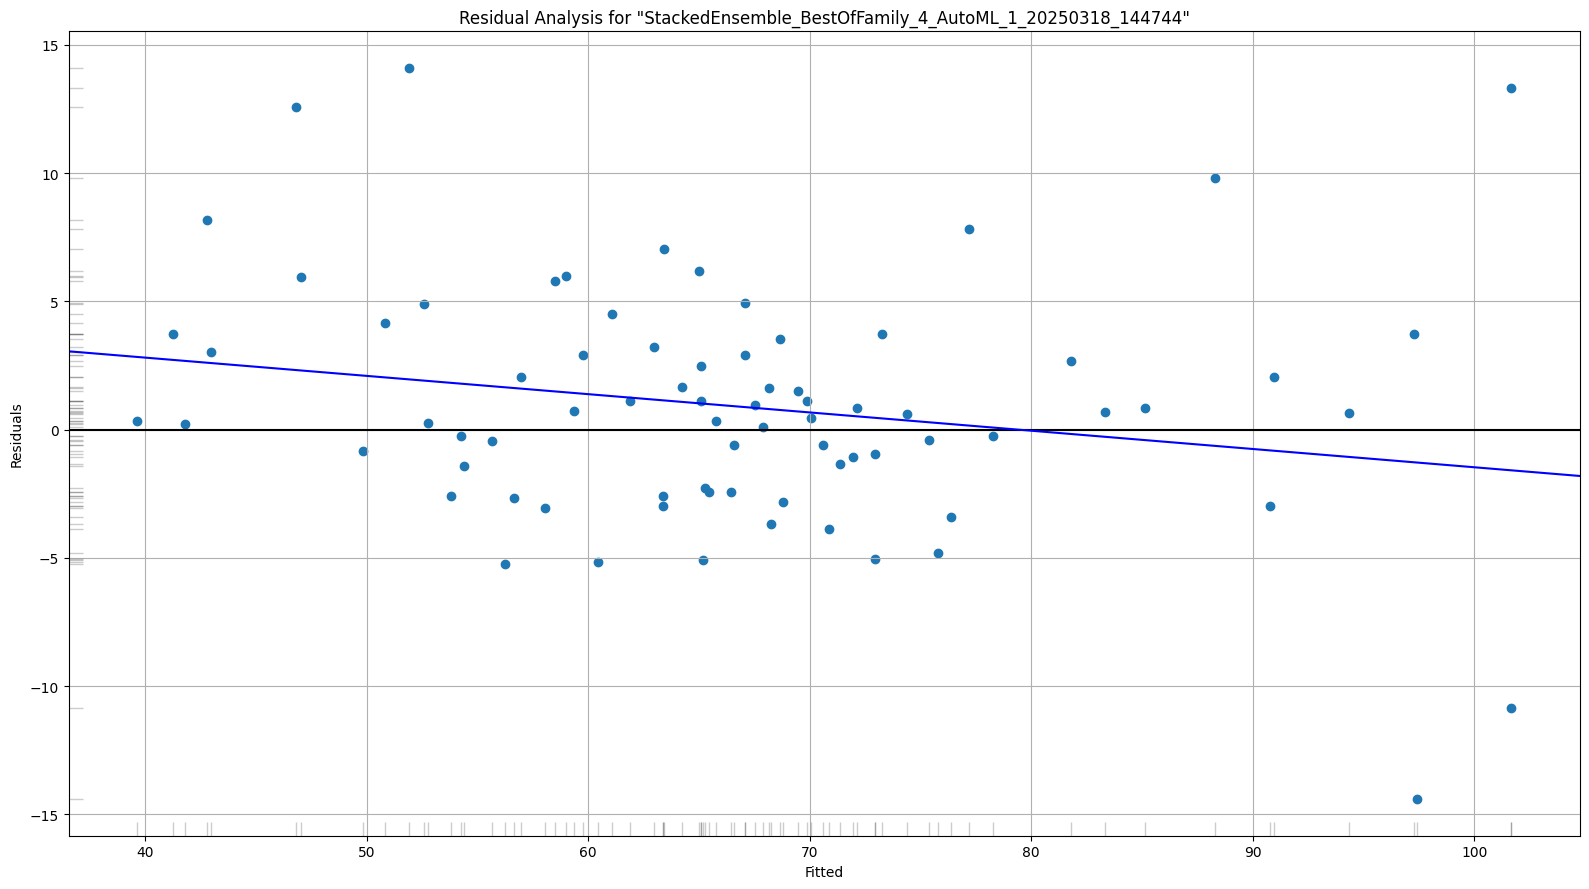

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

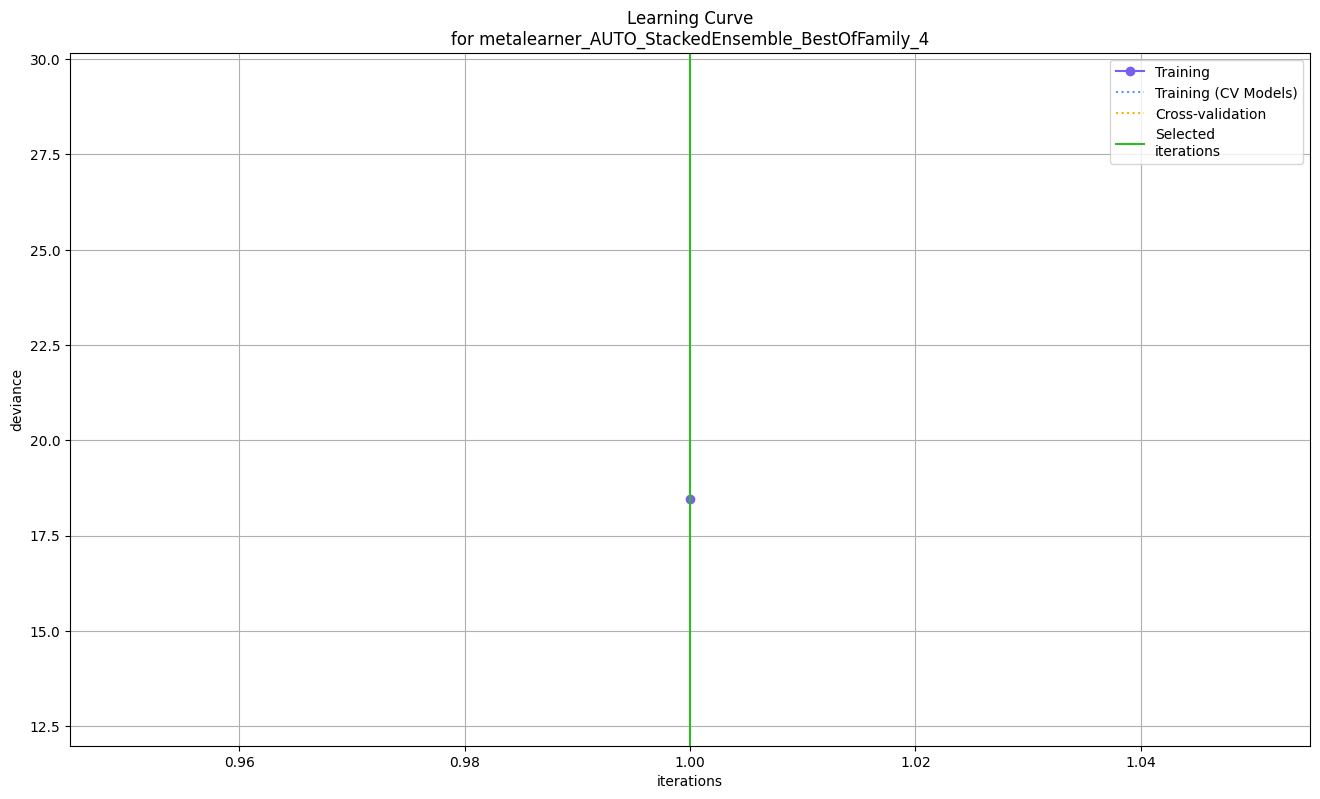

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

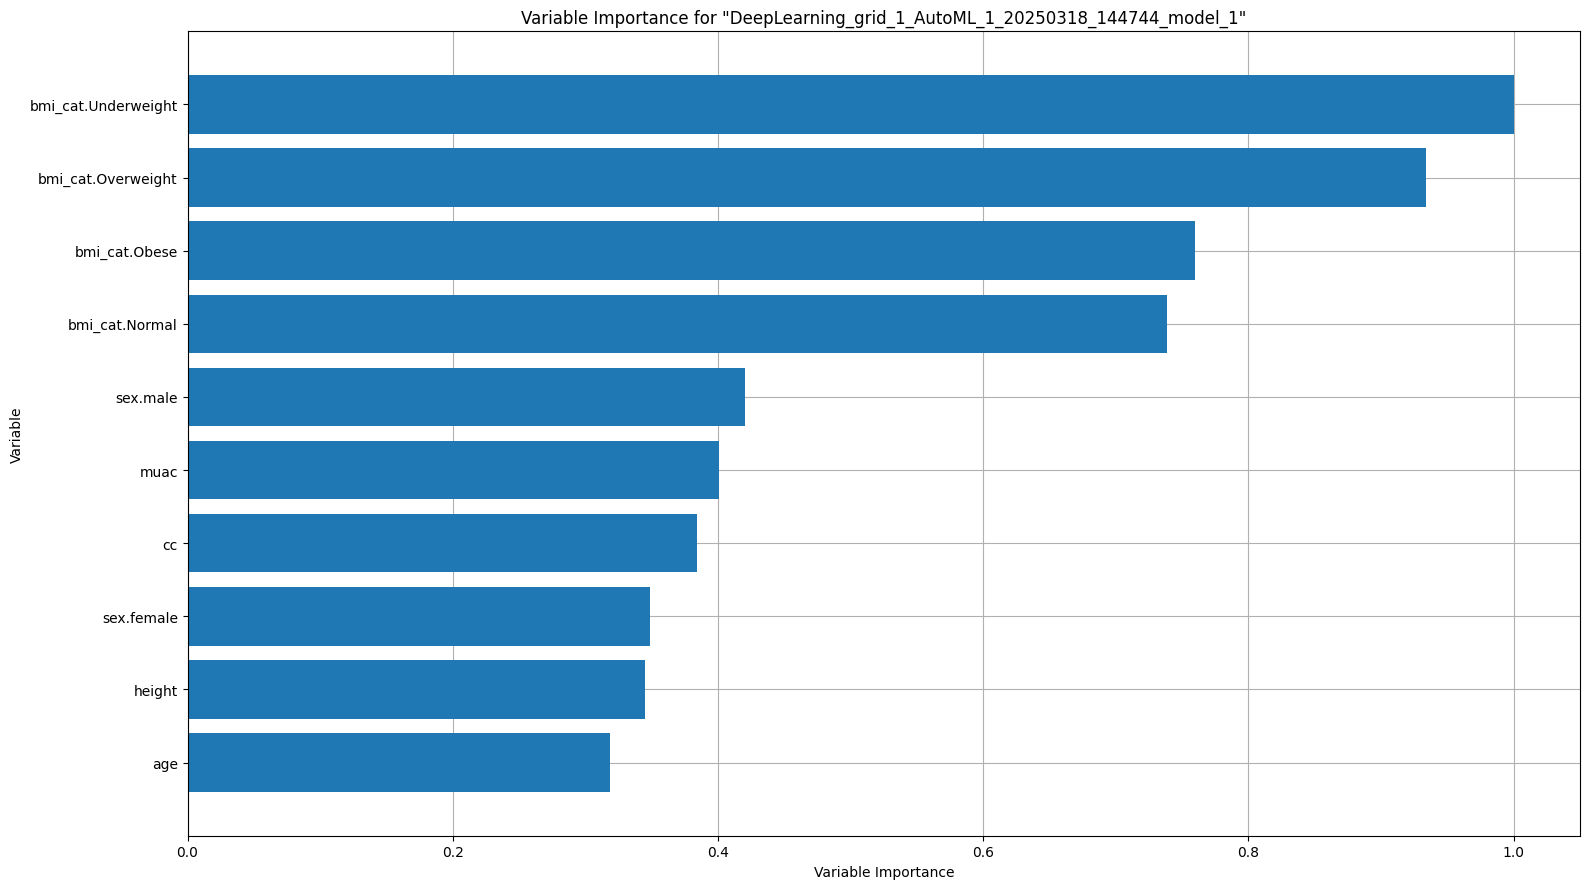

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

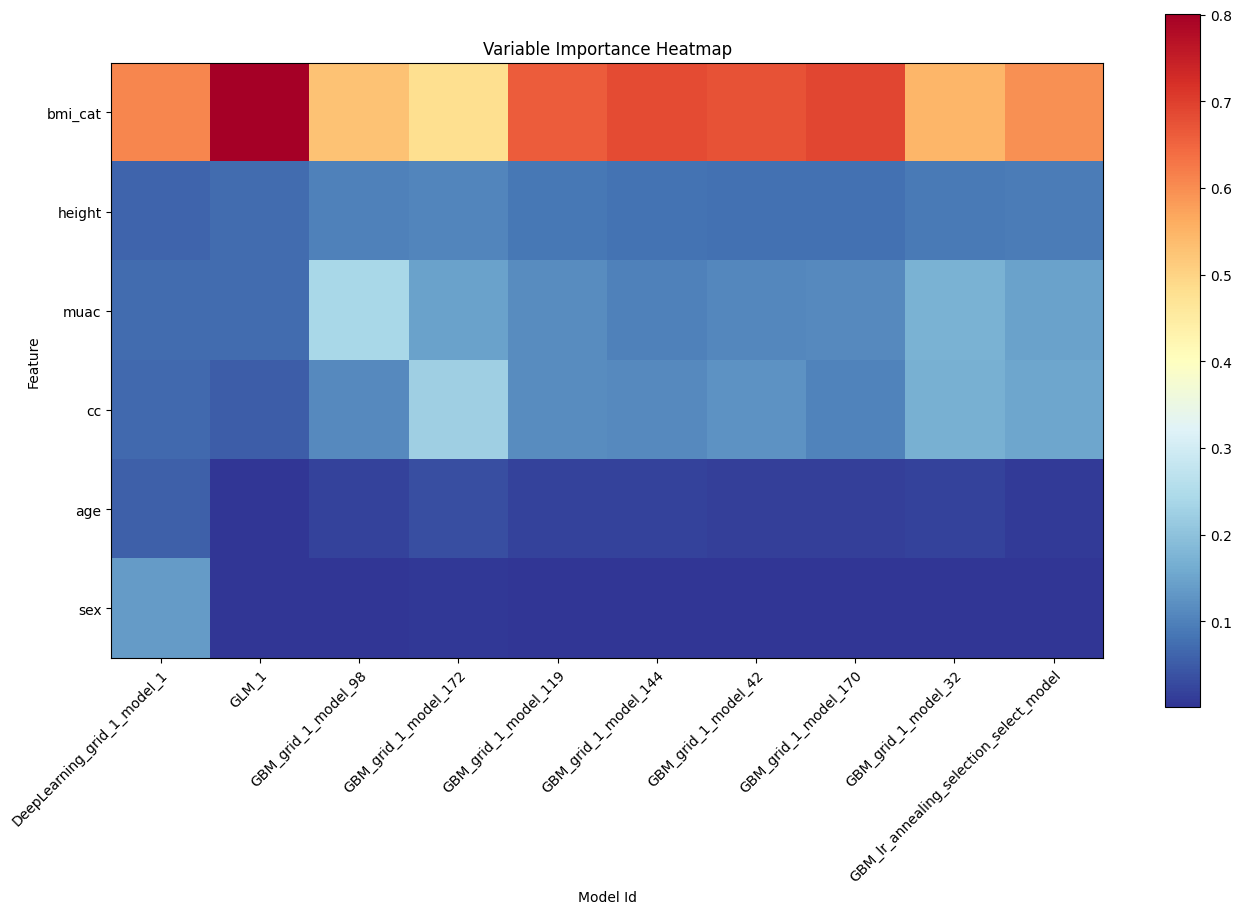

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

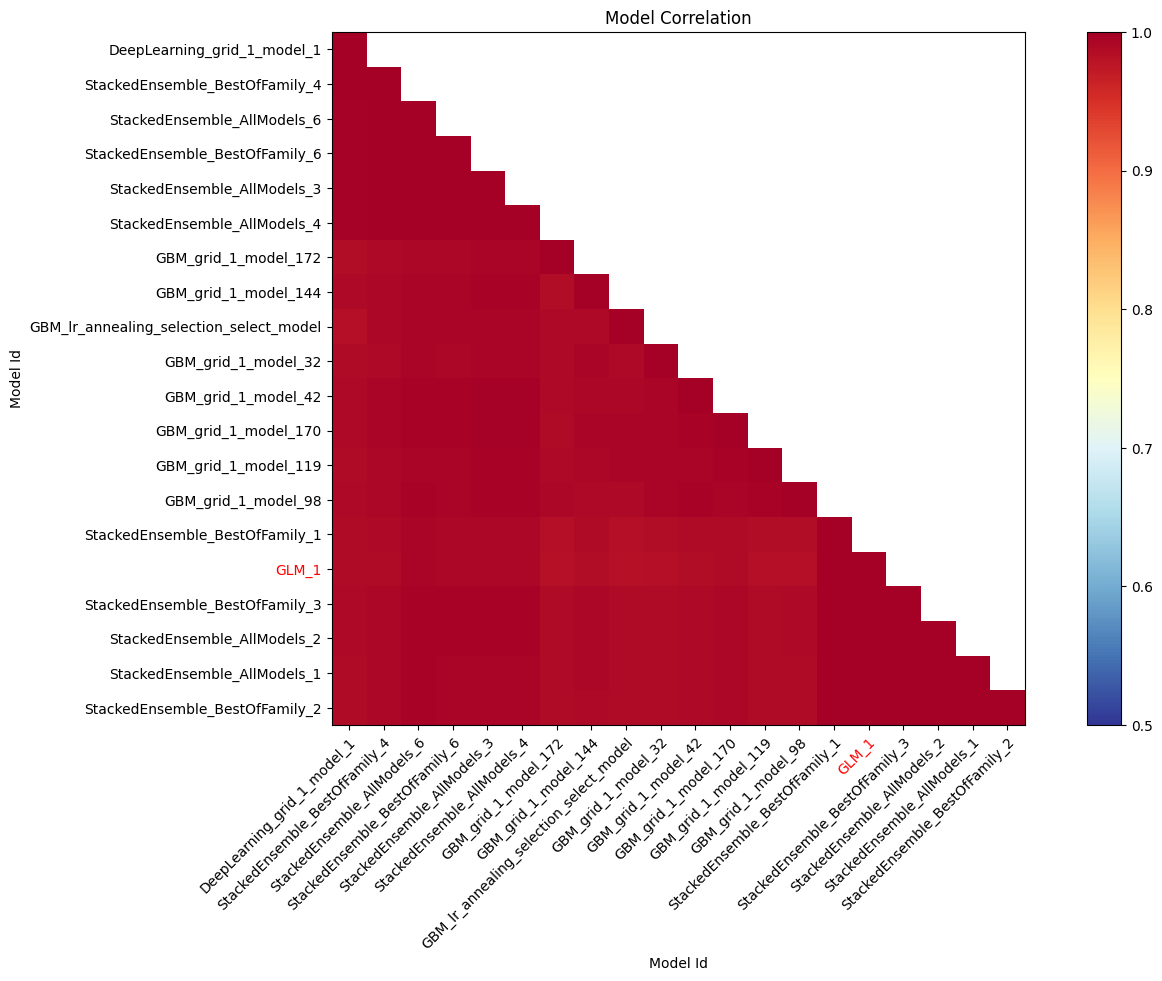

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

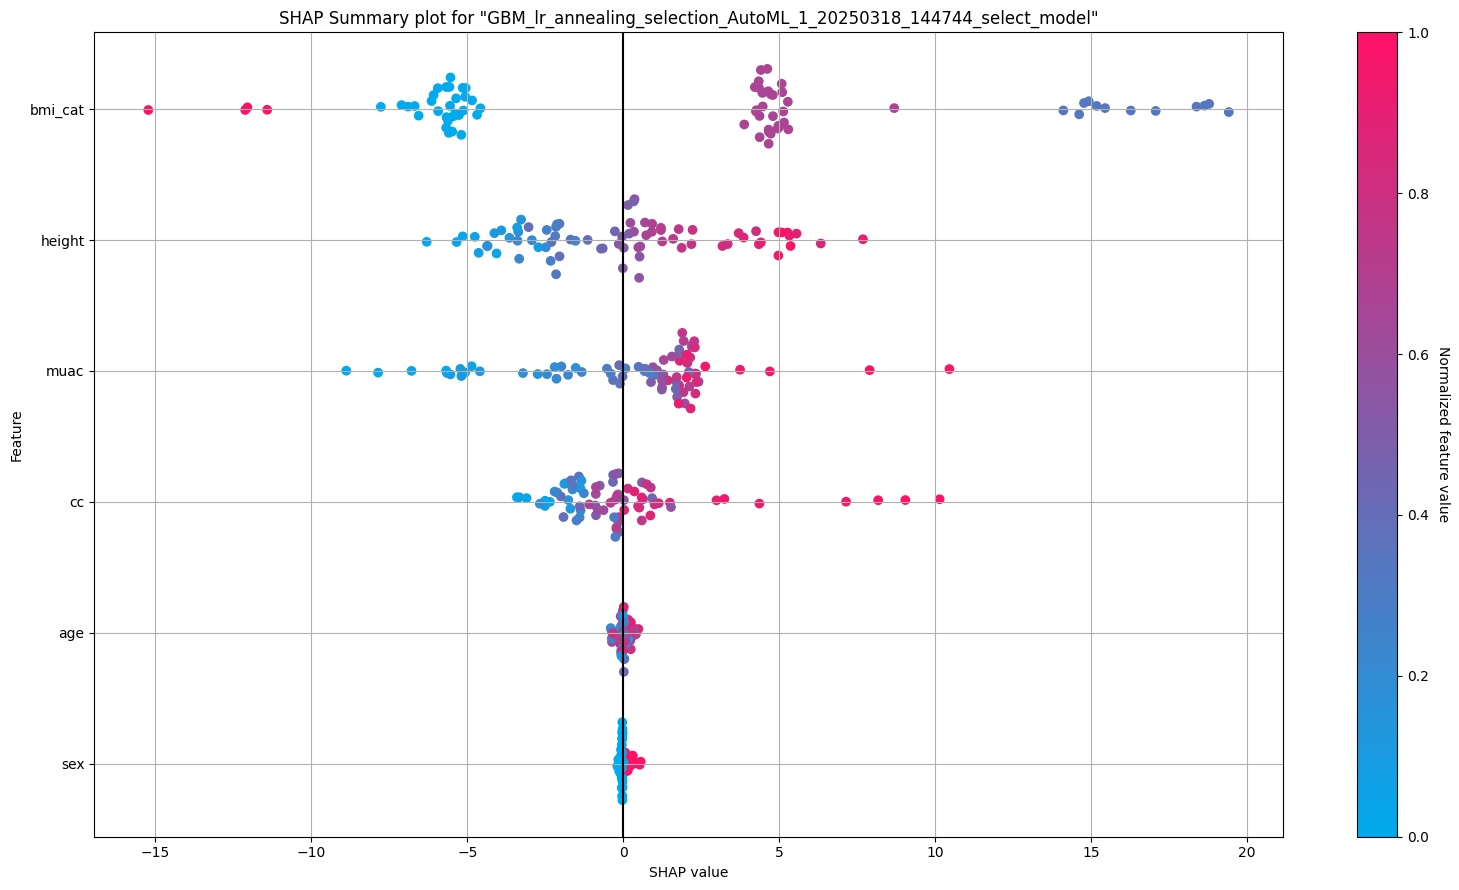

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

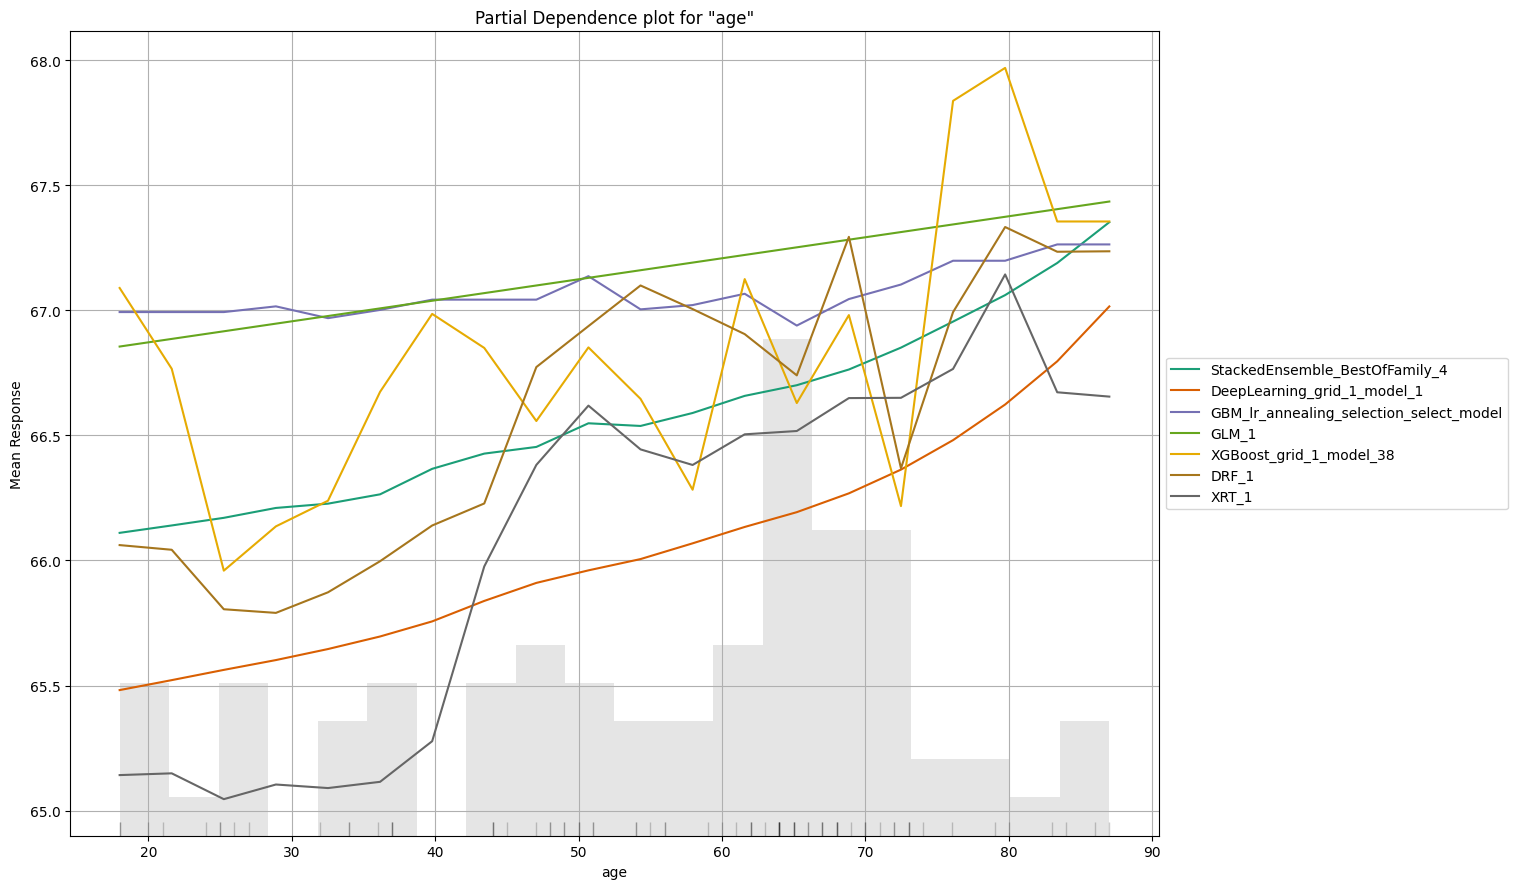

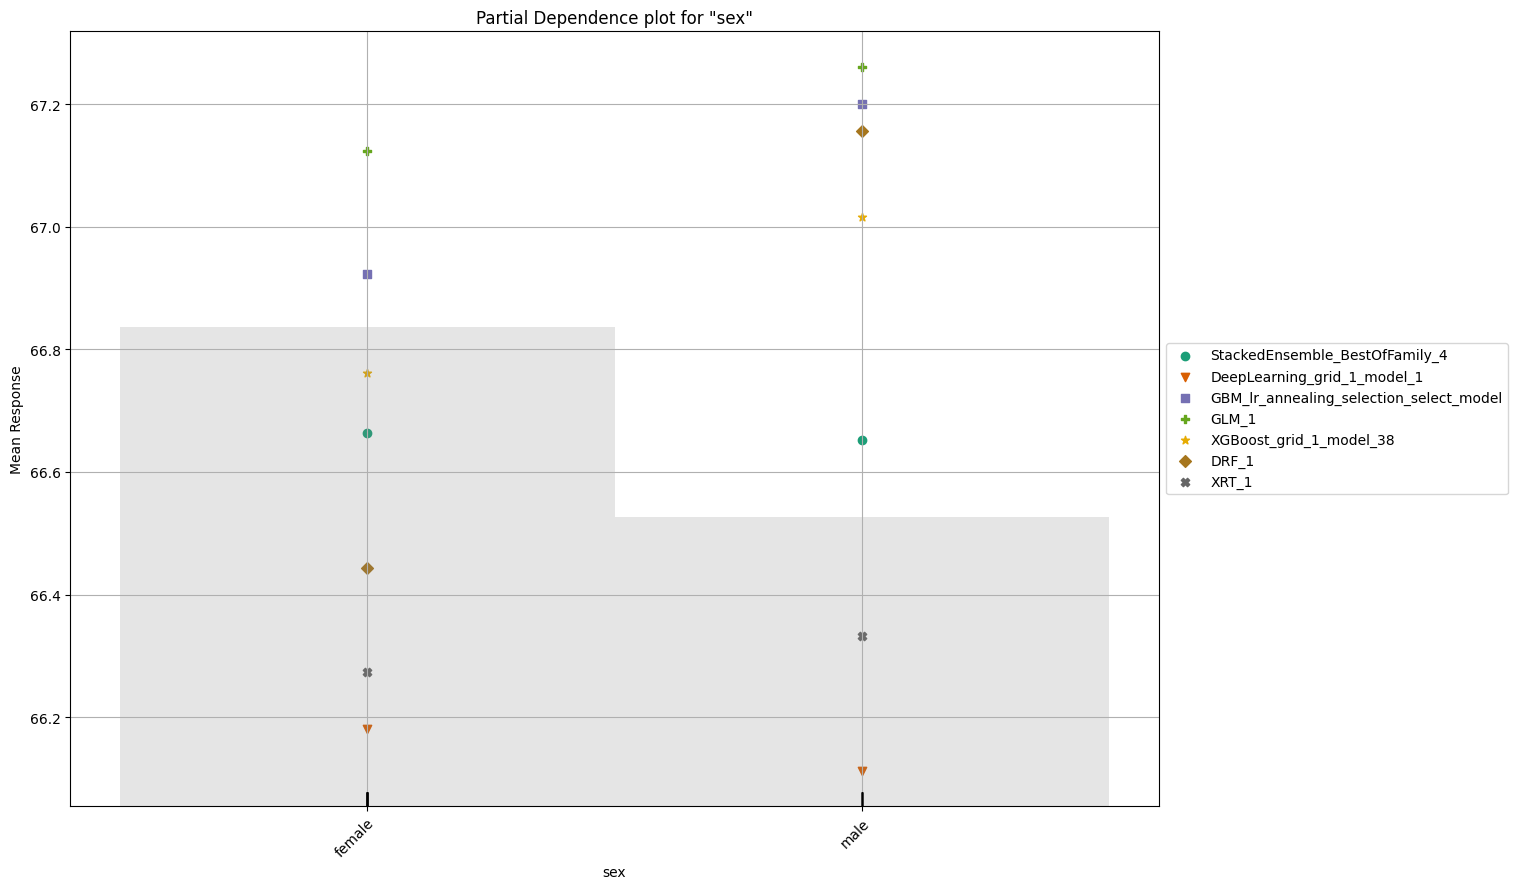

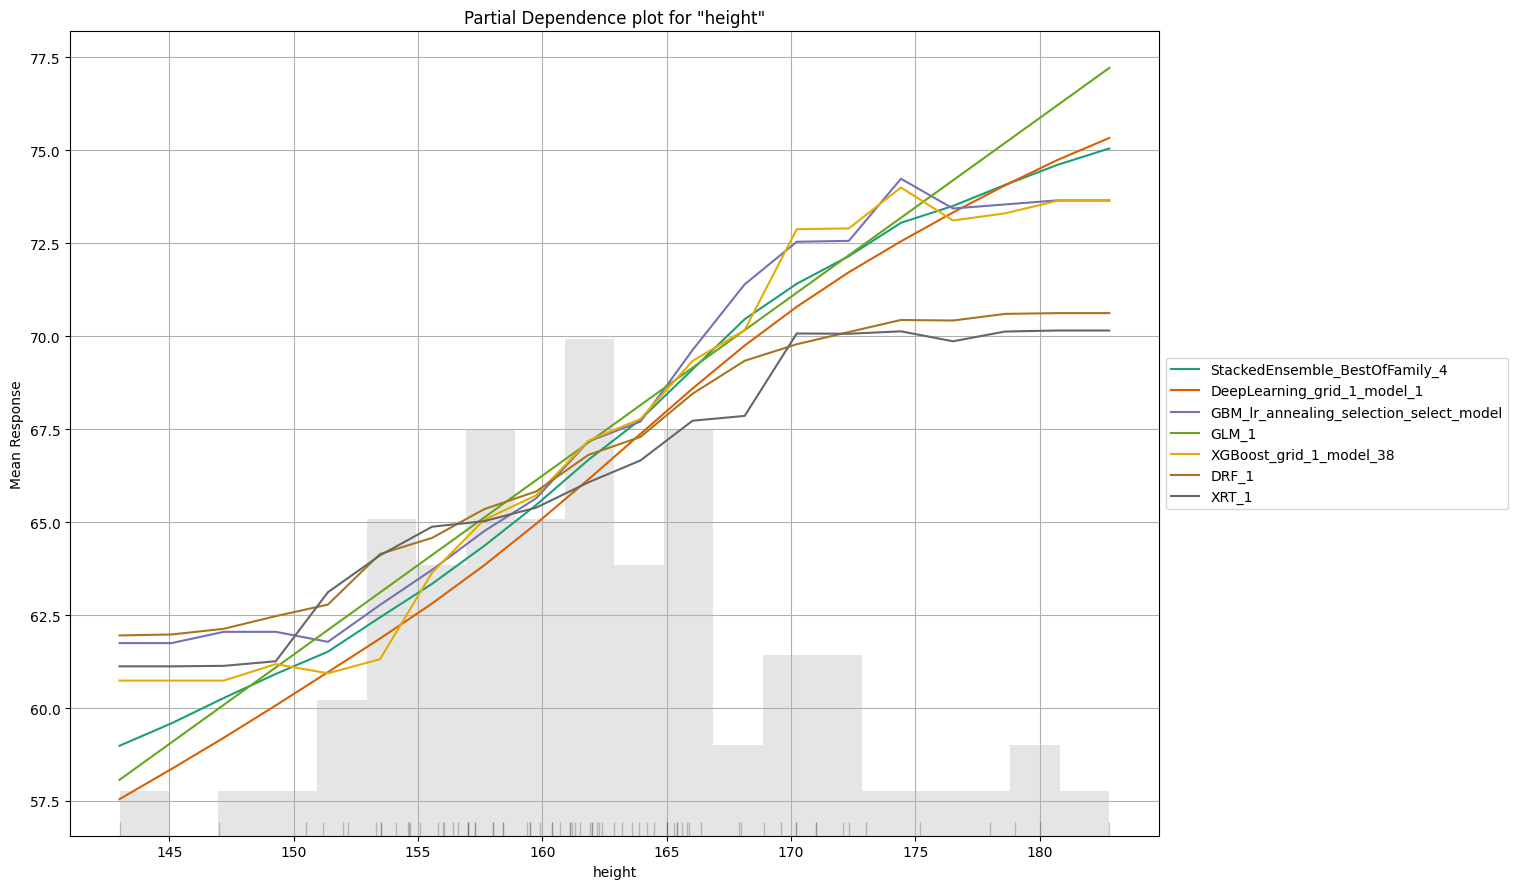

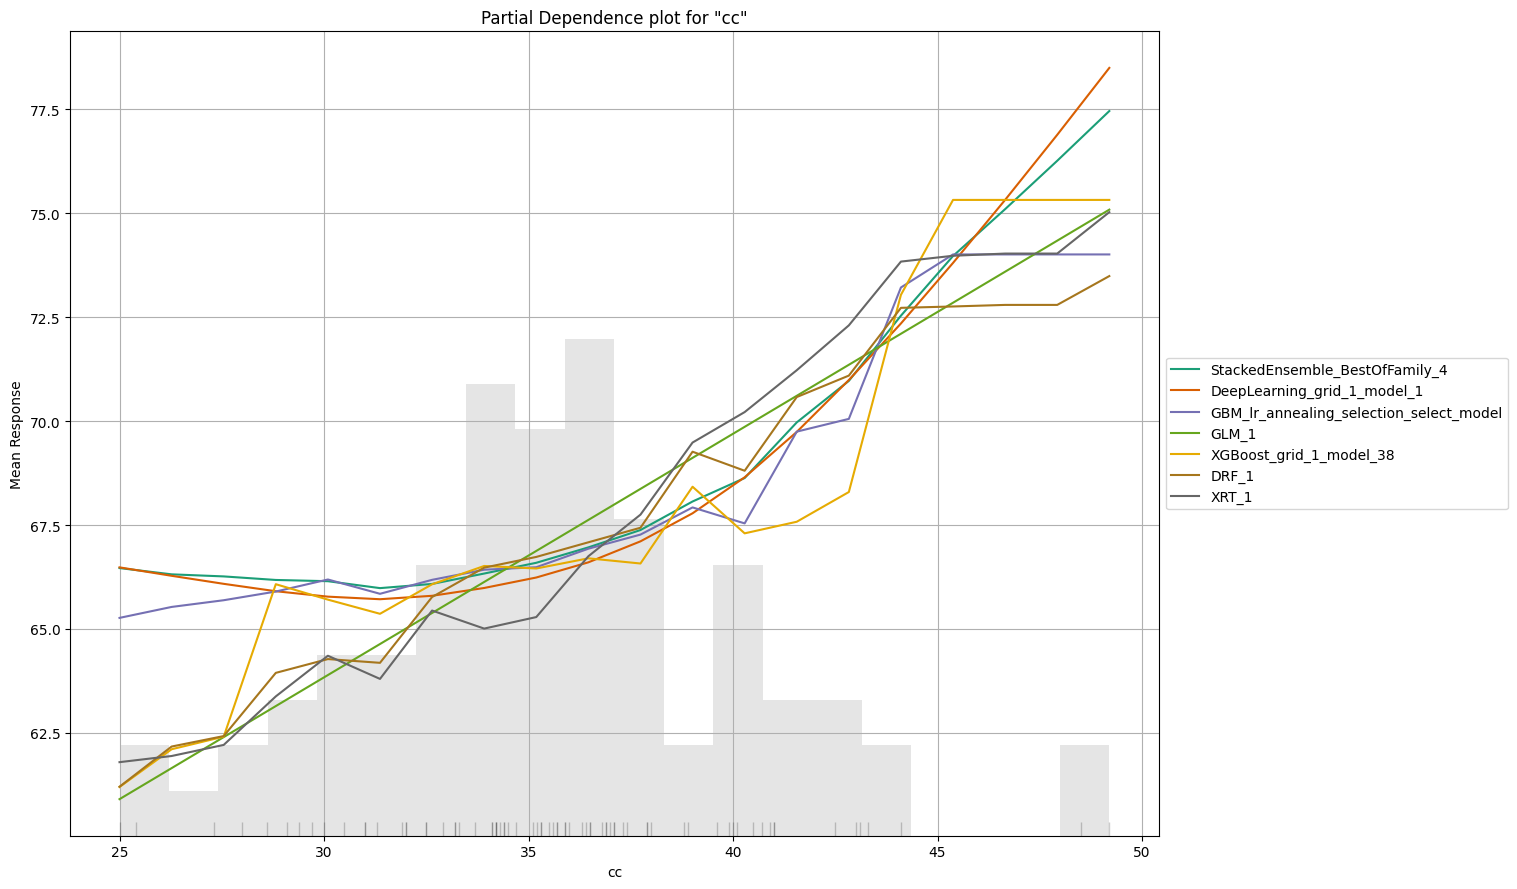

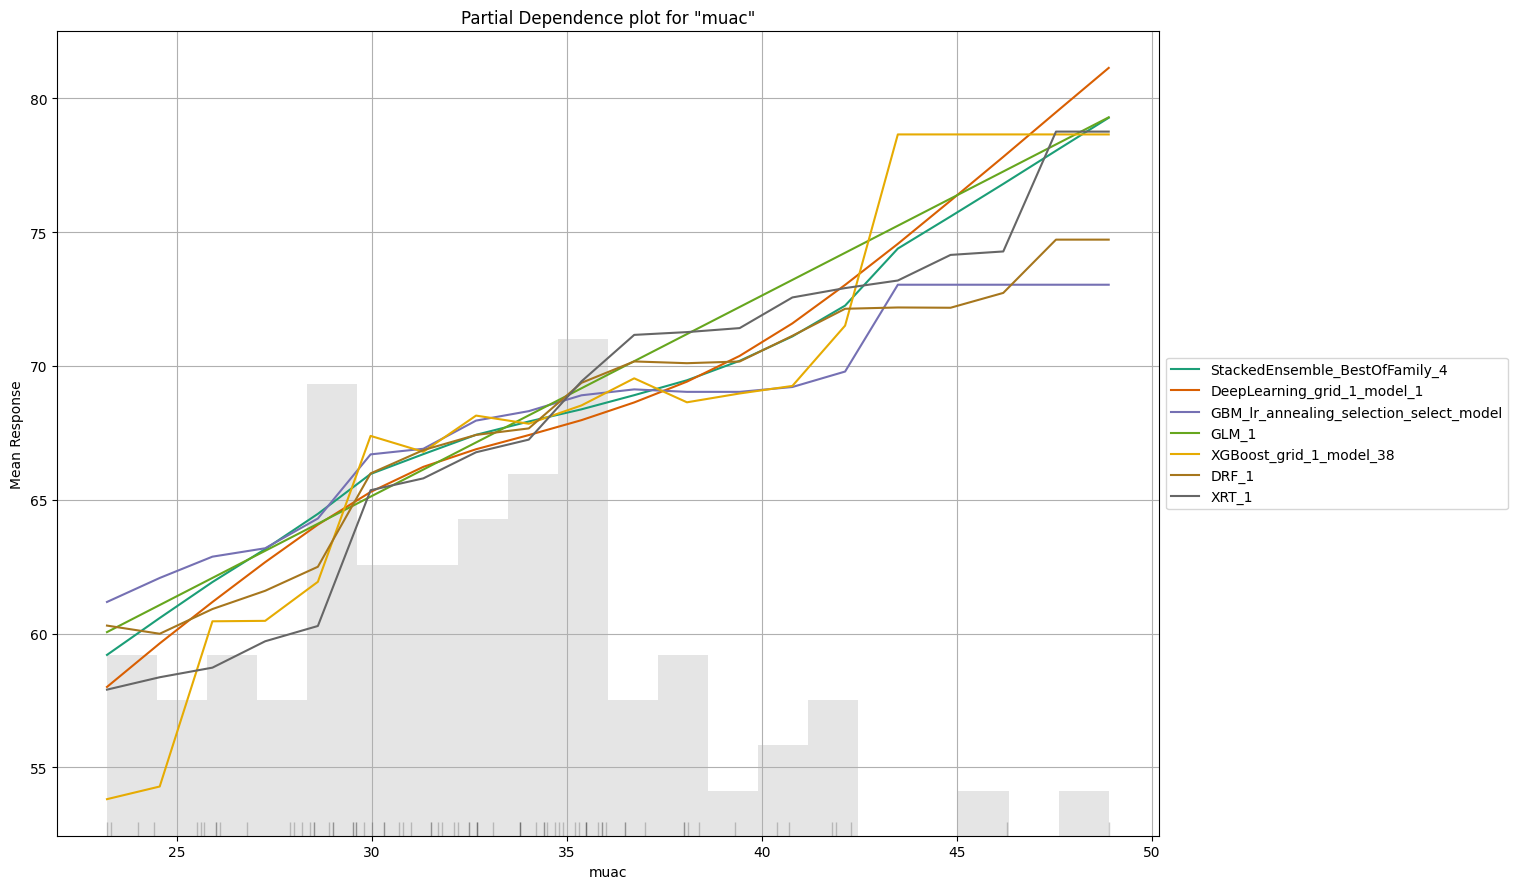

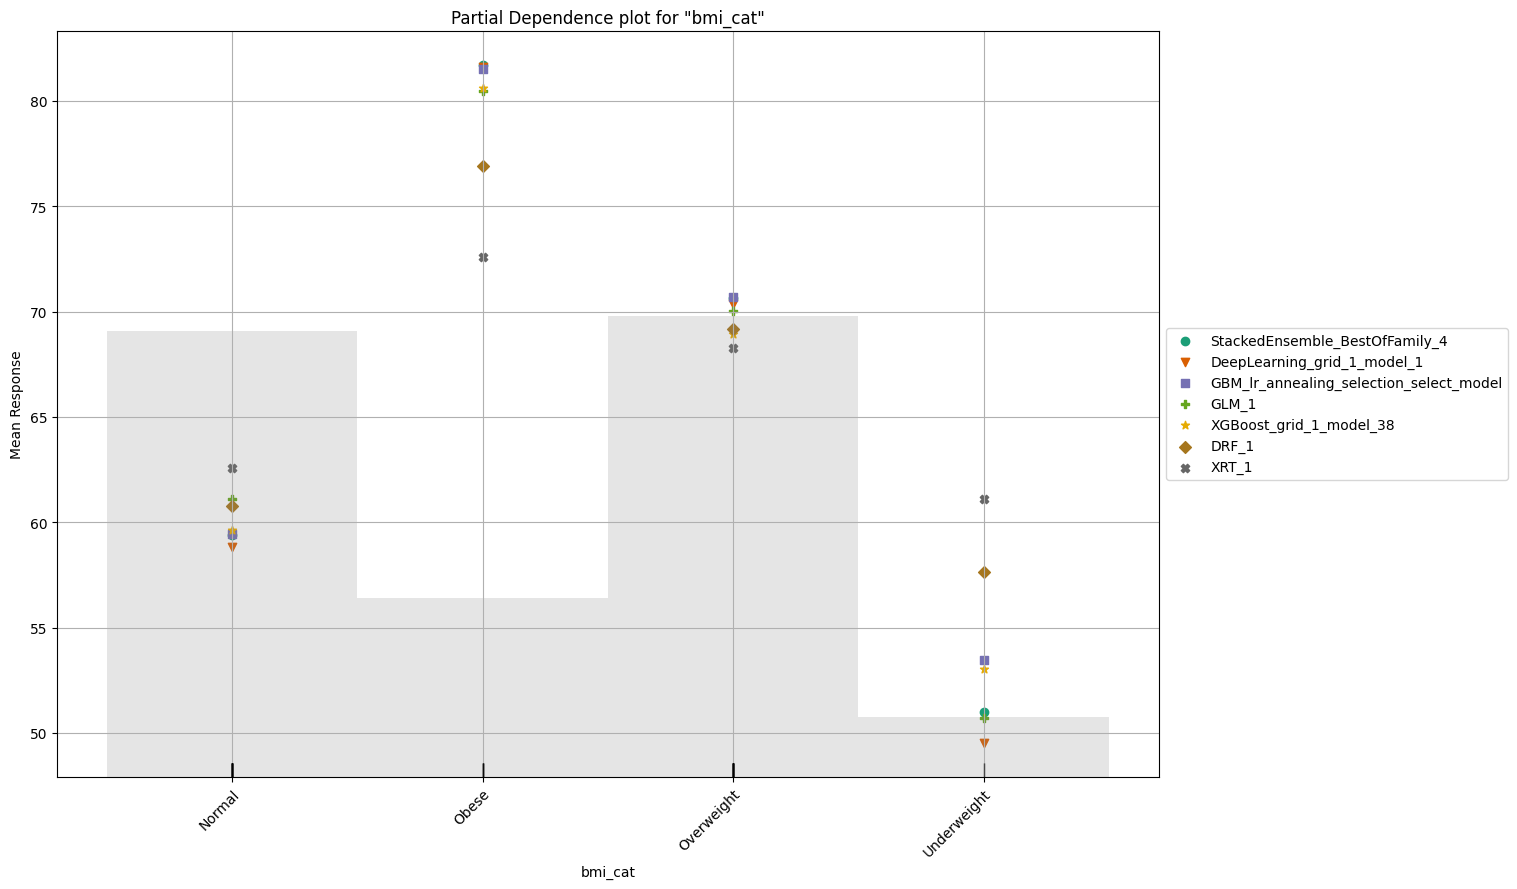

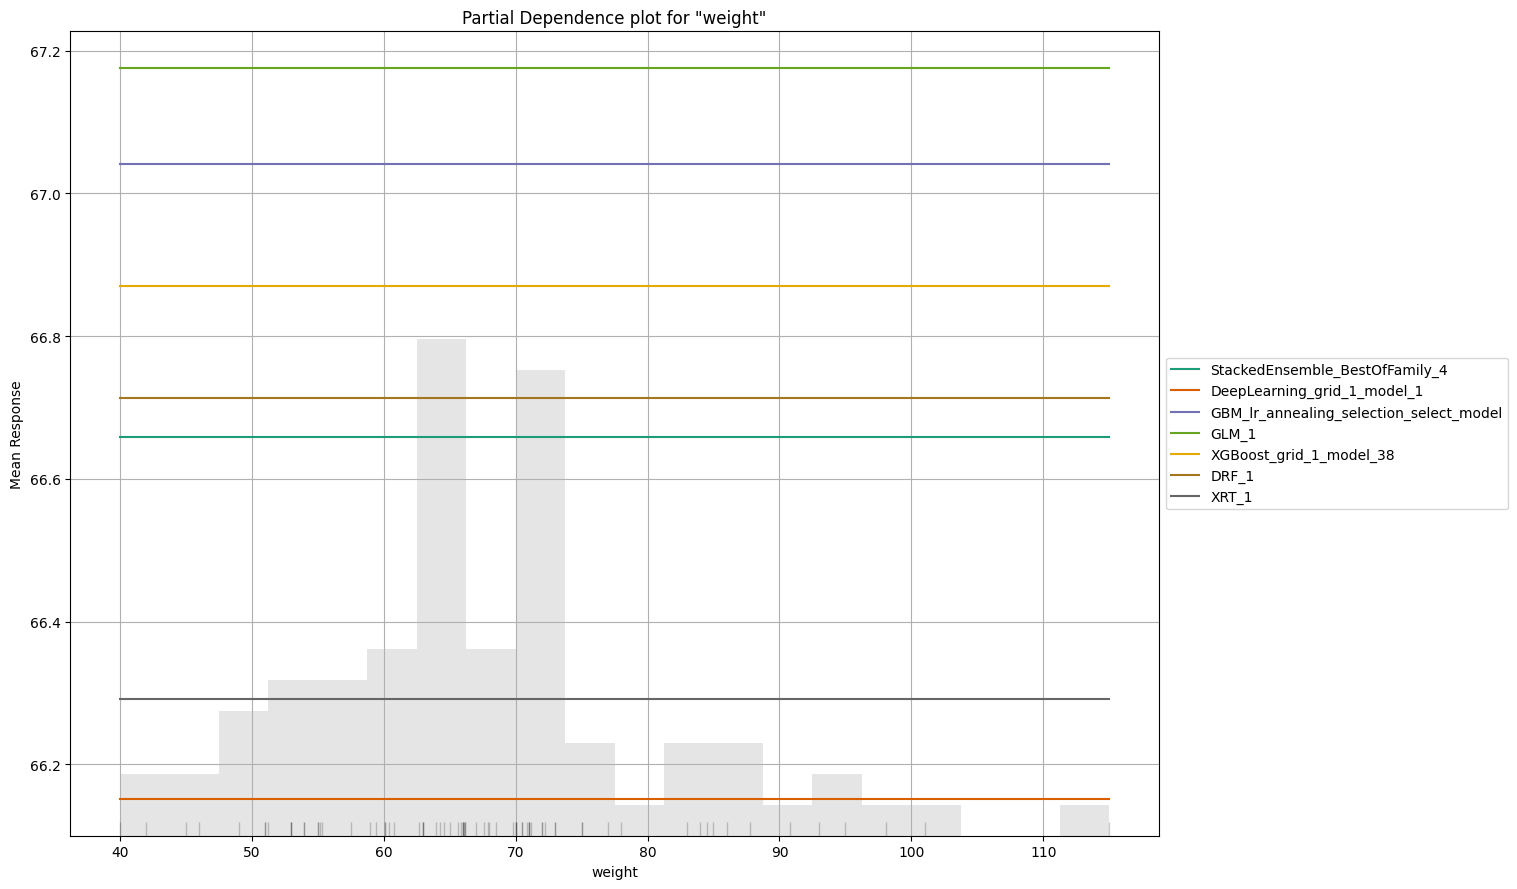

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

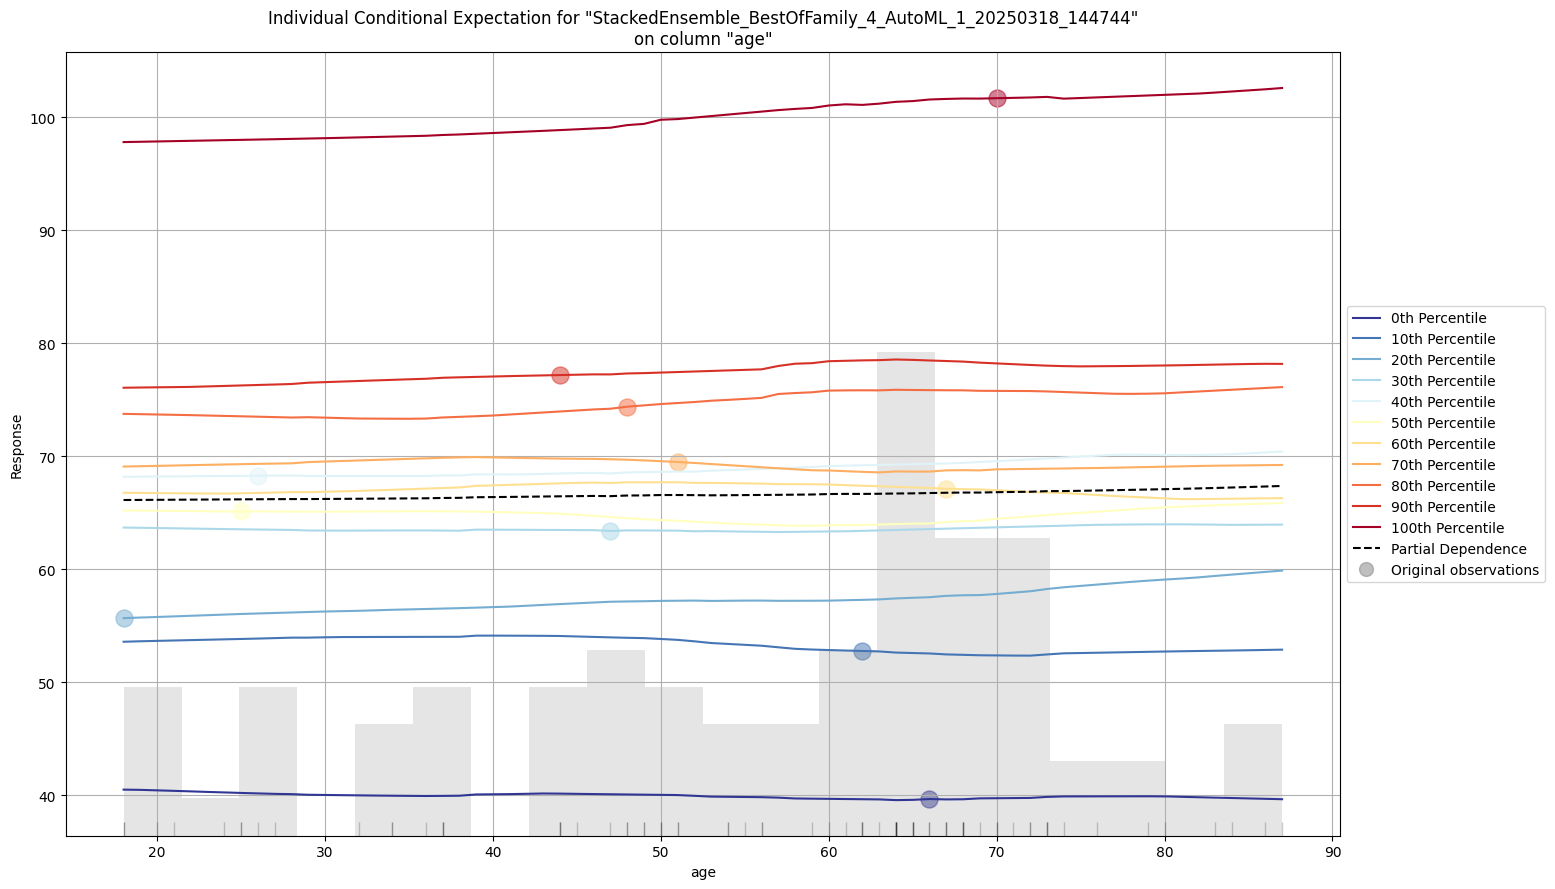

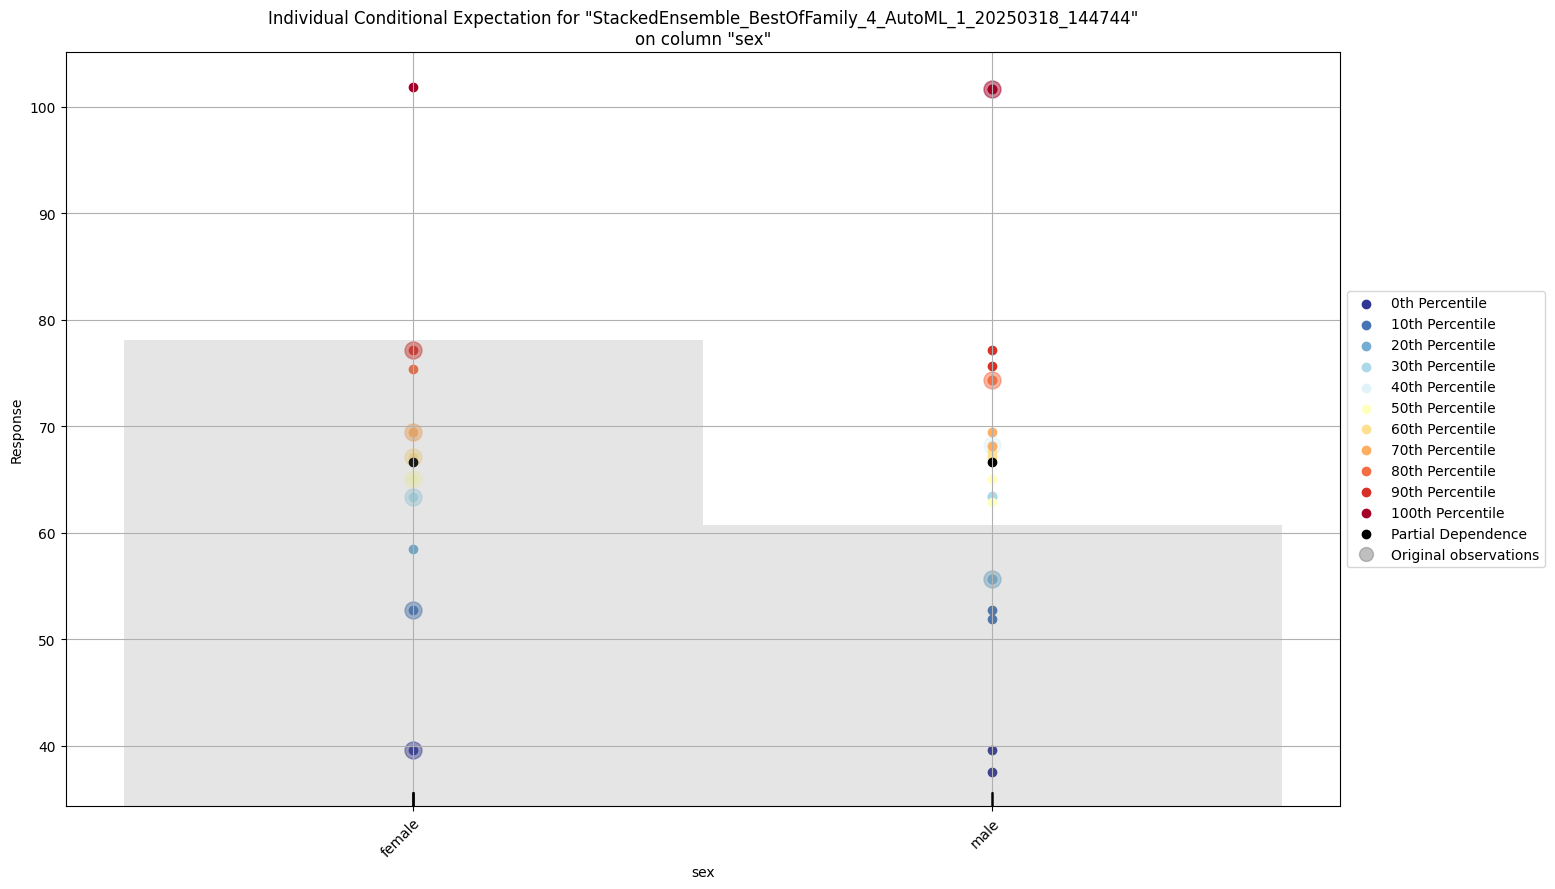

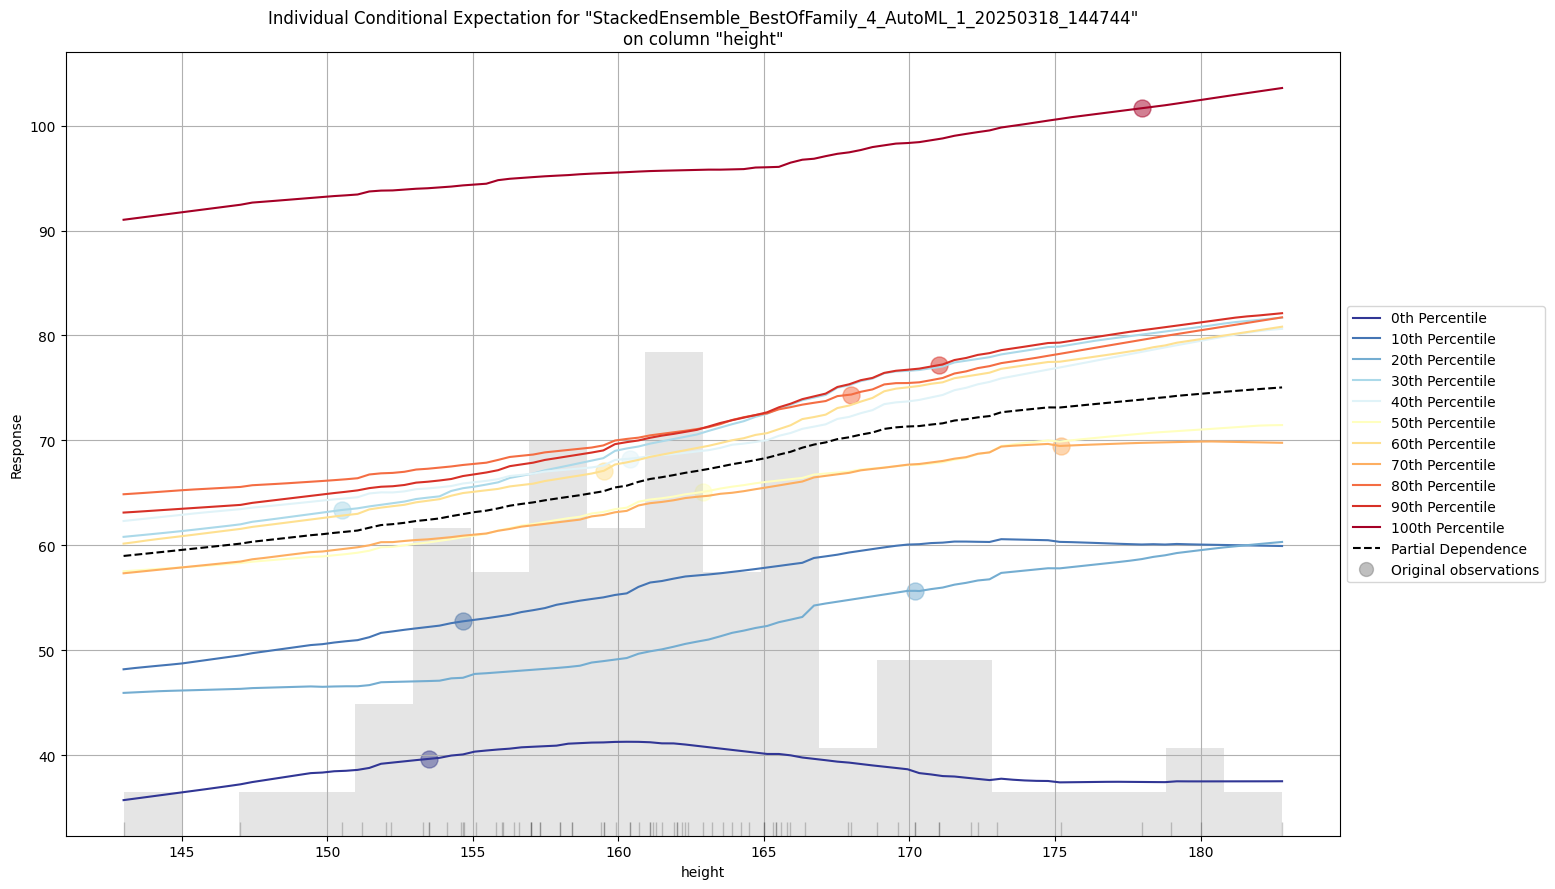

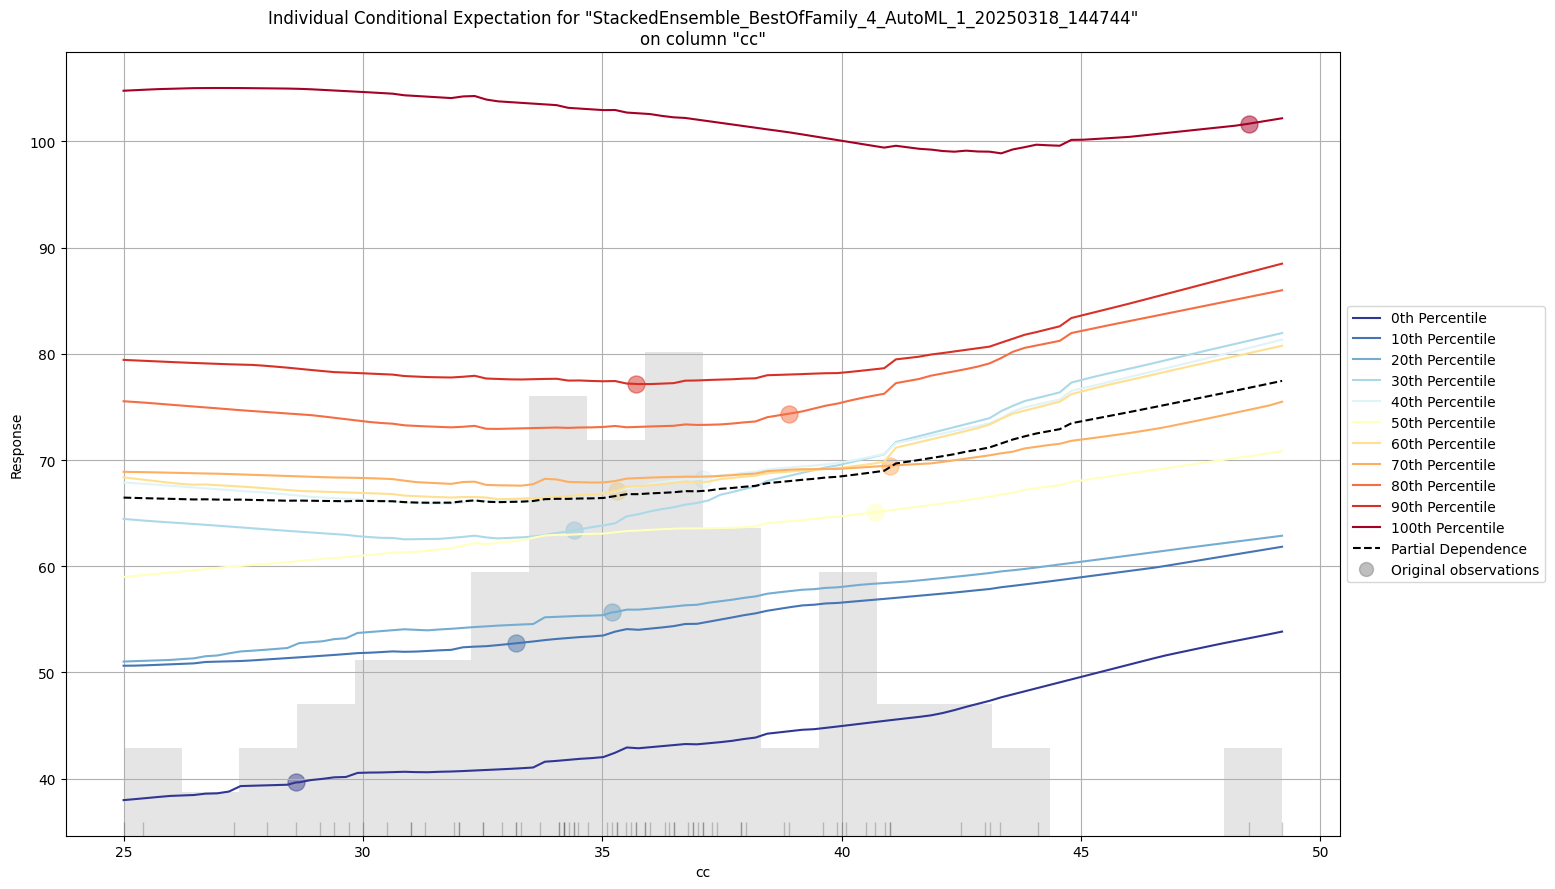

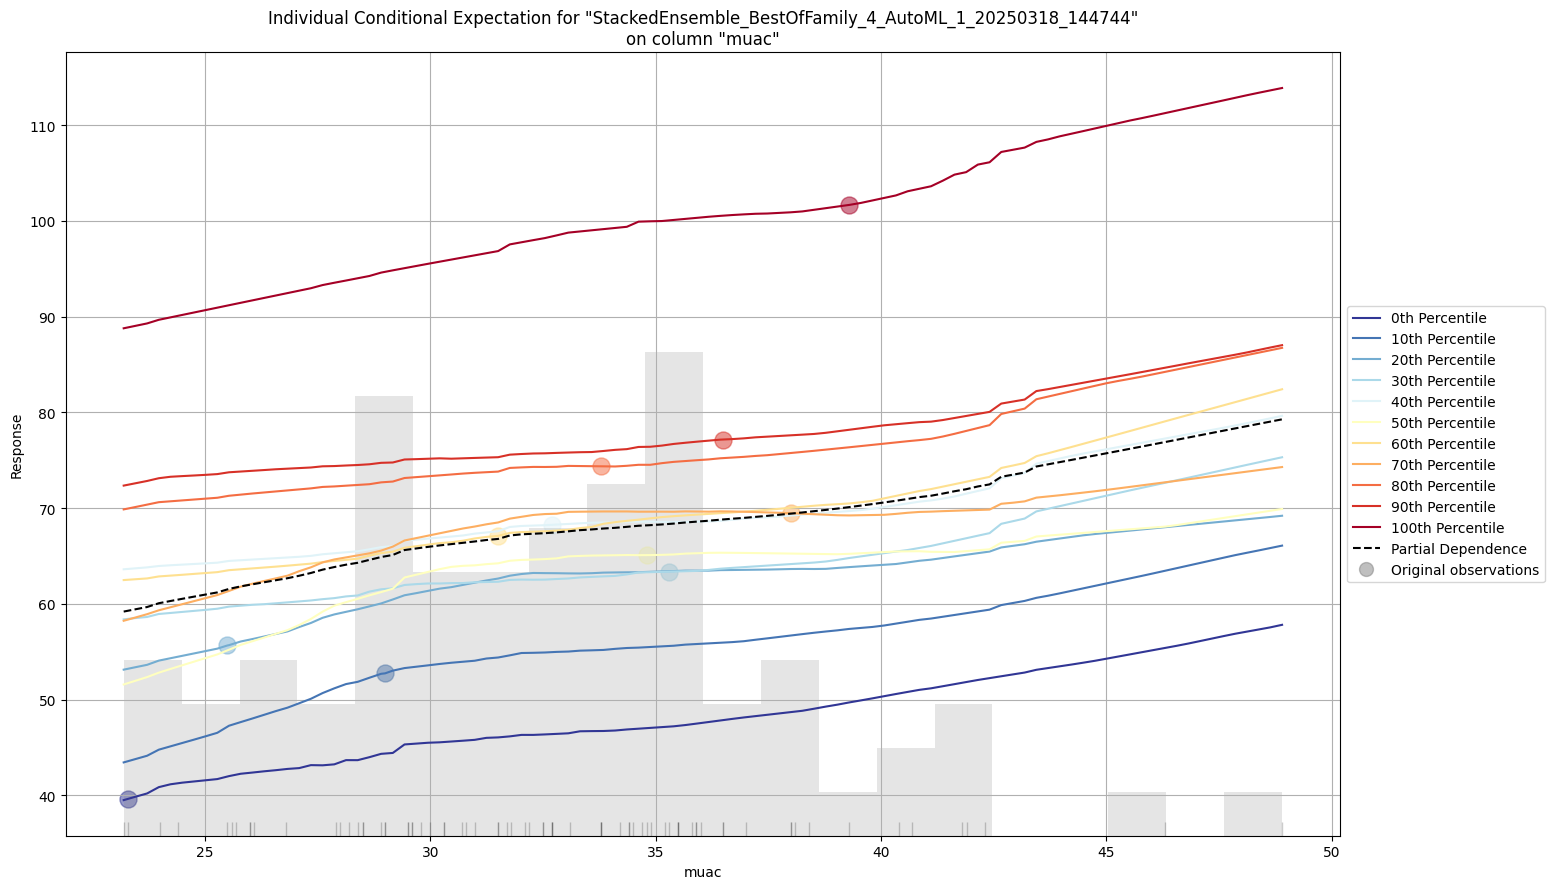

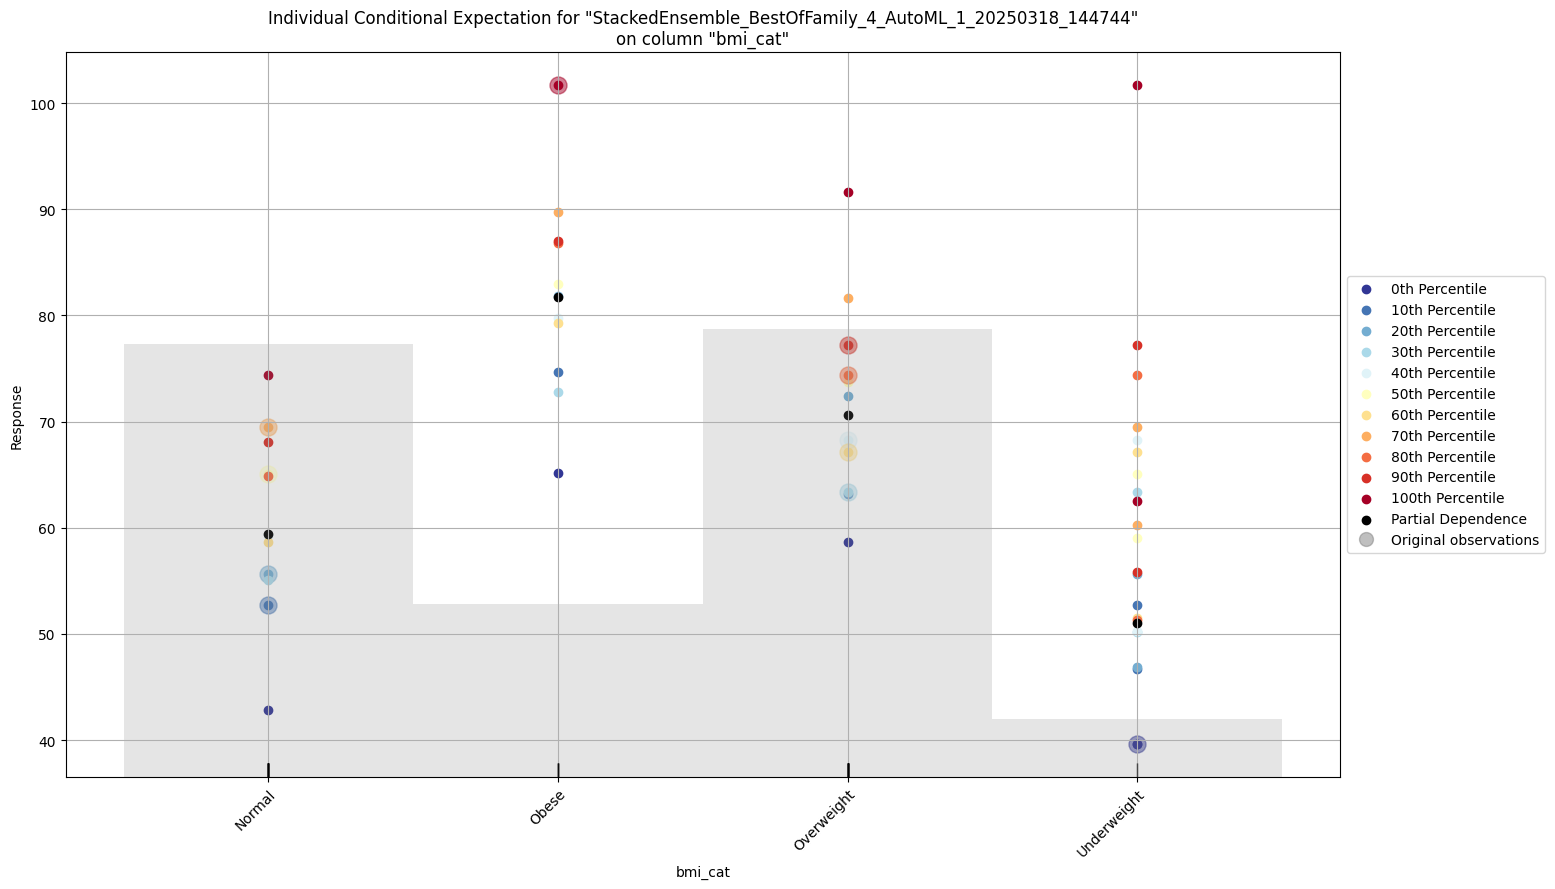

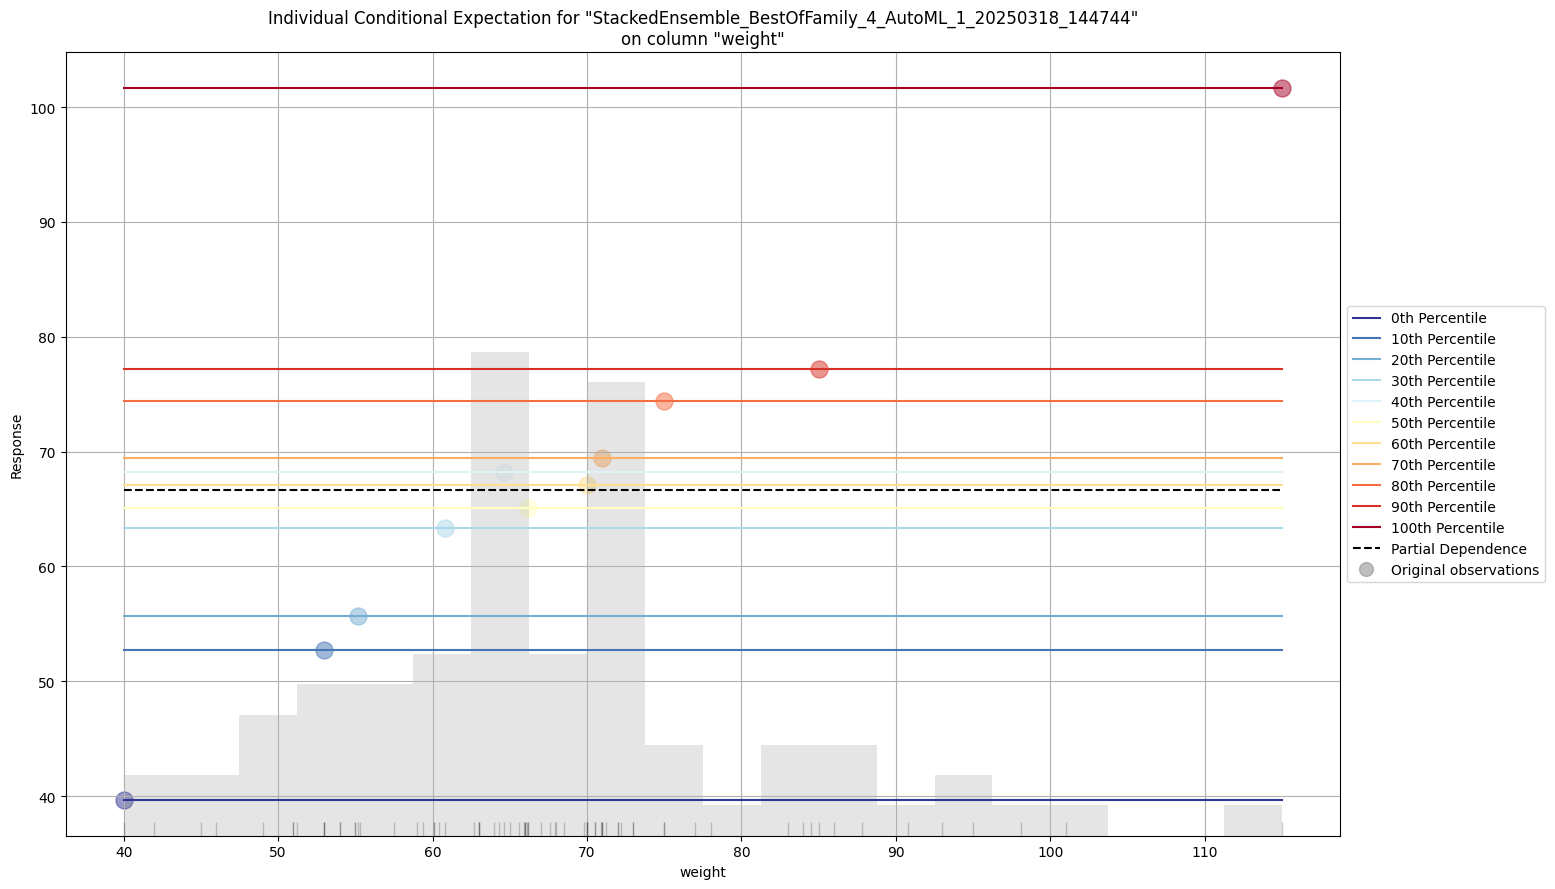

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

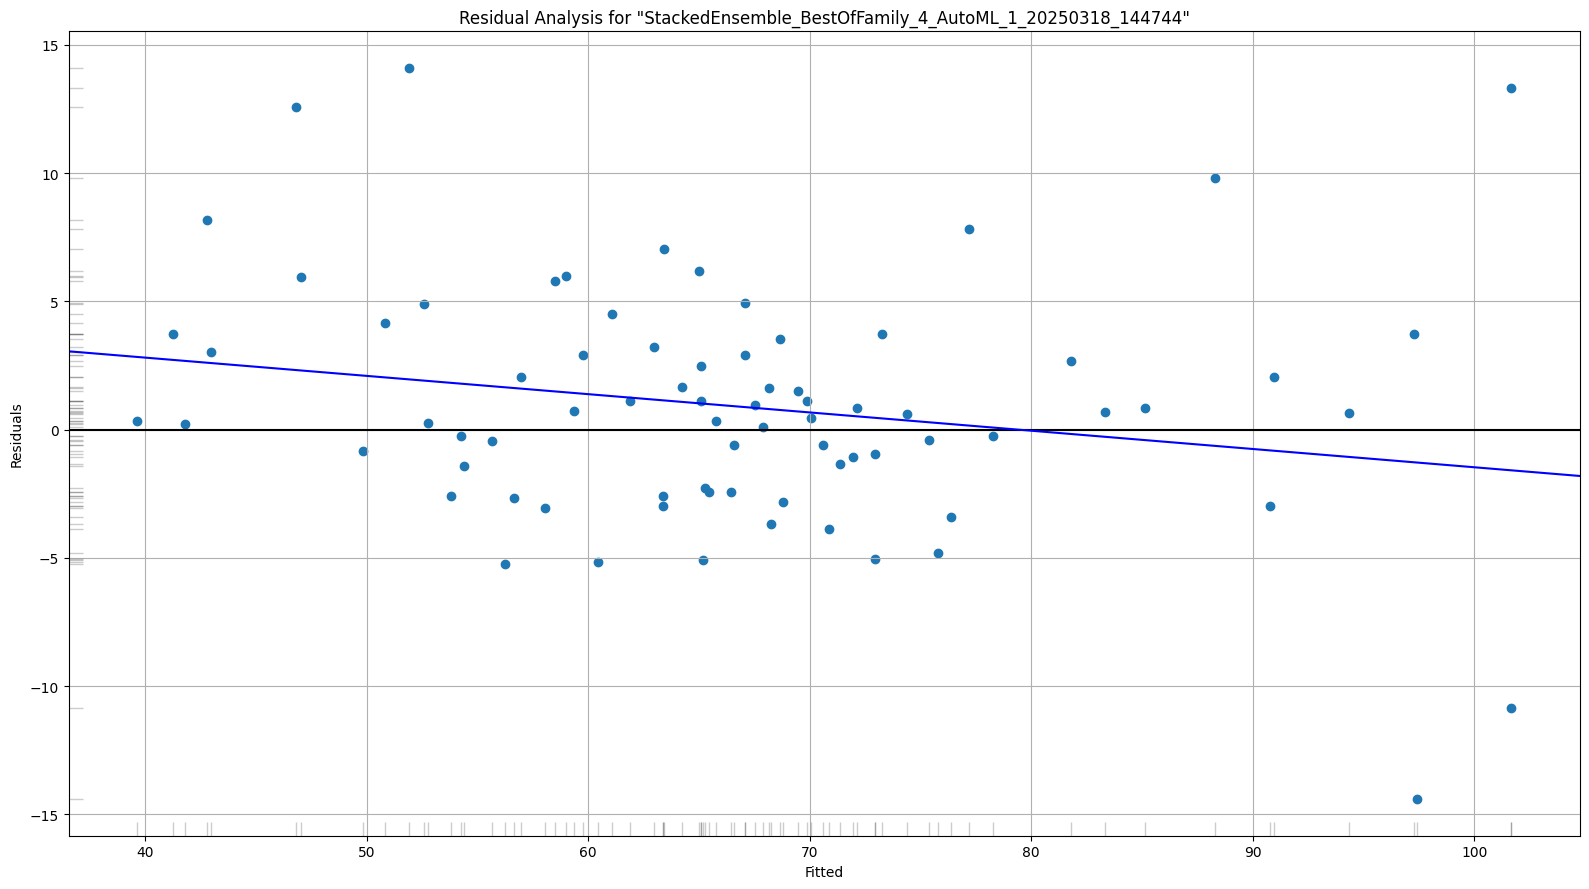

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

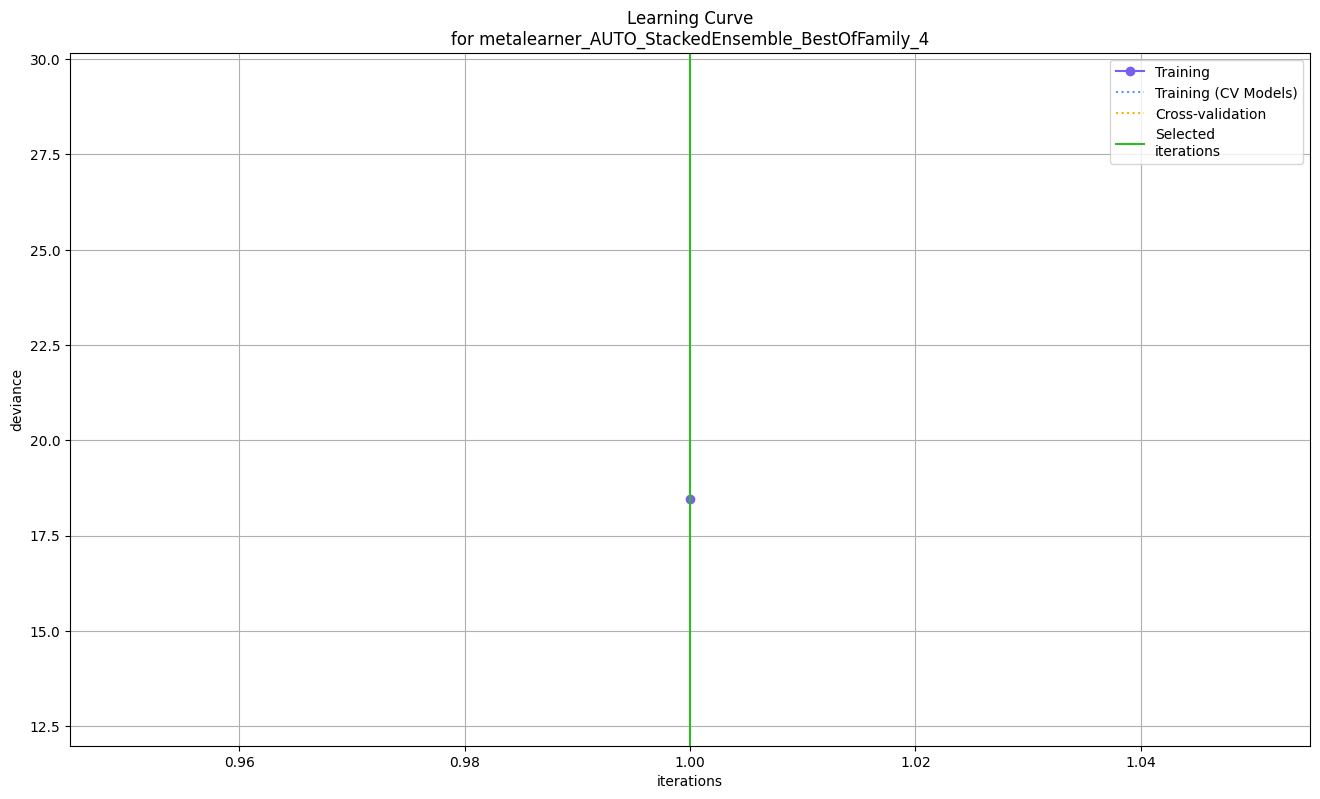

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

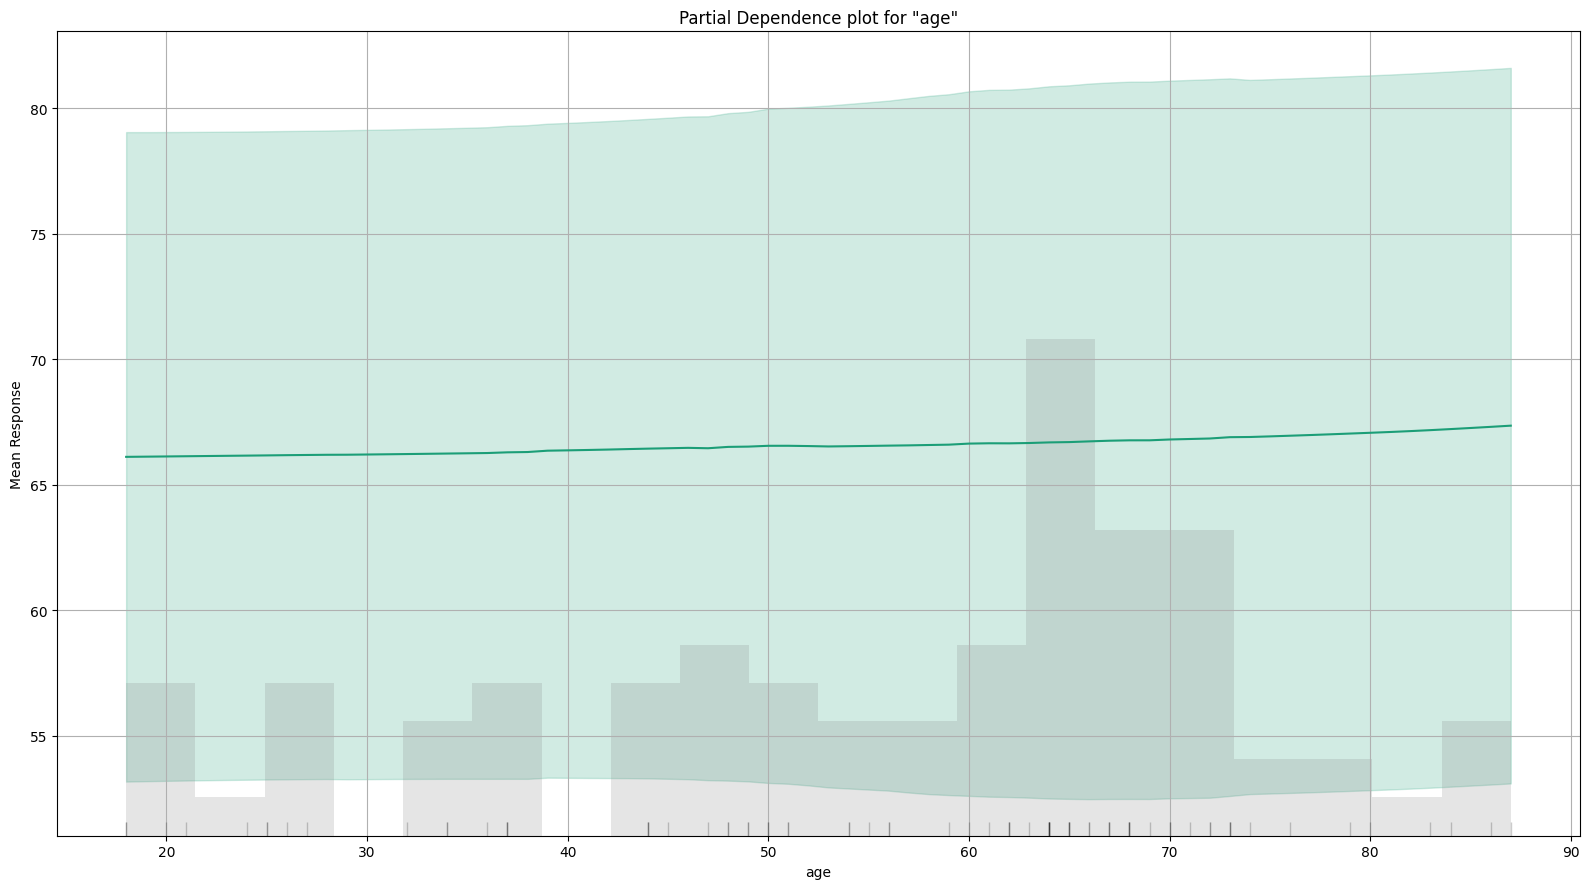

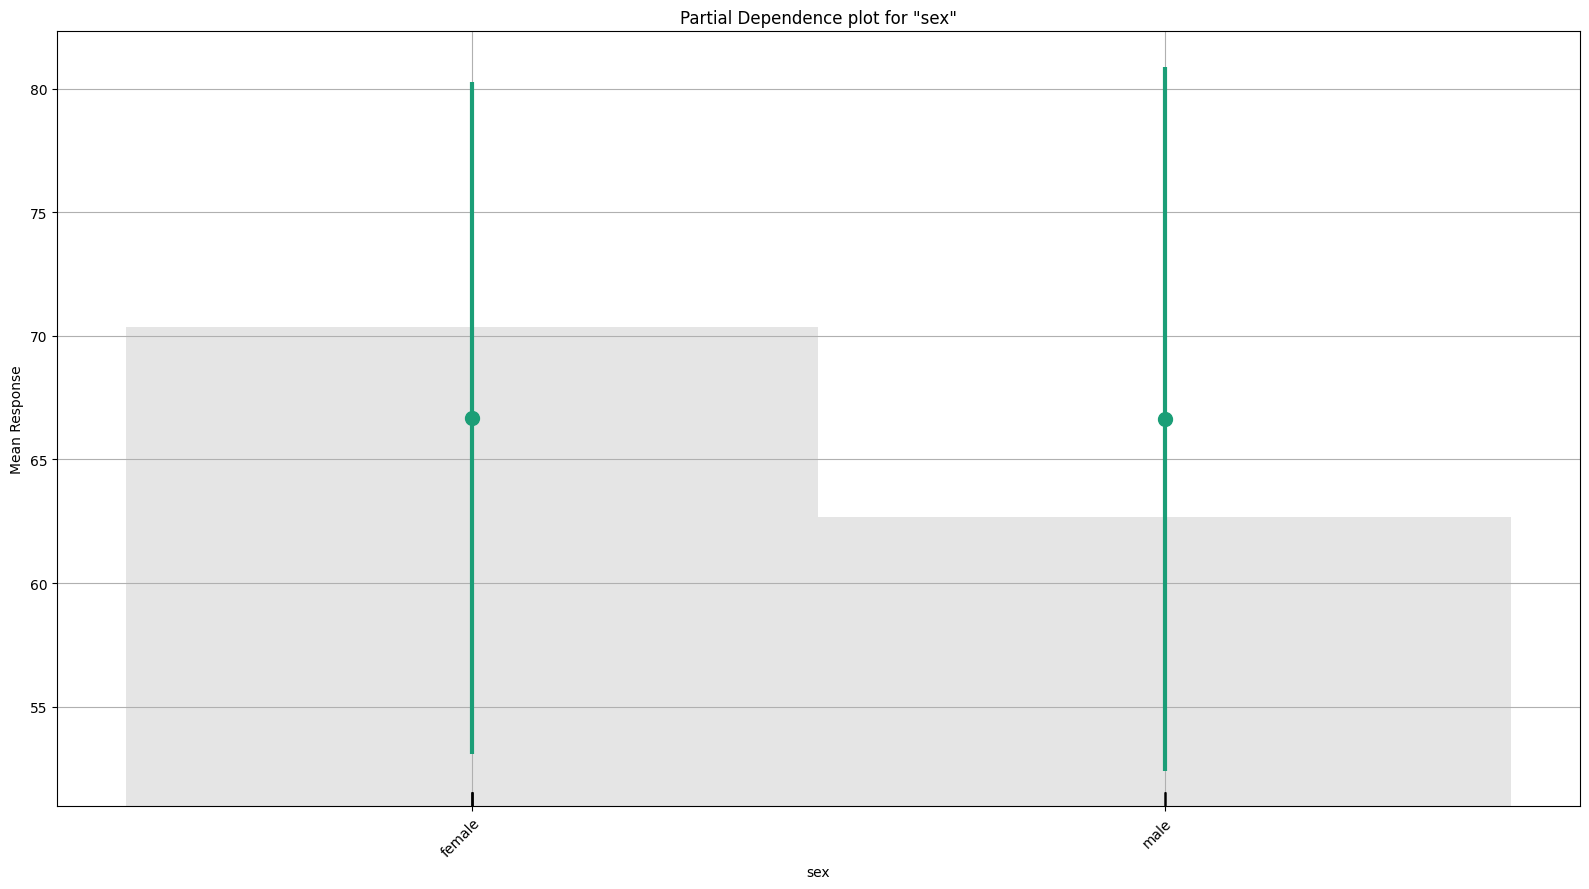

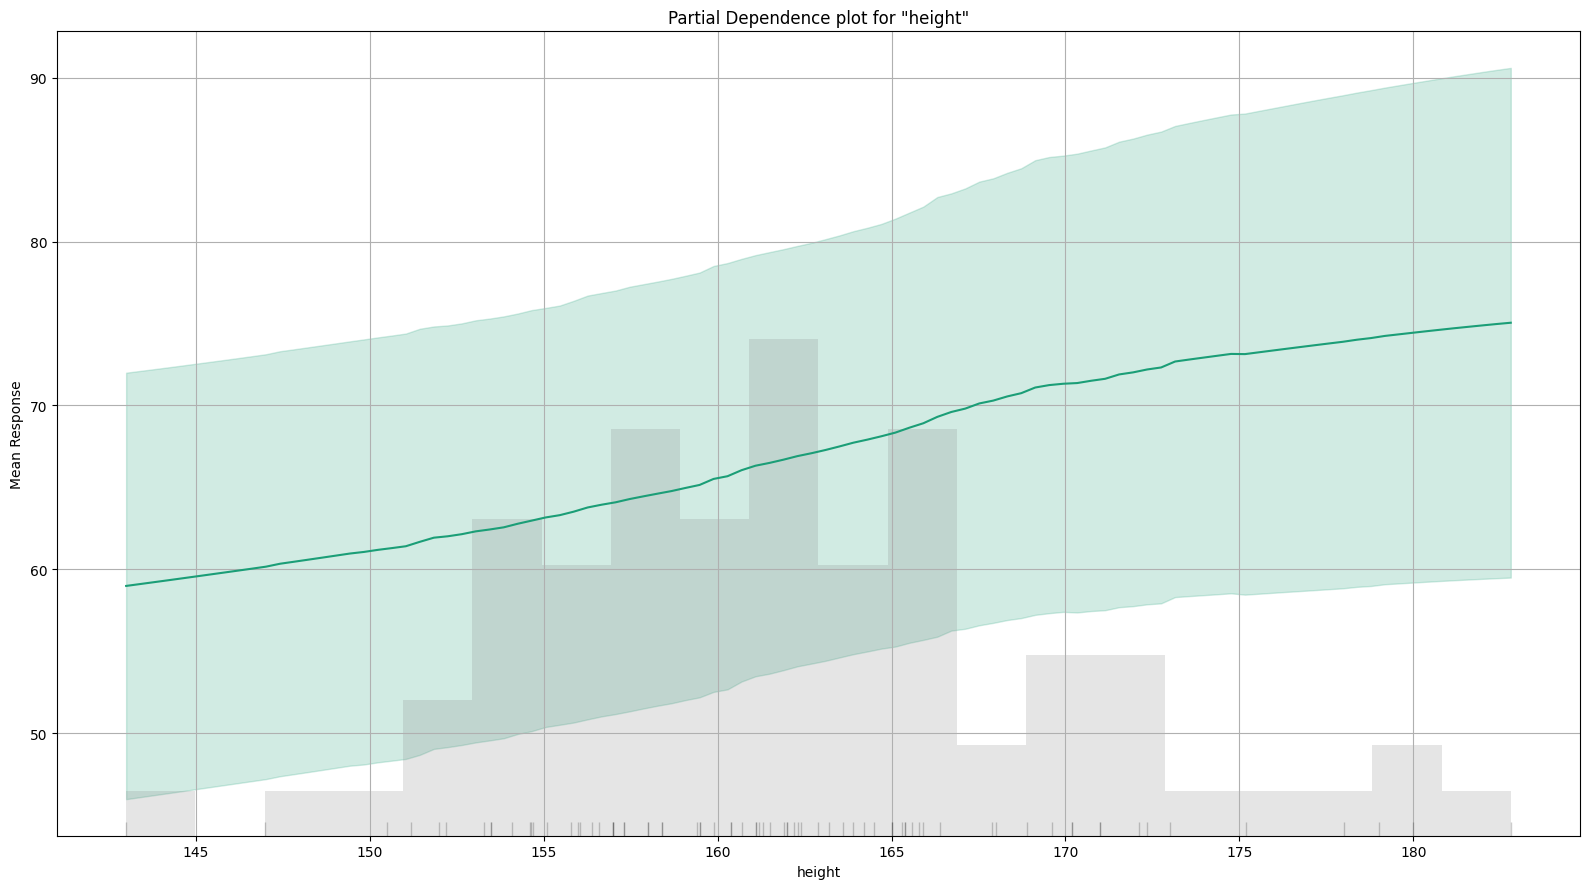

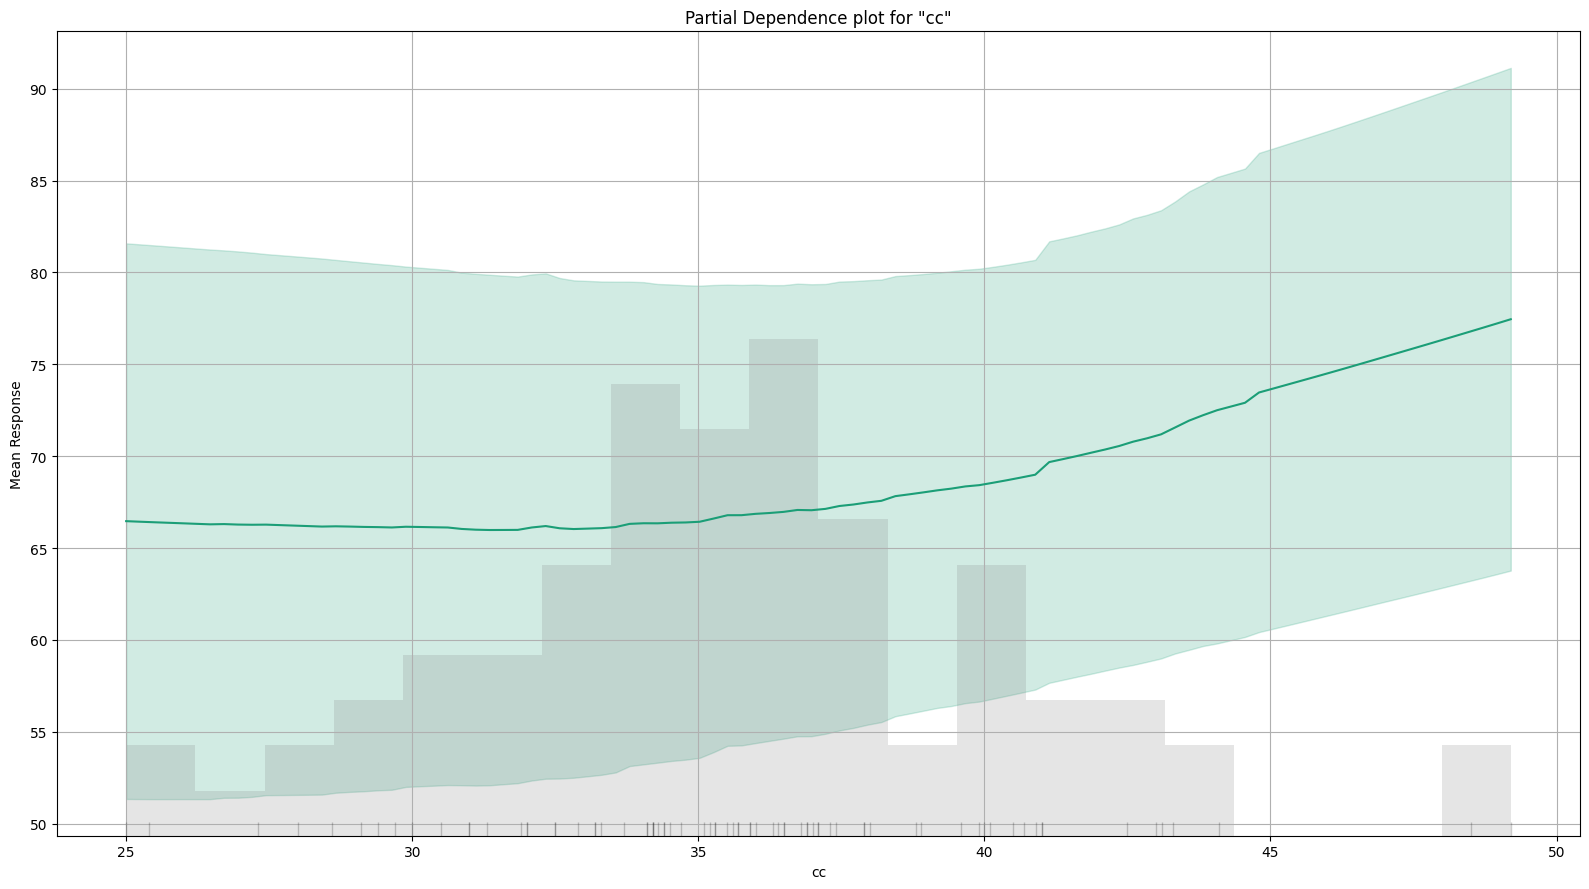

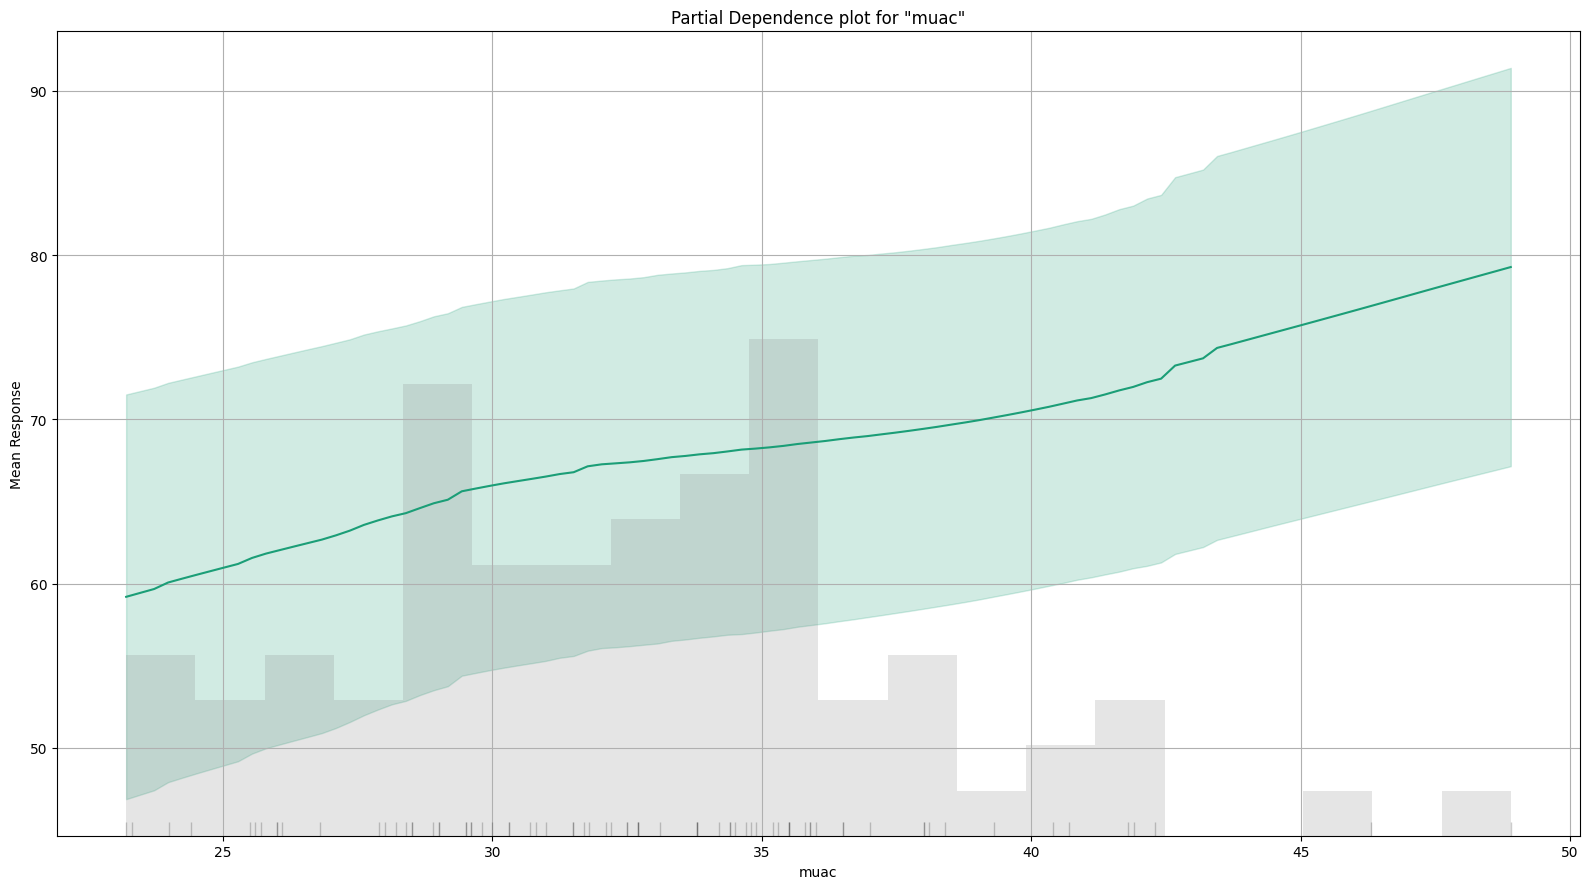

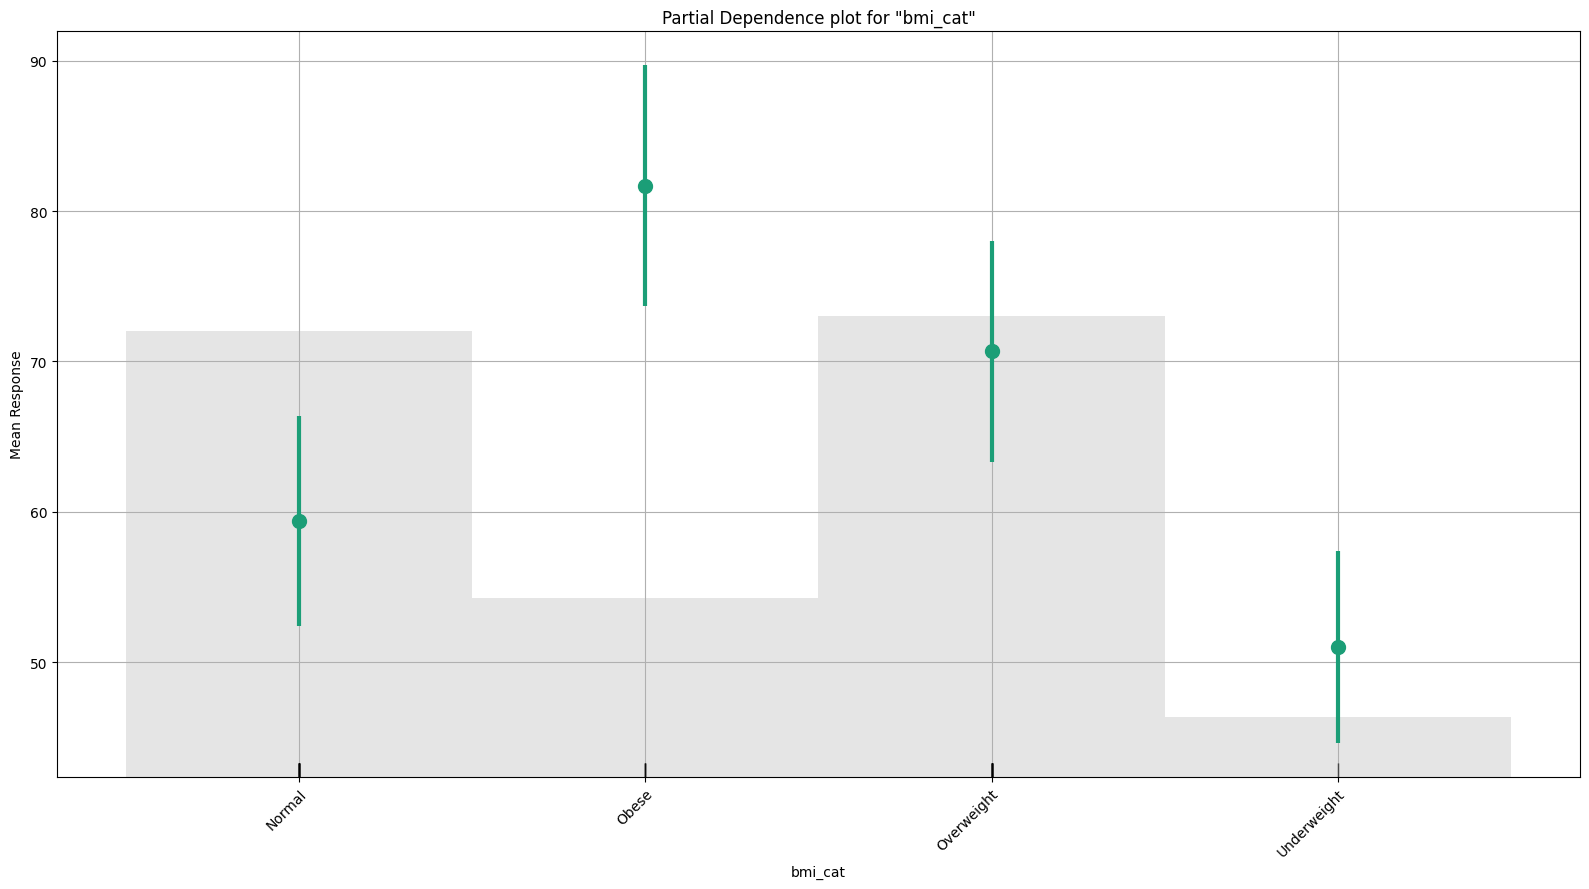

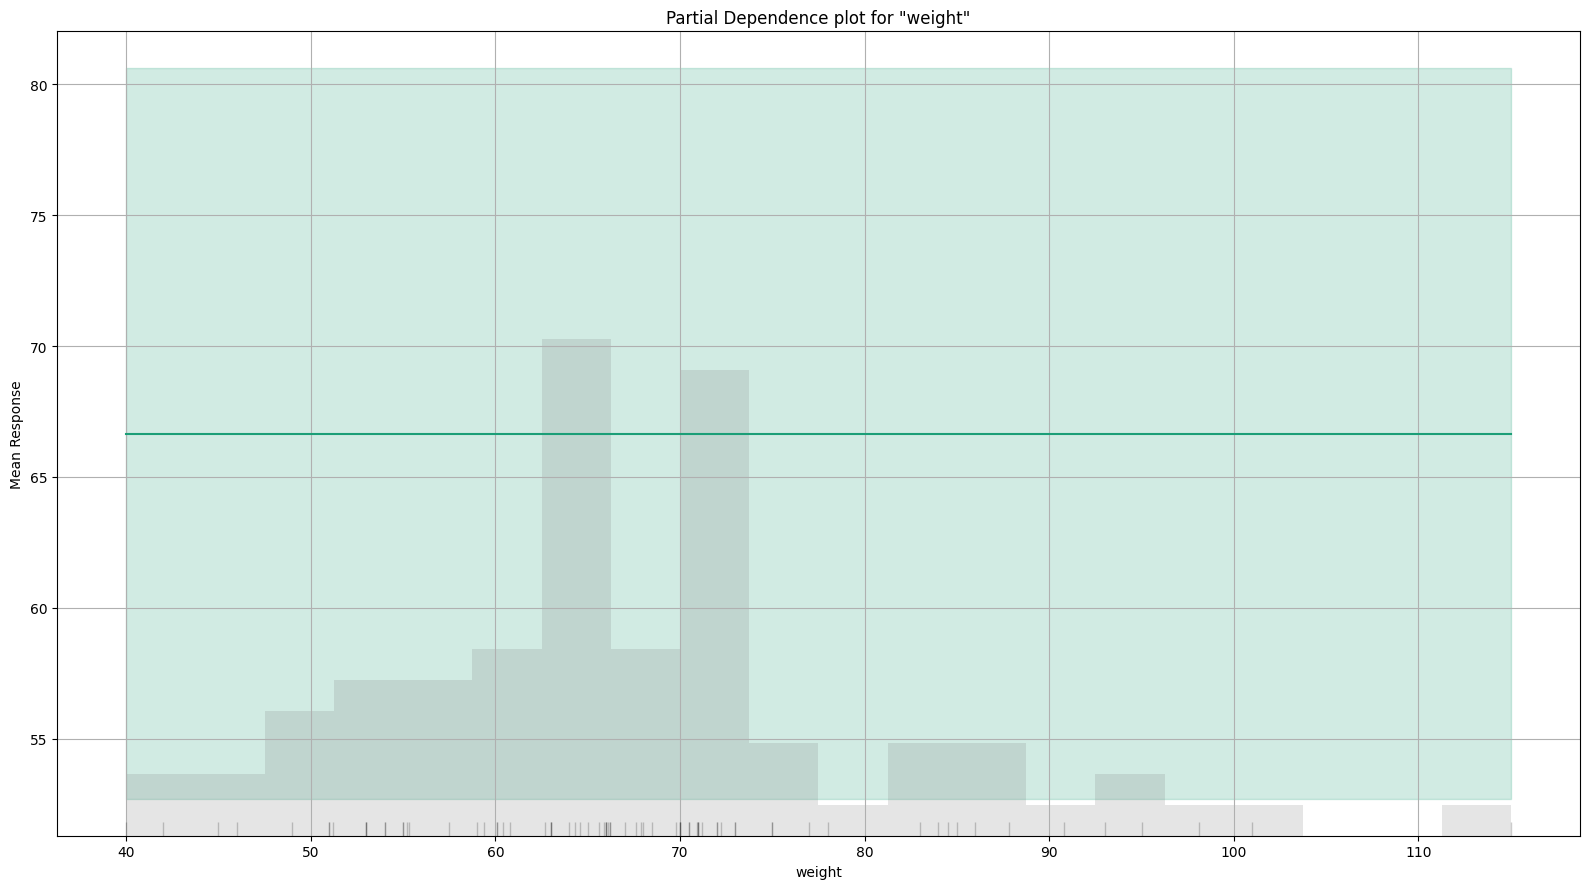

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

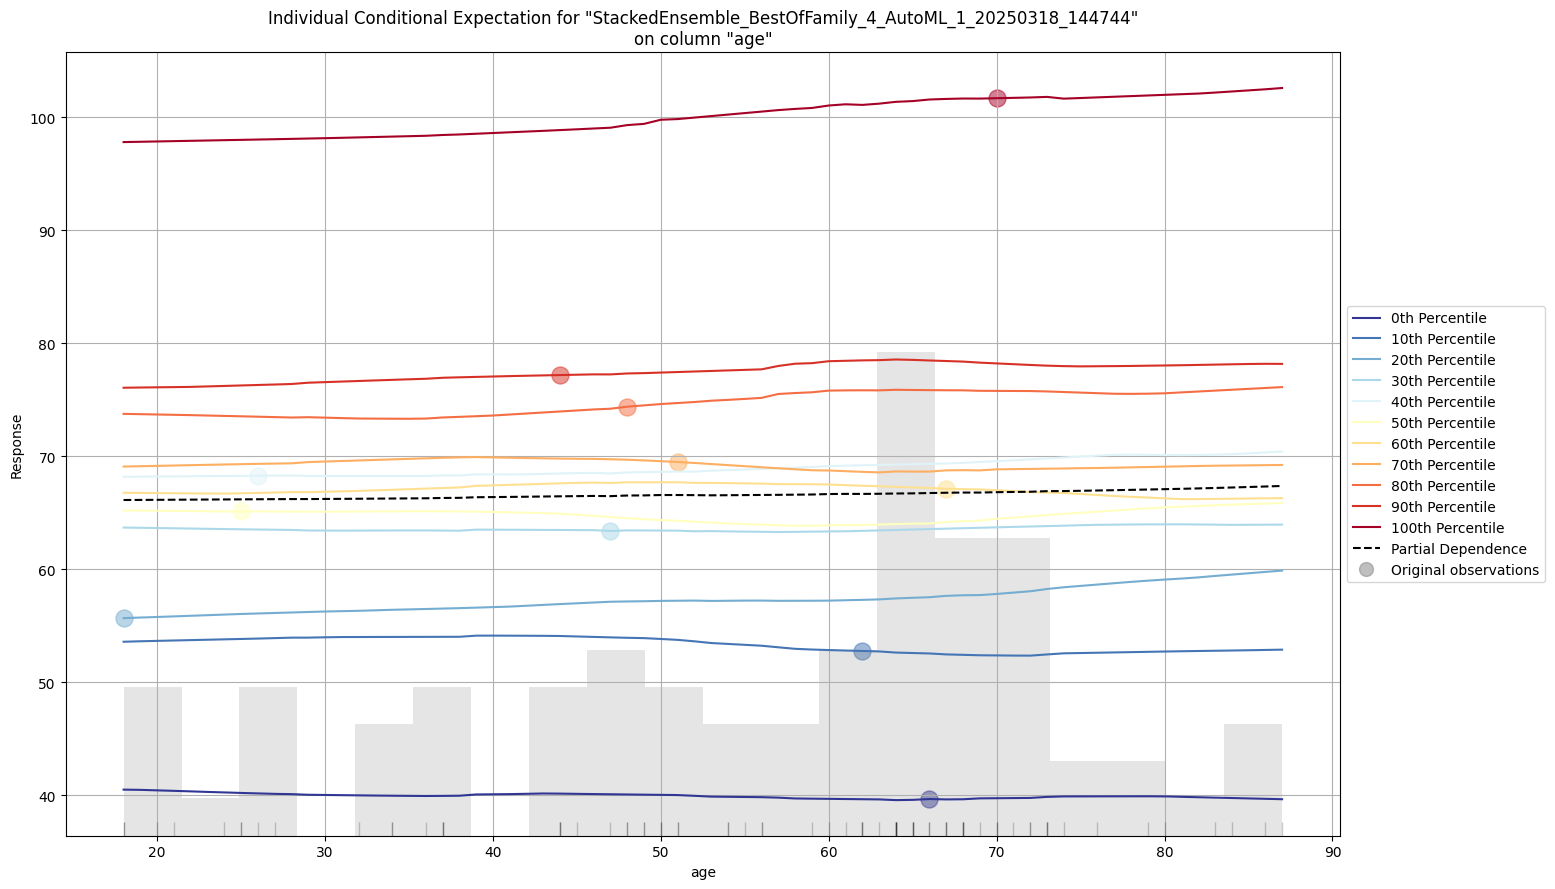

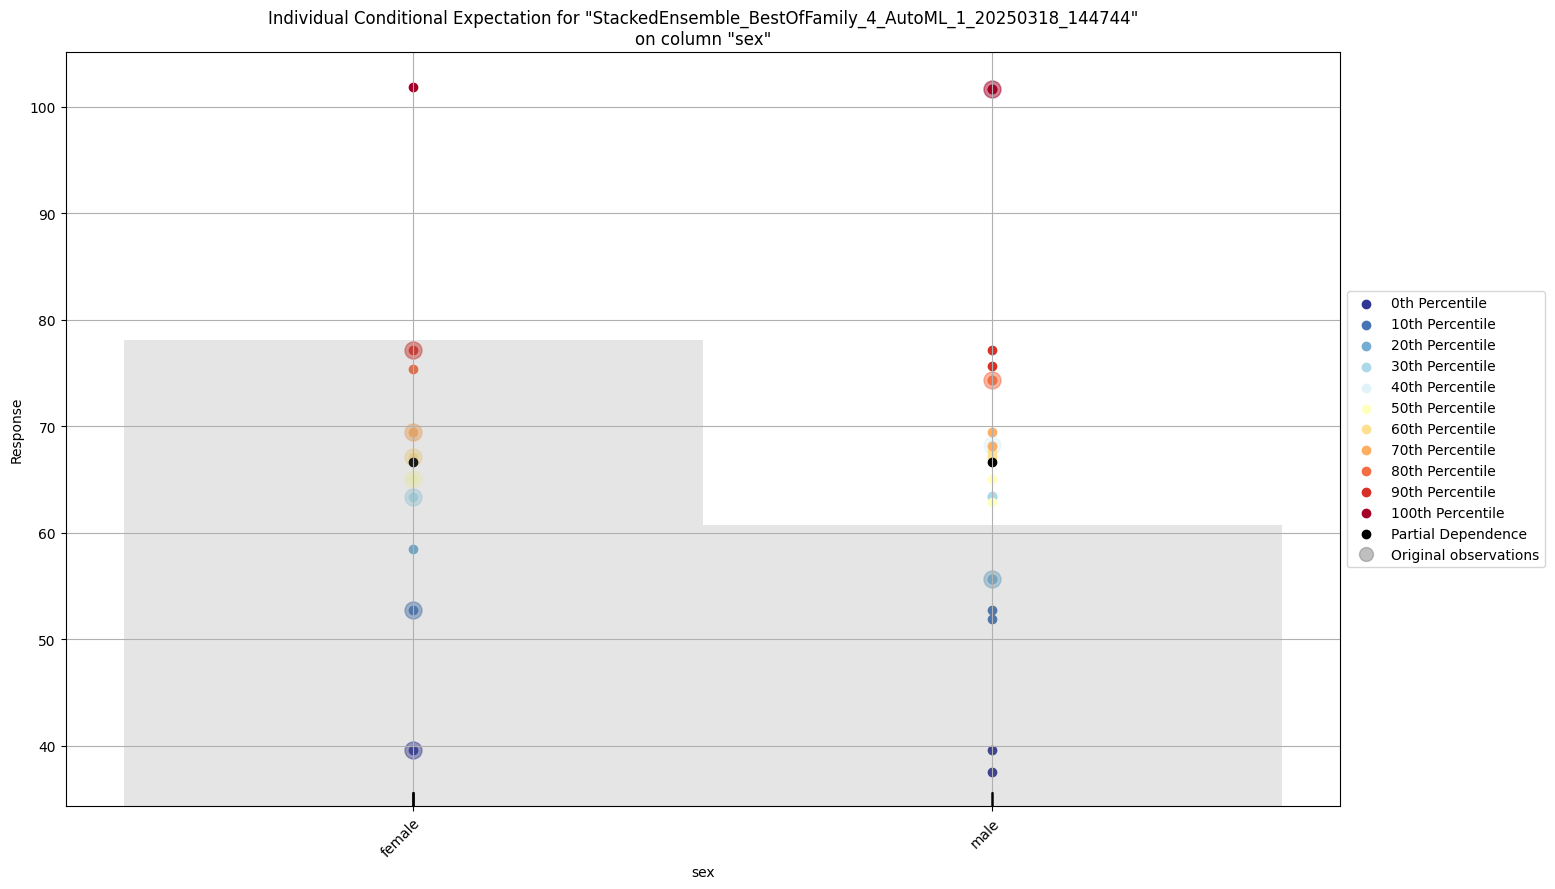

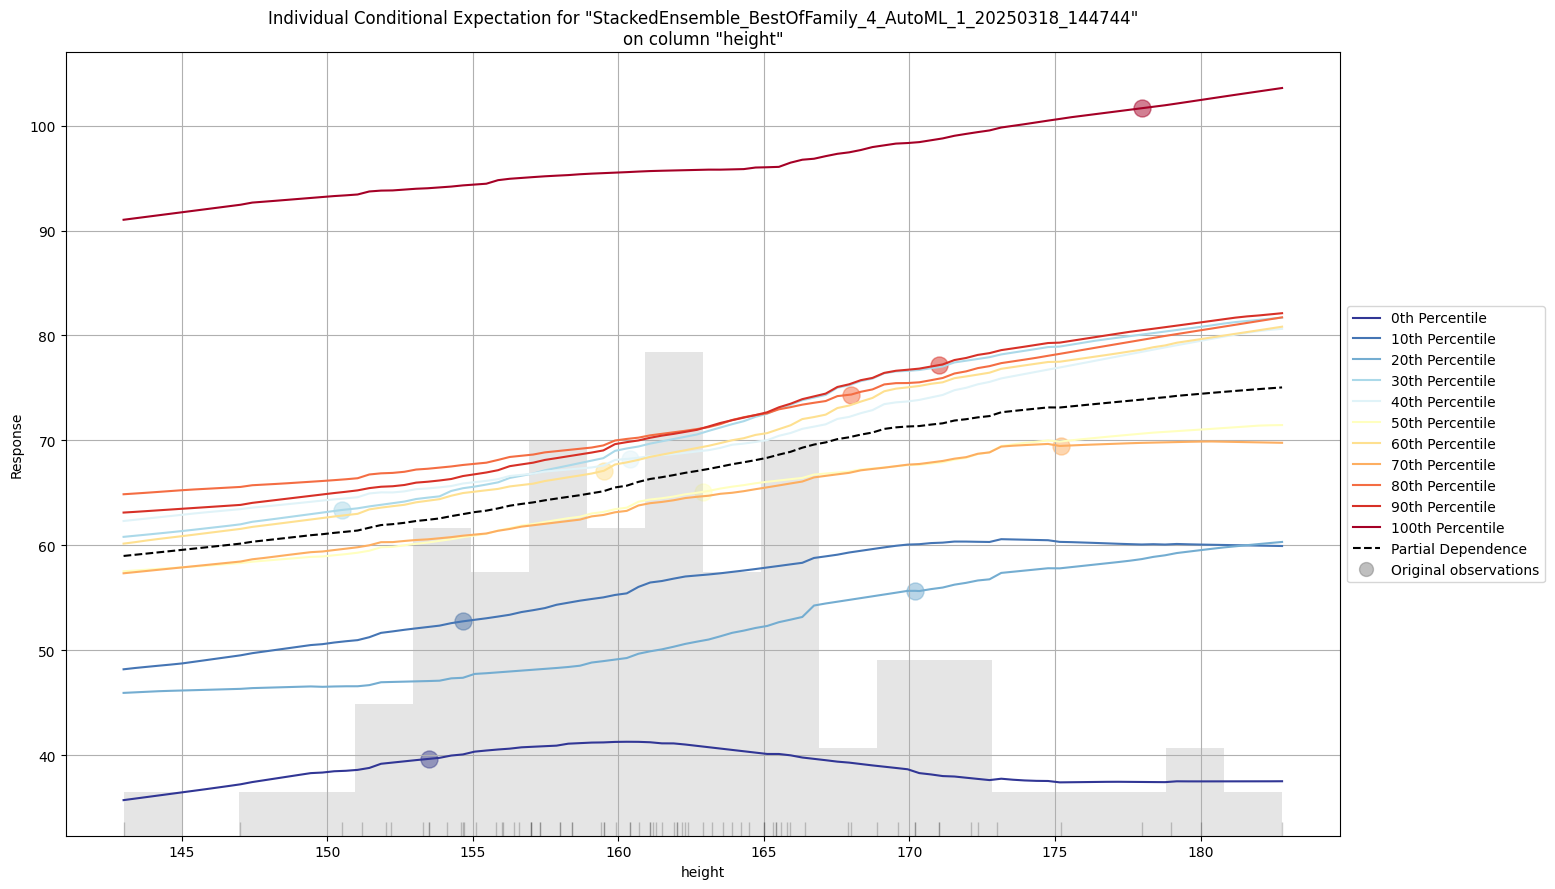

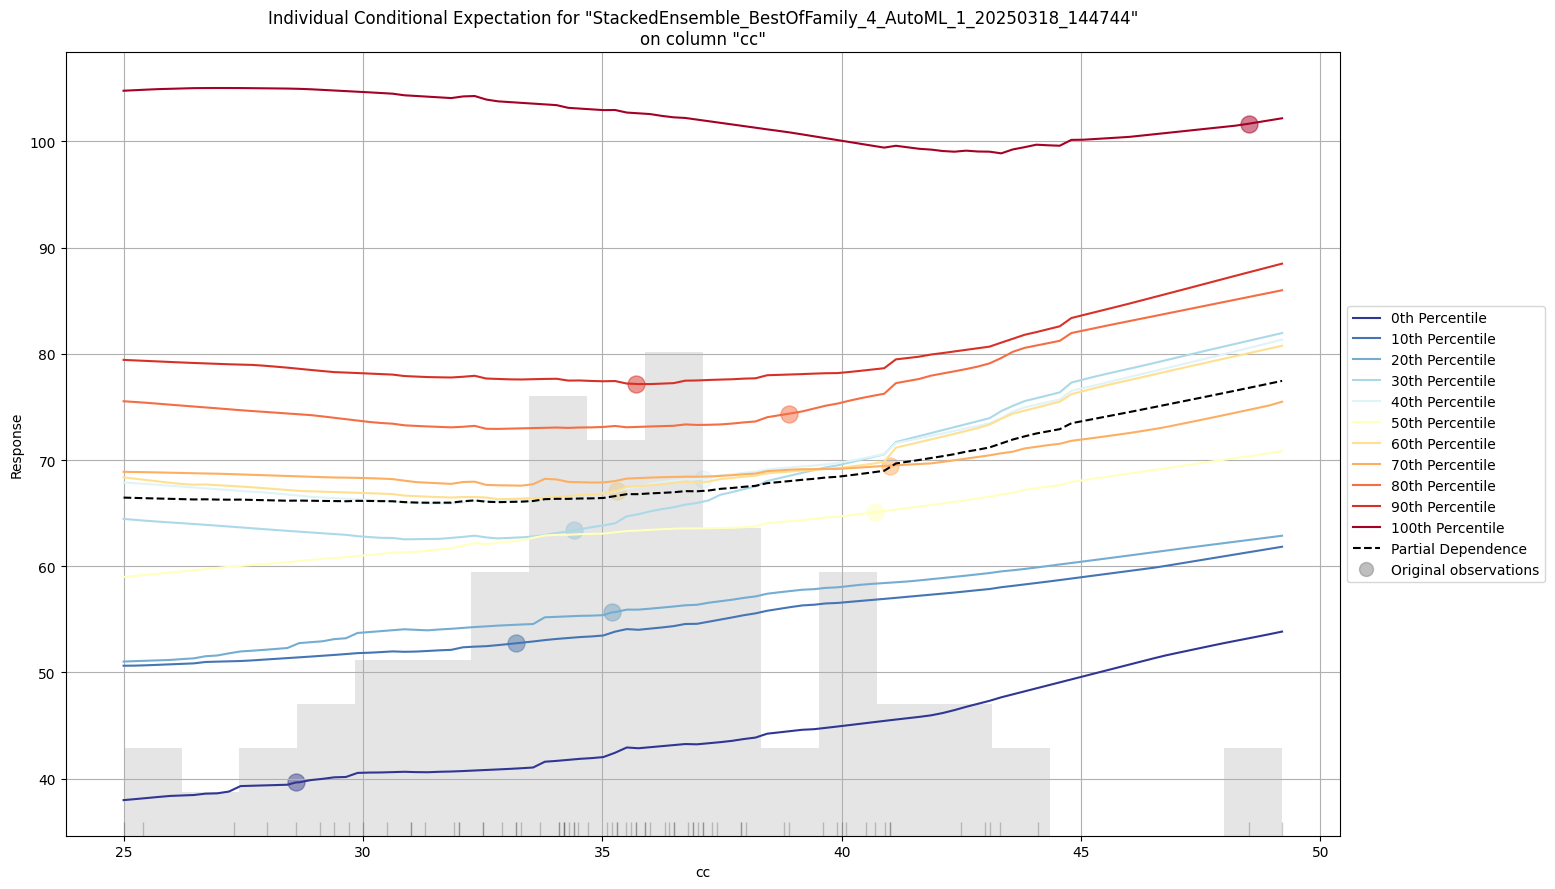

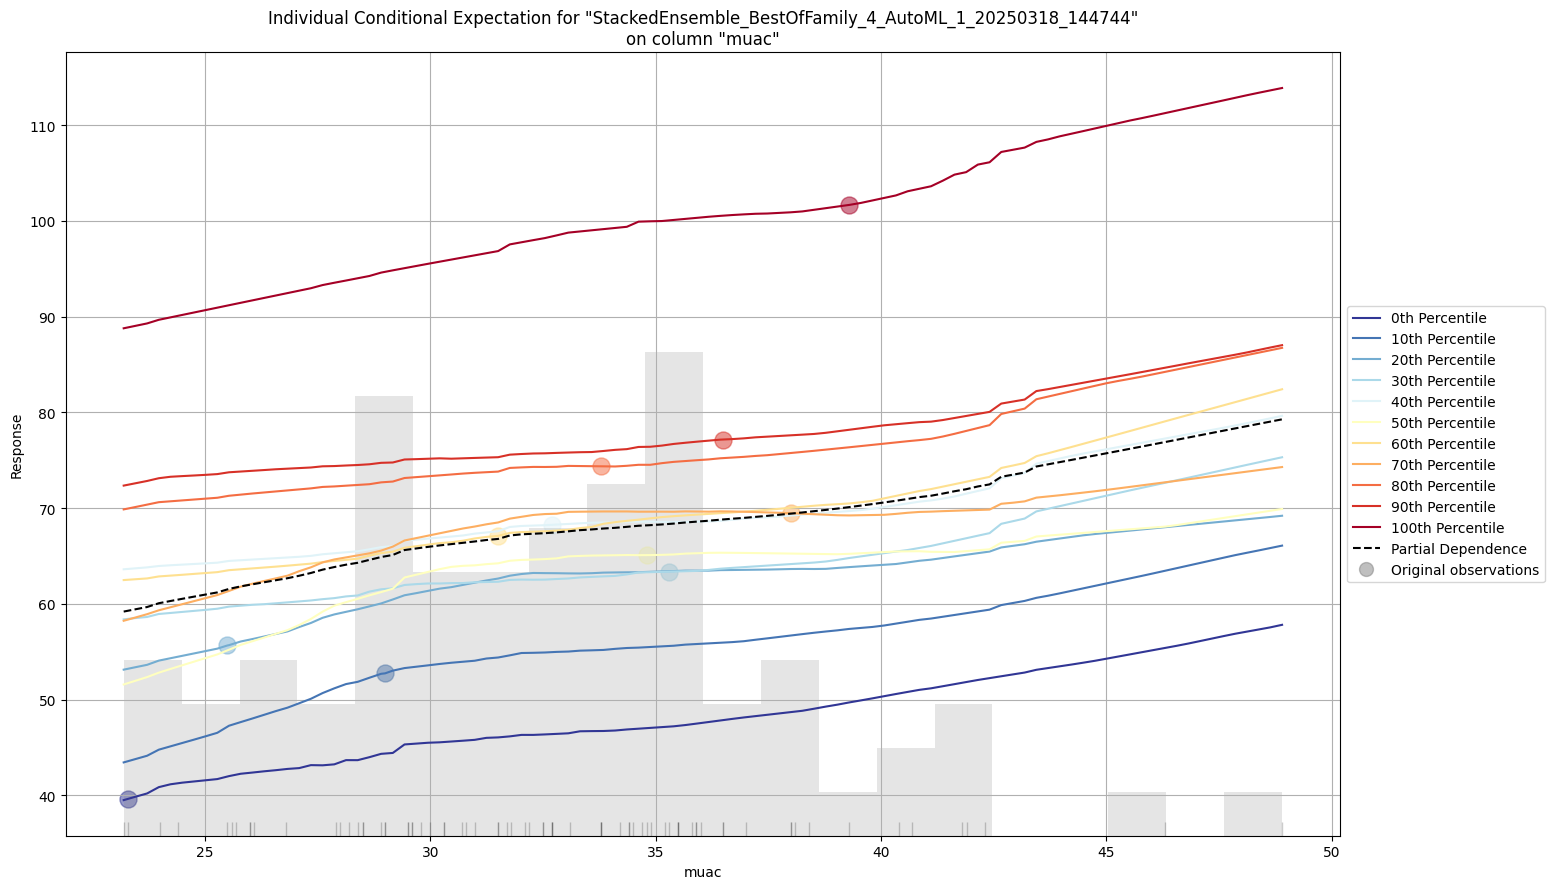

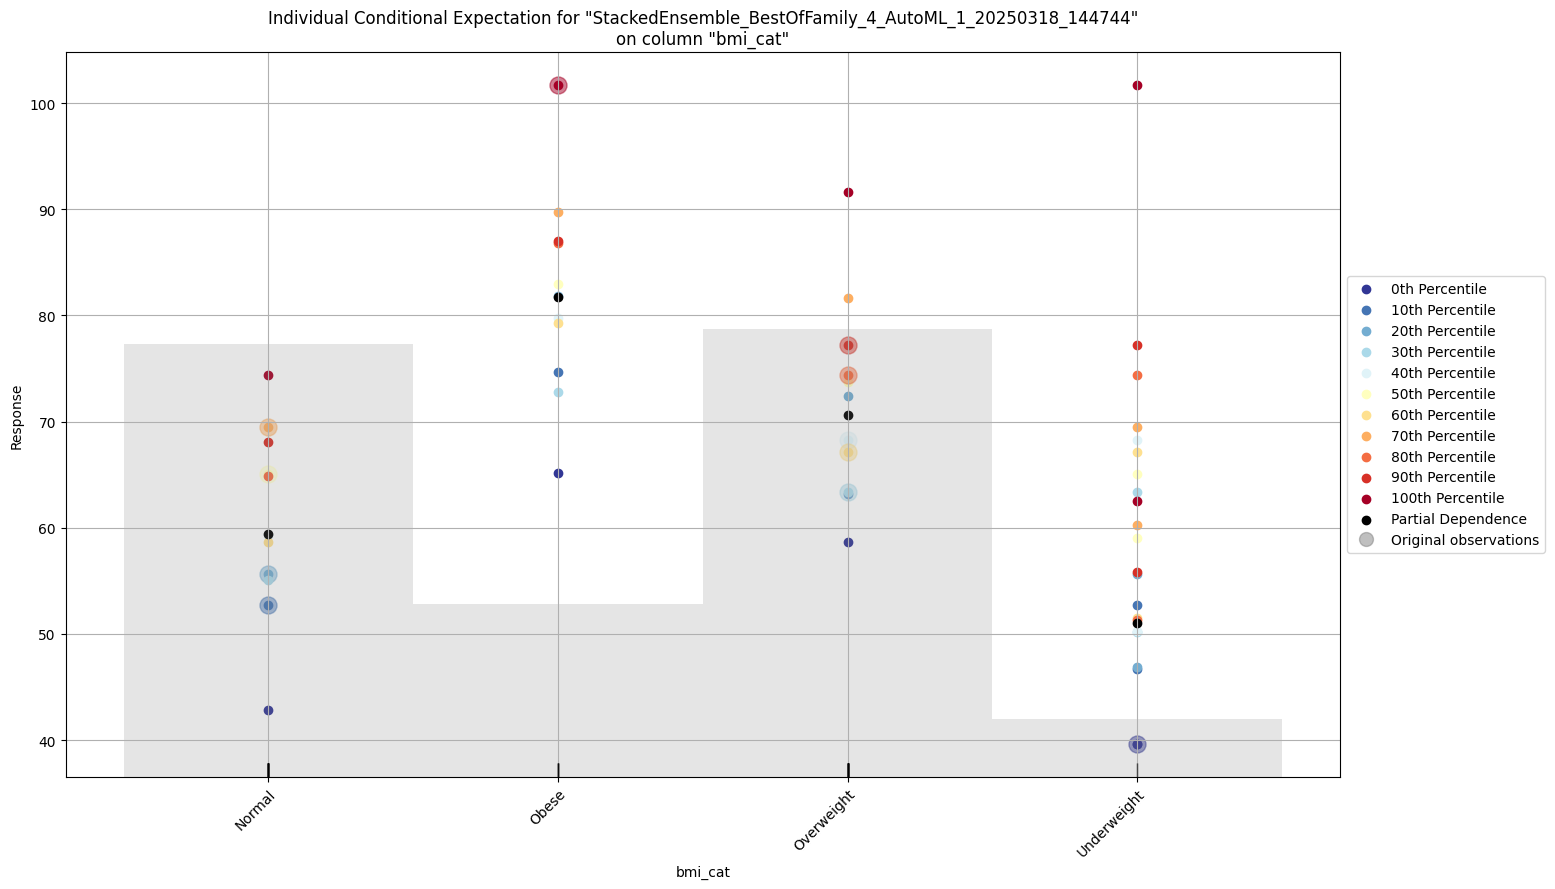

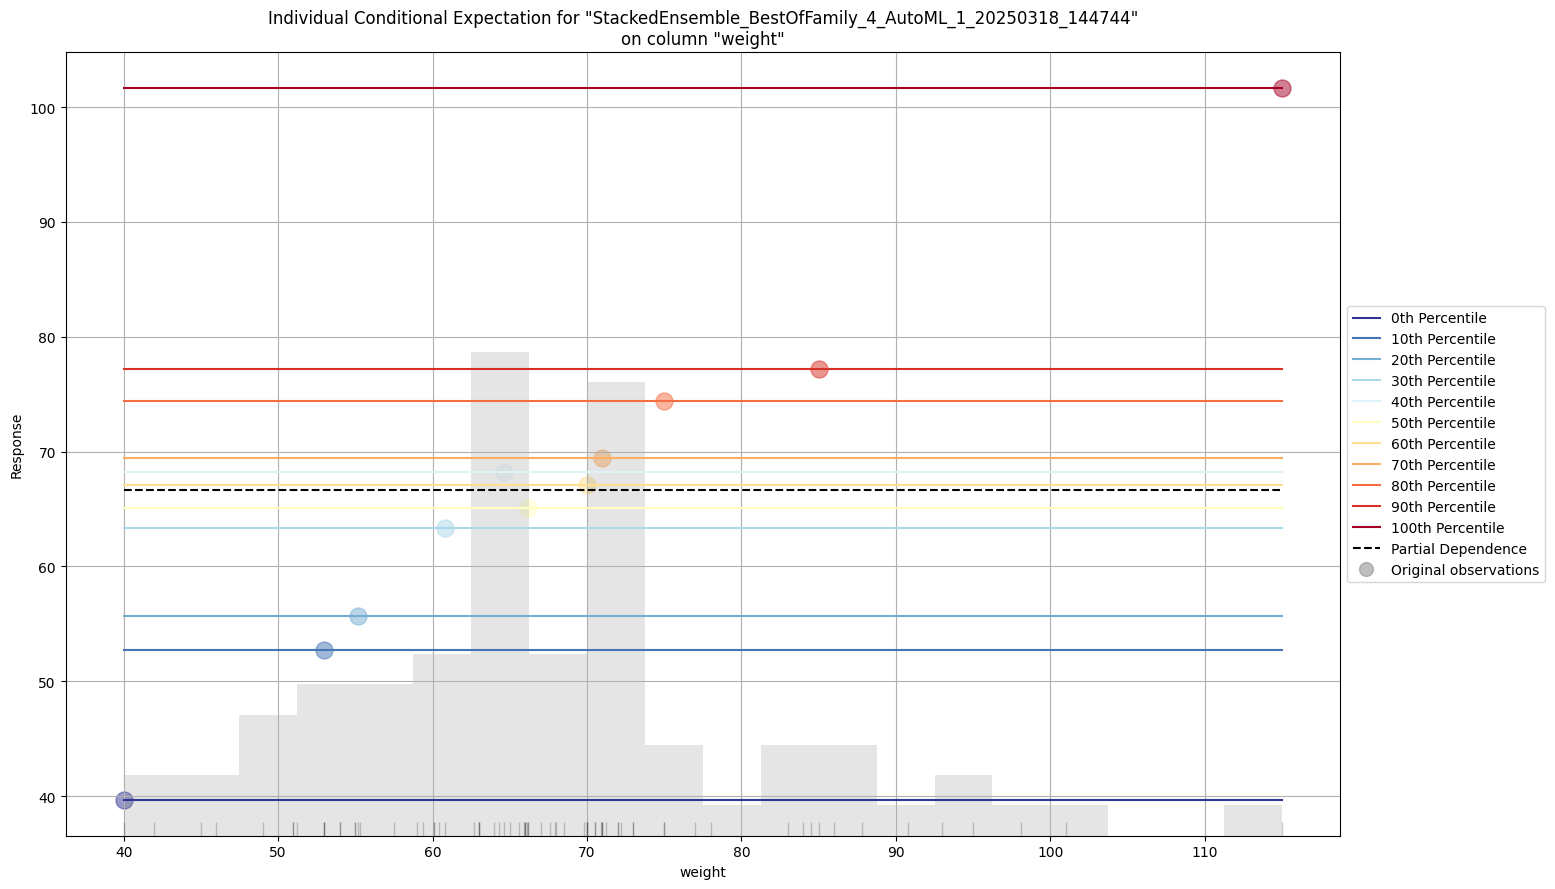

In [28]:
# Explain leader model & compare with all AutoML models
exa = model_full.explain(test, columns=features)

# Explain a single H2O model (e.g. leader model from AutoML)
exm = model_full.leader.explain(test, columns=features)

In [19]:
model_full.leaderboard.head()

model_id                                                             rmse      mse      mae      rmsle    mean_residual_deviance
----------------------------------------------------------------  -------  -------  -------  ---------  ------------------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20250318_112101           4.37248  19.1186  3.20905  0.0665917                   19.1186
StackedEnsemble_AllModels_6_AutoML_1_20250318_112101              4.44329  19.7428  3.23165  0.0670282                   19.7428
DeepLearning_grid_1_AutoML_1_20250318_112101_model_1              4.46071  19.898   3.28316  0.0679812                   19.898
StackedEnsemble_BestOfFamily_6_AutoML_1_20250318_112101           4.4927   20.1843  3.26983  0.0669415                   20.1843
GBM_lr_annealing_selection_AutoML_1_20250318_112101_select_model  4.71553  22.2363  3.3566   0.0712469                   22.2363
GBM_grid_1_AutoML_1_20250318_112101_model_170                     4.73577  22.4275  3.32386  0.0709102                   22.4275
GBM_grid_1_AutoML_1_20250318_112101_model_42                      4.7386   22.4543  3.40016  0.0713492                   22.4543
GBM_grid_1_AutoML_1_20250318_112101_model_172                     4.74017  22.4692  3.35129  0.0706266                   22.4692
StackedEnsemble_AllModels_3_AutoML_1_20250318_112101              4.74335  22.4994  3.37239  0.0723245                   22.4994
StackedEnsemble_AllModels_4_AutoML_1_20250318_112101              4.74368  22.5025  3.39123  0.0723918                   22.5025
[10 rows x 6 columns]

In [20]:
# Save full model
h2o.save_model(model_full.leader,  path="muac_model", force=True)

'/content/muac_model/StackedEnsemble_BestOfFamily_4_AutoML_1_20250318_112101'

## MUAC model

In [23]:
# Convert dataframe to H2O frame
df_muac = h2o.H2OFrame(df_muac)

# Split into train & test
splits = df_muac.split_frame(ratios = [0.8], seed = 1)
train_muac = splits[0]
test_muac = splits[1]

In [24]:
model_muac = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_muac")
model_muac.train(y=y, training_frame=train_muac)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_2_20250318_113646


GLM Model: summary
    family    link      regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    gaussian  identity  Ridge ( lambda = 0.007251 )  nlambda = 30, lambda.max = 1078.5, lambda.min = 0.007251, lambda.1se = 0.2035  4                             4                              26                      AutoML_2_20250318_113646_training_py_57_sid_8ade

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 67.3699319274469
RMSE: 8.20791885482836
MAE: 6.306322629151613
RMSLE: 0.12366582129290137
Mean Residual Deviance: 67.3699319274469
R^2: 0.6354692456336678
Null degrees of freedom: 311
Residual degrees of freedom: 307
Null deviance: 57661.578644860085
Residual deviance: 21019.41876136343
AIC: 2210.999671737375

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 68.93128664012083
RMSE: 8.302486774462265
MAE: 6.394405626278405
RMSLE: 0.12493402931086632
Mean Residual Deviance: 68.93128664012083
R^2: 0.6270209394685908
Null degrees of freedom: 311
Residual degrees of freedom: 307
Null deviance: 57734.601580097966
Residual deviance: 21506.5614317177
AIC: 2218.148015456545

Cross-Validation Metrics Summary: 
                        mean      sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ----------  ------------  ------------  ------------  ------------  ------------
aic                     451.419   13.3528     445.623       452.469       472.812       449.511       436.681
loglikelihood           0         0           0             0             0             0             0
mae                     6.40937   0.435659    6.12613       6.53027       6.99753       6.5339        5.859
mean_residual_deviance  68.5846   17.7188     57.1131       63.6692       98.9453       67.9485       55.247
mse                     68.5846   17.7188     57.1131       63.6692       98.9453       67.9485       55.247
null_deviance           11546.9   3190.77     9595.14       10042.9       17151.9       9791.27       11153.4
r2                      0.624857  0.0461794   0.622166      0.600593      0.640603      0.568724      0.692202
residual_deviance       4276.4    1085.33     3598.12       4011.16       6134.61       4212.81       3425.32
rmse                    8.23193   1.01236     7.55732       7.9793        9.94712       8.24309       7.43284
rmsle                   0.124761  0.00863507  0.117664      0.121901      0.134408      0.133477      0.116354

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      deviance_xval       deviance_se         alpha    iterations    training_rmse     training_deviance    training_mae       training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  ------------------  ------------------  -------  ------------  ----------------  -------------------  -----------------  ------------------
     2025-03-18 11:36:49  0.000 sec   1            .11E4     5             184.5954677743758   185.0618488290937   23.303773350443482  0.0
     2025-03-18 11:36:49  0.000 sec   2            .67E3     5             184.46316487319658  184.95629950435497  23.290796490484748  0.0
     2025-03-18 11:36:49  0.001 sec   3            .42E3     5             184.25059438270713  184.78663903635766  23.269937688573457  0.0
     2025-03-18 11:36:49  0.001 sec   4            .26E3   

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                  rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-----------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_2_20250318_113646_model_29           8.94908  80.086   6.78661  0.121784                   80.086                   51                   0.013576  GBM
GBM_grid_1_AutoML_2_20250318_113646_model_2            8.97837  80.6111  6.80388  0.122794                   80.6111                  38                   0.014782  GBM
DeepLearning_grid_2_AutoML_2_20250318_113646_model_2   9.00024  81.0044  6.83398  0.122791                   81.0044                  87                   0.012908  DeepLearning
StackedEnsemble_Best1000_1_AutoML_2_20250318_113646    9.03345  81.6032  6.93042  0.124052                   81.6032                 389                   0.264077  StackedEnsemble
DeepLearning_grid_1_AutoML_2_20250318_113646_model_15  9.049    81.8844  6.92169  0.125004                   81.8844                  55                   0.007374  DeepLearning
DeepLearning_grid_1_AutoML_2_20250318_113646_model_6   9.06166  82.1137  6.90587  0.125016                   82.1137                  40                   0.007749  DeepLearning
StackedEnsemble_AllModels_3_AutoML_2_20250318_113646   9.07811  82.412   6.98278  0.124298                   82.412                  245                   0.185661  StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_2_20250318_113646   9.08191  82.4811  6.98566  0.124328                   82.4811                 373                   0.190138  StackedEnsemble
DeepLearning_grid_2_AutoML_2_20250318_113646_model_9   9.08727  82.5785  7.01115  0.123564                   82.5785                 233                   0.034133  DeepLearning
DeepLearning_grid_3_AutoML_2_20250318_113646_model_3   9.1009   82.8263  6.9452   0.124315                   82.8263                  52                   0.006442  DeepLearning
GBM_grid_1_AutoML_2_20250318_113646_model_23           9.1107   83.0048  6.79043  0.123795                   83.0048                  44                   0.014925  GBM
GBM_grid_1_AutoML_2_20250318_113646_model_25           9.12502  83.266   6.89075  0.123066                   83.266                   44                   0.015291  GBM
XGBoost_grid_1_AutoML_2_20250318_113646_model_19       9.13198  83.3931  6.92511  0.124651                   83.3931                 310                   0.00796   XGBoost
GBM_grid_1_AutoML_2_20250318_113646_model_12           9.13632  83.4723  6.79941  0.124155                   83.4723                  43                   0.014808  GBM
StackedEnsemble_AllModels_6_AutoML_2_20250318_113646   9.1411   83.5597  7.07191  0.125284                   83.5597                1852                   0.174642  StackedEnsemble
XGBoost_1_AutoML_2_20250318_113646                     9.17402  84.1627  7.14939  0.127892                   84.1627                 337                   0.009619  XGBoost
XGBoost_grid_1_AutoML_2_20250318_113646_model_9        9.23538  85.2922  7.04535  0.12935                    85.2922                 744                   0.006997  XGBoost
XGBoost_grid_1_AutoML_2_20250318_113646_model_21       9.27386  86.0045  7.03495  0.125281                   86.0045                 827                   0.007642  XGBoost
DeepLearning_grid_1_AutoML_2_20250318_113646_model_7   9.28118  86.1404  6.98084  0.12749                    86.1404                  53                   0.007703  DeepLearning
StackedEnsemble_AllModels_2_AutoML_2_20250318_113646   9.29048  86.313   7.15817  0.127839                   86.313                  112                   0.062897  StackedEnsemble
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

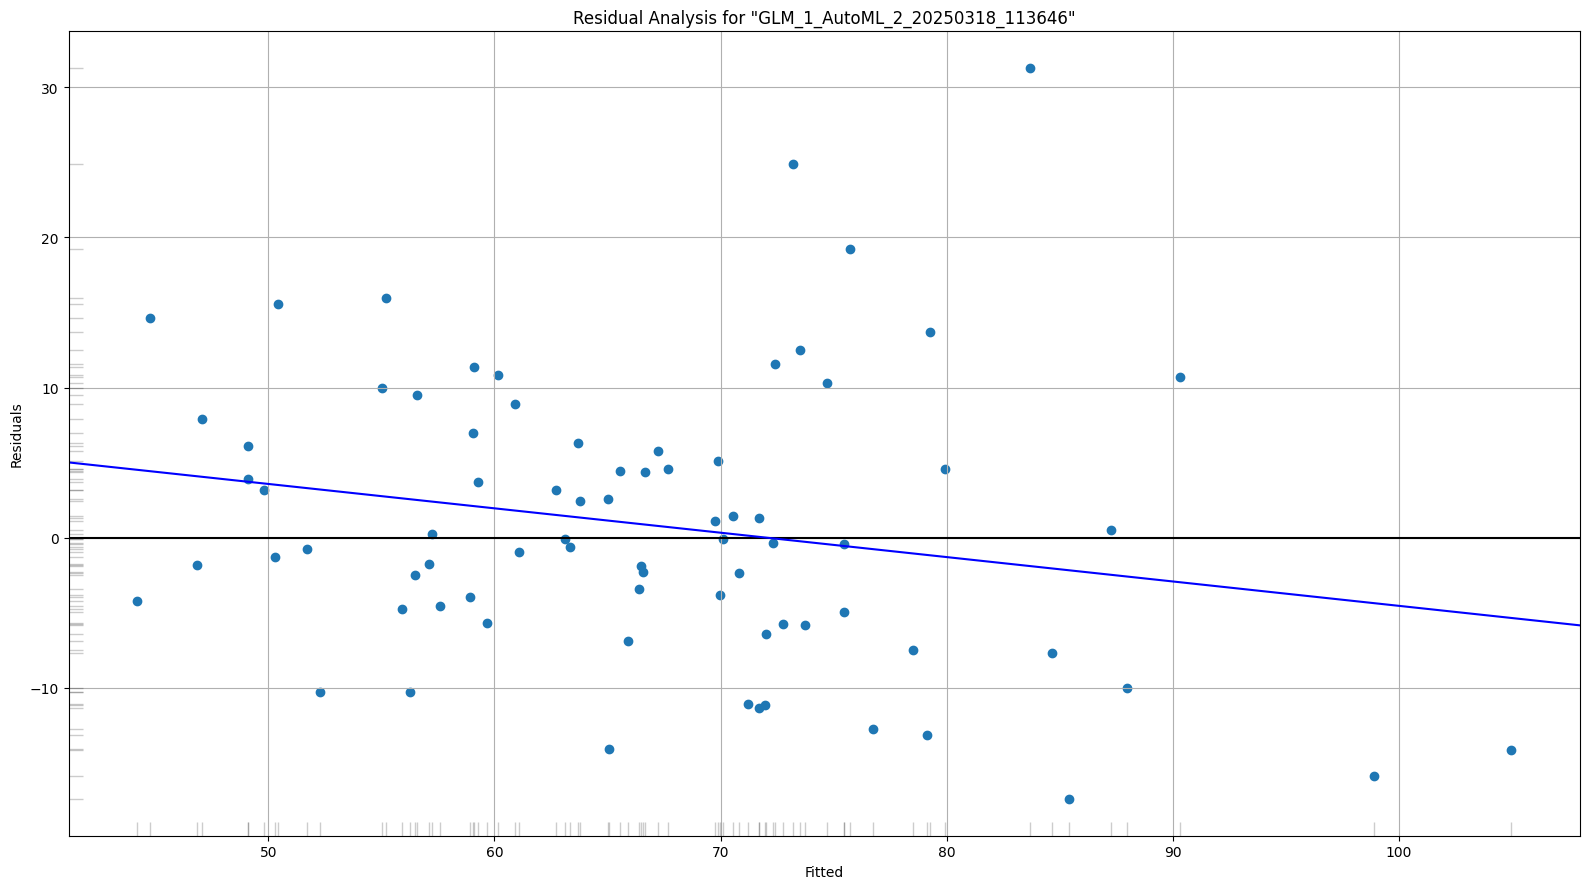

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

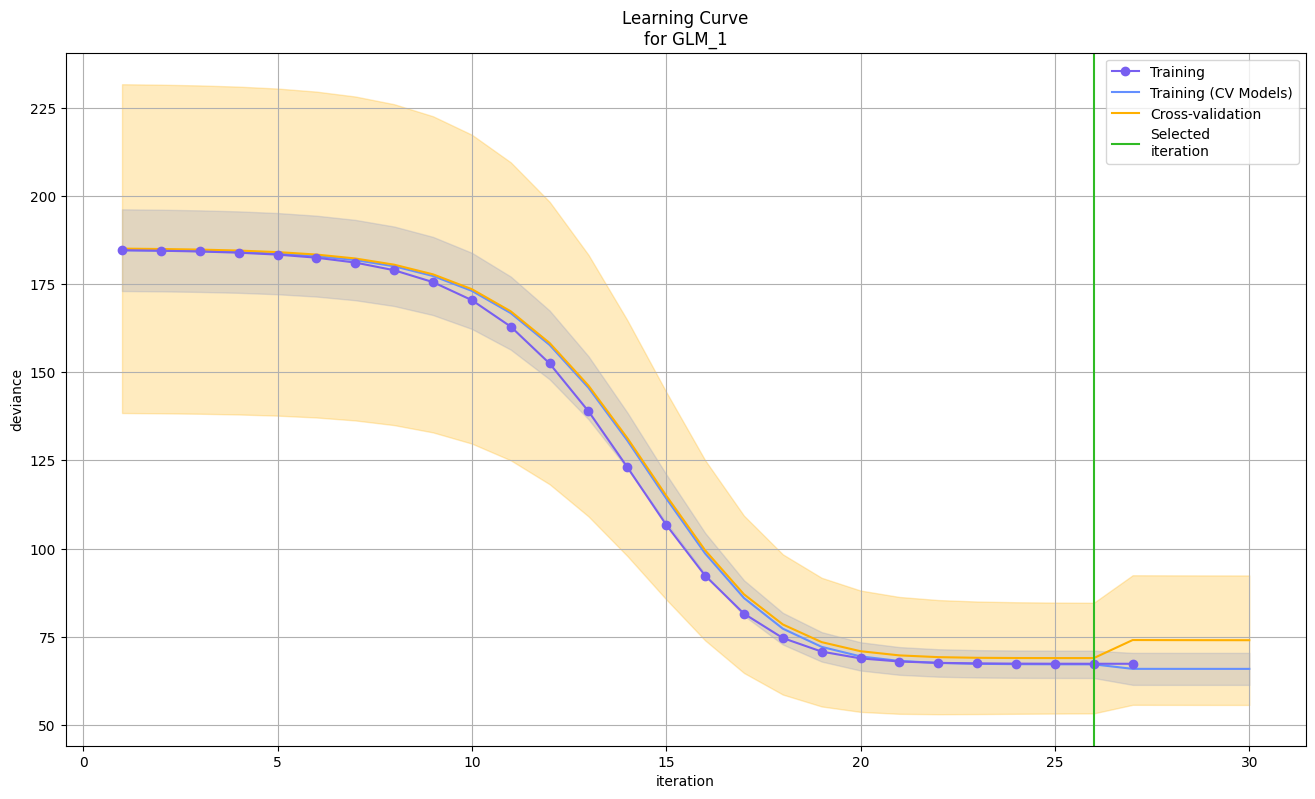

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

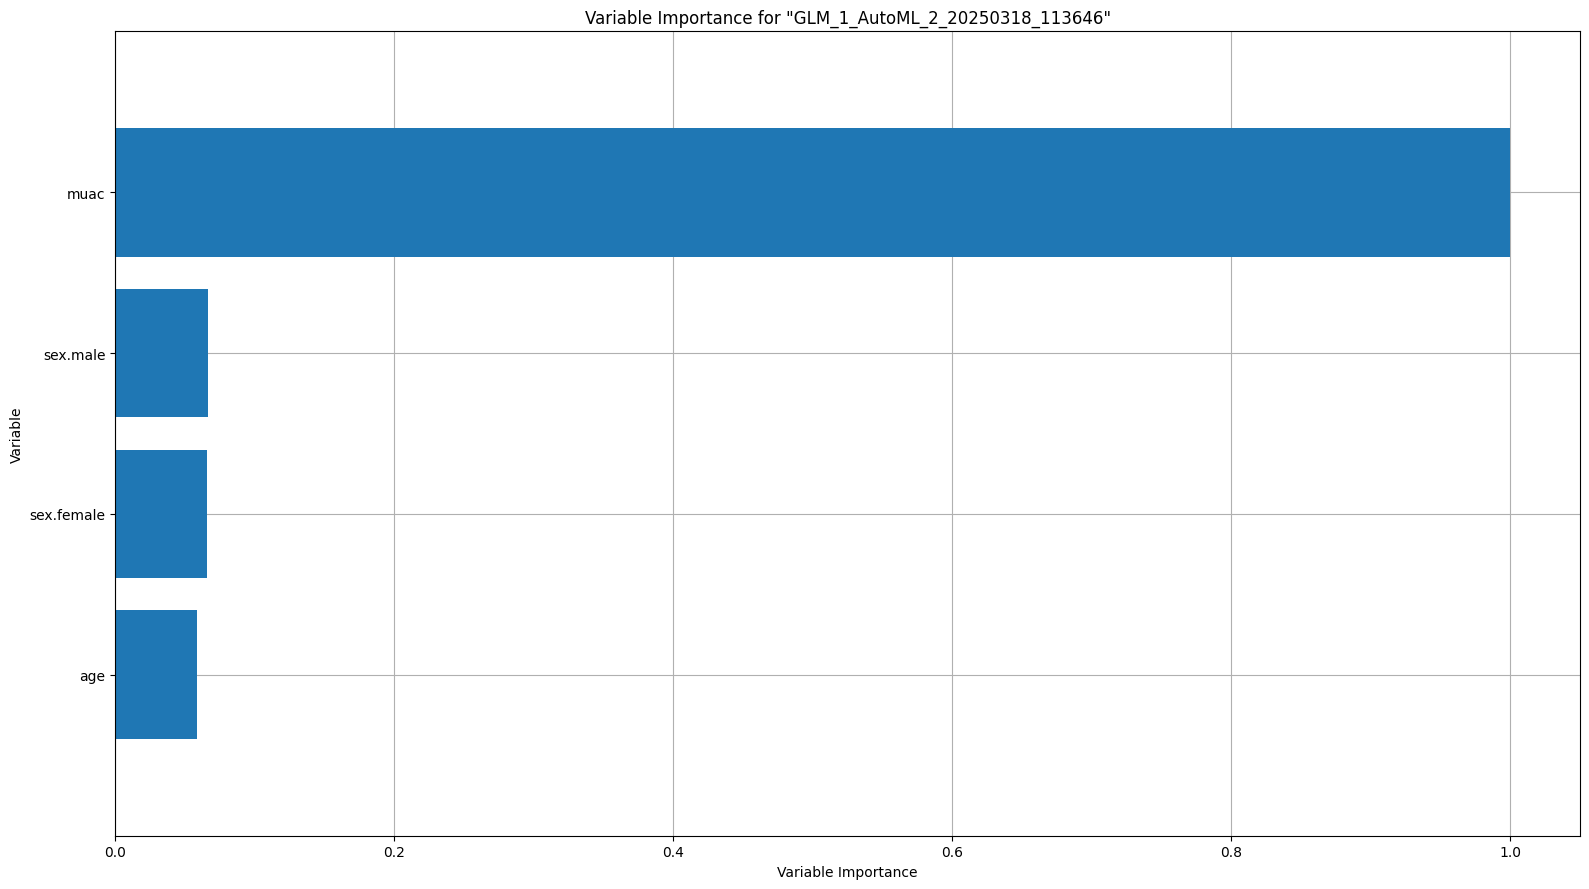

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

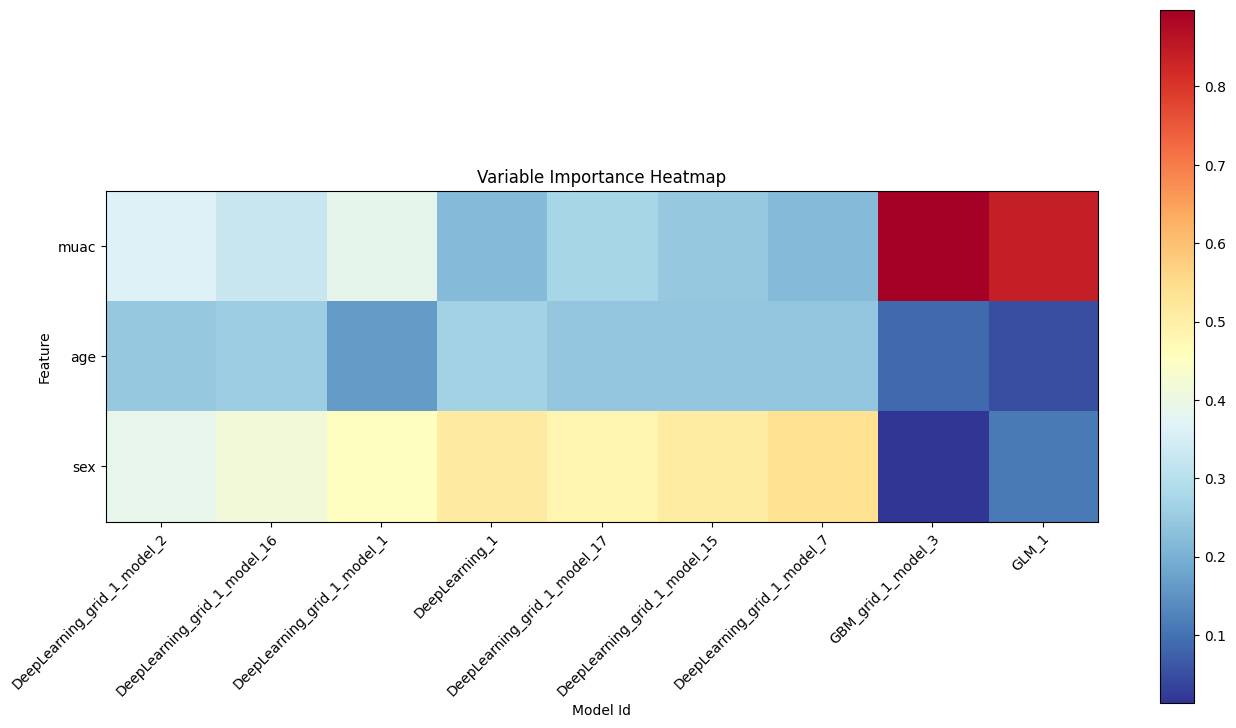

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

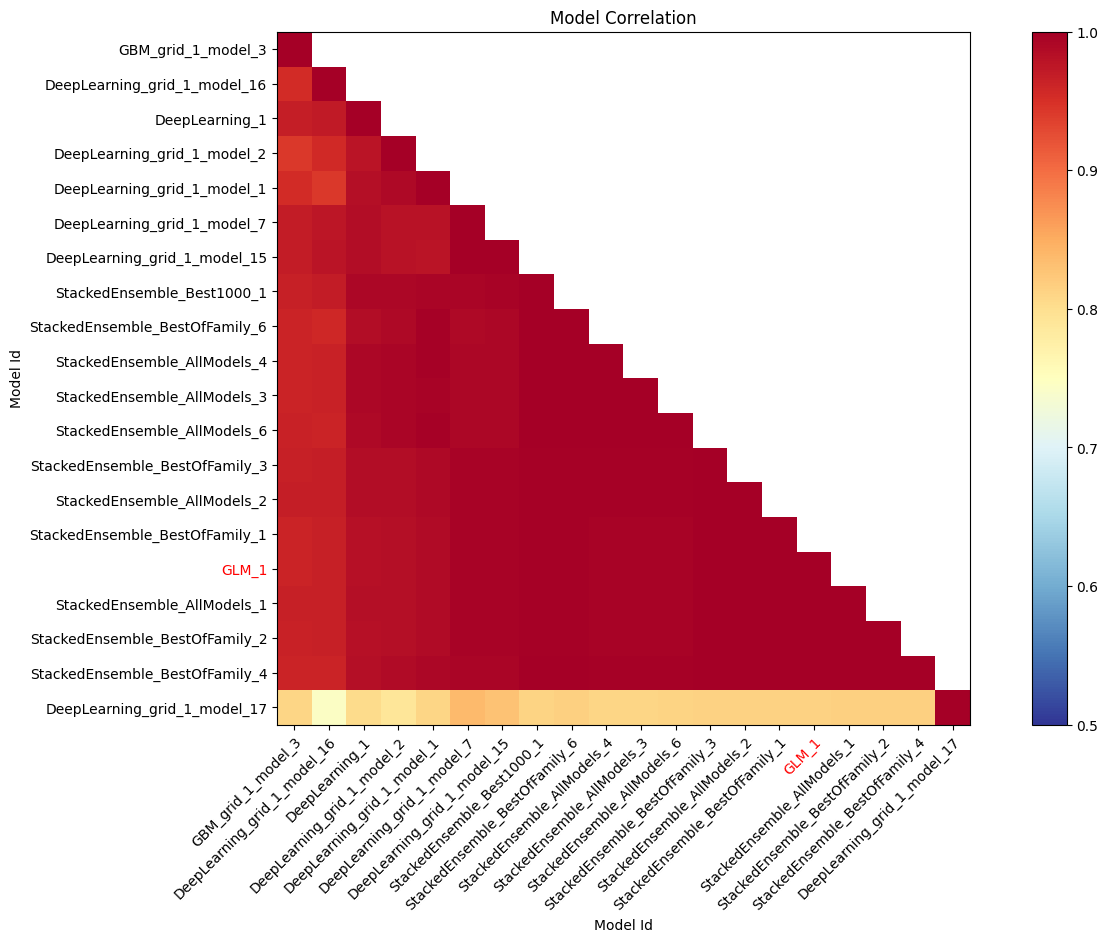

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Incorrect number of arguments; 'cols_py' expects 2 but was passed 3
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_97_sid_8ade (levels (tmp= py_96_sid_8ade (as.factor (cols_py py_95_sid_8ade np.str_('sex'))))))", 'session_id': '_sid_8ade'}


In [25]:
# Explain leader model & compare with all AutoML models
exa = model_muac.explain(test_muac)

# Explain a single H2O model (e.g. leader model from AutoML)
exm = model_muac.leader.explain(test_muac)

In [26]:
model_muac.leaderboard.head()

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
-------------------------------------------------------  -------  -------  -------  --------  ------------------------
GLM_1_AutoML_2_20250318_113646                           8.30249  68.9313  6.39441  0.124934                   68.9313
StackedEnsemble_AllModels_6_AutoML_2_20250318_113646     8.30711  69.008   6.37374  0.124237                   69.008
DeepLearning_grid_1_AutoML_2_20250318_113646_model_1     8.33428  69.4603  6.43101  0.124531                   69.4603
StackedEnsemble_BestOfFamily_4_AutoML_2_20250318_113646  8.33539  69.4788  6.3714   0.125025                   69.4788
StackedEnsemble_BestOfFamily_2_AutoML_2_20250318_113646  8.35217  69.7587  6.41945  0.125504                   69.7587
StackedEnsemble_BestOfFamily_1_AutoML_2_20250318_113646  8.39565  70.4869  6.4539   0.126322                   70.4869
StackedEnsemble_BestOfFamily_6_AutoML_2_20250318_113646  8.40806  70.6955  6.42951  0.125742                   70.6955
StackedEnsemble_AllModels_2_AutoML_2_20250318_113646     8.4166   70.8392  6.46075  0.125704                   70.8392
StackedEnsemble_AllModels_1_AutoML_2_20250318_113646     8.43701  71.1831  6.49579  0.126409                   71.1831
StackedEnsemble_BestOfFamily_3_AutoML_2_20250318_113646  8.46362  71.6328  6.5008   0.126744                   71.6328
[10 rows x 6 columns]

In [27]:
# Save muac model
h2o.save_model(model_muac.leader,  path="muac_model", force=True)

'/content/muac_model/GLM_1_AutoML_2_20250318_113646'

## CC Model

In [28]:
# Convert dataframe to H2O frame
df_cc = h2o.H2OFrame(df_cc)

# Split into train & test
splits = df_cc.split_frame(ratios = [0.8], seed = 1)
train_cc = splits[0]
test_cc = splits[1]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [29]:
model_cc = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_cc")
model_cc.train(y=y, training_frame=train_cc)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_3_20250318_115436


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  3/8
# GBM base models (used / total)      1/4
# XGBoost base models (used / total)  1/2
# GLM base models (used / total)      1/1
# DRF base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 52.49607175006966
RMSE: 7.245417293025272
MAE: 5.446283430752676
RMSLE: 0.11153966225583327
Mean Residual Deviance: 52.49607175006966
R^2: 0.715949948458747
Null degrees of freedom: 311
Residual degrees of freedom: 308
Null deviance: 57661.578644860085
Residual deviance: 16378.774386021734
AIC: 2131.1680077325773

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 70.94415745827605
RMSE: 8.422835476149112
MAE: 6.33113665584633
RMSLE: 0.12939138928962624
Mean Residual Deviance: 70.94415745827605
R^2: 0.6161295329198333
Null degrees of freedom: 311
Residual degrees of freedom: 308
Null deviance: 58341.683791198186
Residual deviance: 22134.577126982127
AIC: 2225.1282772258282

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     449.96    39.4015    458.373       504.113       463.485       419.934       403.894
loglikelihood           0         0          0             0             0             0             0
mae                     6.32469   0.95195    7.05789       6.33581       7.02759       6.48025       4.72192
mean_residual_deviance  71.2578   25.7755    72.1788       61.6493       112.192       68.7137       41.555
mse                     71.2578   25.7755    72.1788       61.6493       112.192       68.7137       41.555
null_deviance           11668.3   3361.52    13469.4       13573.7       12941.7       12664.5       5692.44
r2                      0.599821  0.0913951  0.654223      0.658415      0.471681      0.679798      0.534989
residual_deviance       4426.92   1521.68    4547.27       4377.1        6731.52       3985.39       2493.3
rmse                    8.33506   1.49357    8.49581       7.8517        10.5921       8.28937       6.44632
rmsle                   0.128399  0.0159713  0.133168      0.132491      0.148723      0.122231      0.105383

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ---------------
DeepLearning_grid_2_AutoML_3_20250318_115436_model_9     8.41358  70.7883  6.4829   0.121299                   70.7883                 222                   0.022557  DeepLearning
GBM_grid_1_AutoML_3_20250318_115436_model_3              8.54348  72.9911  6.56463  0.121561                   72.9911                  49                   0.014673  GBM
DeepLearning_grid_2_AutoML_3_20250318_115436_model_2     8.569    73.4277  6.48186  0.120568                   73.4277                 150                   0.013792  DeepLearning
DeepLearning_grid_1_AutoML_3_20250318_115436_model_3     8.60908  74.1163  6.62298  0.121449                   74.1163                8571                   0.004515  DeepLearning
DeepLearning_grid_2_AutoML_3_20250318_115436_model_4     8.61776  74.2657  6.66907  0.12713                    74.2657                  58                   0.041375  DeepLearning
DeepLearning_grid_3_AutoML_3_20250318_115436_model_1     8.69341  75.5753  6.79783  0.126344                   75.5753               11412                   0.041378  DeepLearning
DeepLearning_1_AutoML_3_20250318_115436                  8.72044  76.046   6.65226  0.121869                   76.046                   32                   0.005669  DeepLearning
DeepLearning_grid_2_AutoML_3_20250318_115436_model_1     8.75305  76.6159  6.72586  0.124023                   76.6159               11392                   0.034732  DeepLearning
DeepLearning_grid_3_AutoML_3_20250318_115436_model_3     8.78836  77.2353  6.55559  0.124462                   77.2353                  52                   0.006246  DeepLearning
StackedEnsemble_BestOfFamily_1_AutoML_3_20250318_115436  8.80121  77.4614  6.68302  0.131942                   77.4614                 111                   0.038663  StackedEnsemble
XGBoost_grid_1_AutoML_3_20250318_115436_model_16         8.82615  77.9009  6.91818  0.129007                   77.9009                 633                   0.008351  XGBoost
DeepLearning_grid_2_AutoML_3_20250318_115436_model_3     8.83672  78.0876  6.73095  0.126554                   78.0876                  37                   0.007331  DeepLearning
StackedEnsemble_BestOfFamily_6_AutoML_3_20250318_115436  8.86886  78.6567  6.89944  0.131304                   78.6567                 418                   0.05205   StackedEnsemble
XGBoost_grid_1_AutoML_3_20250318_115436_model_15         8.87557  78.7757  6.61945  0.12514                    78.7757                 573                   0.008282  XGBoost
StackedEnsemble_BestOfFamily_2_AutoML_3_20250318_115436  8.87782  78.8156  6.8521   0.133539                   78.8156                 111                   0.037332  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_3_20250318_115436     8.87782  78.8156  6.8521   0.133539                   78.8156                 110                   0.072763  StackedEnsemble
GLM_1_AutoML_3_20250318_115436                           8.88181  78.8866  6.69348  0.134042                   78.8866                  10                   0.003429  GLM
StackedEnsemble_Best1000_1_AutoML_3_20250318_115436      8.88924  79.0185  6.80565  0.129173                   79.0185                 259                   0.278707  StackedEnsemble
GBM_grid_1_AutoML_3_20250318_115436_model_2              8.91083  79.403   6.9798   0.13169                    79.403                   31                   0.011095  GBM
StackedEnsemble_AllModels_4_AutoML_3_20250318_115436     8.91959  79.5591  6.83457  0.130065                   79.5591                 280                   0.302444  StackedEnsemble
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

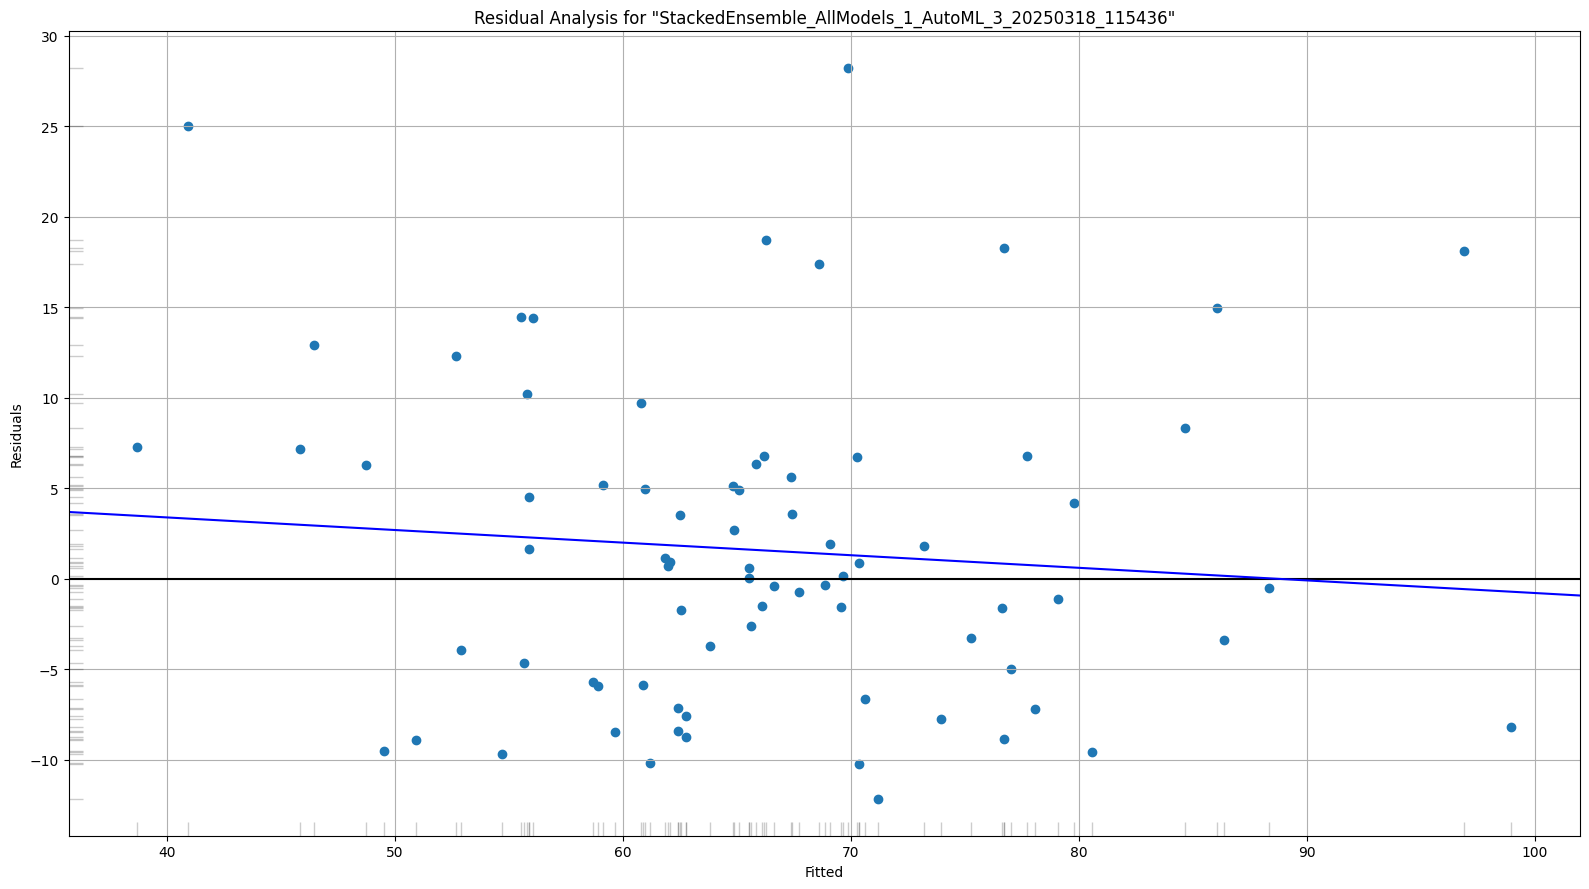

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

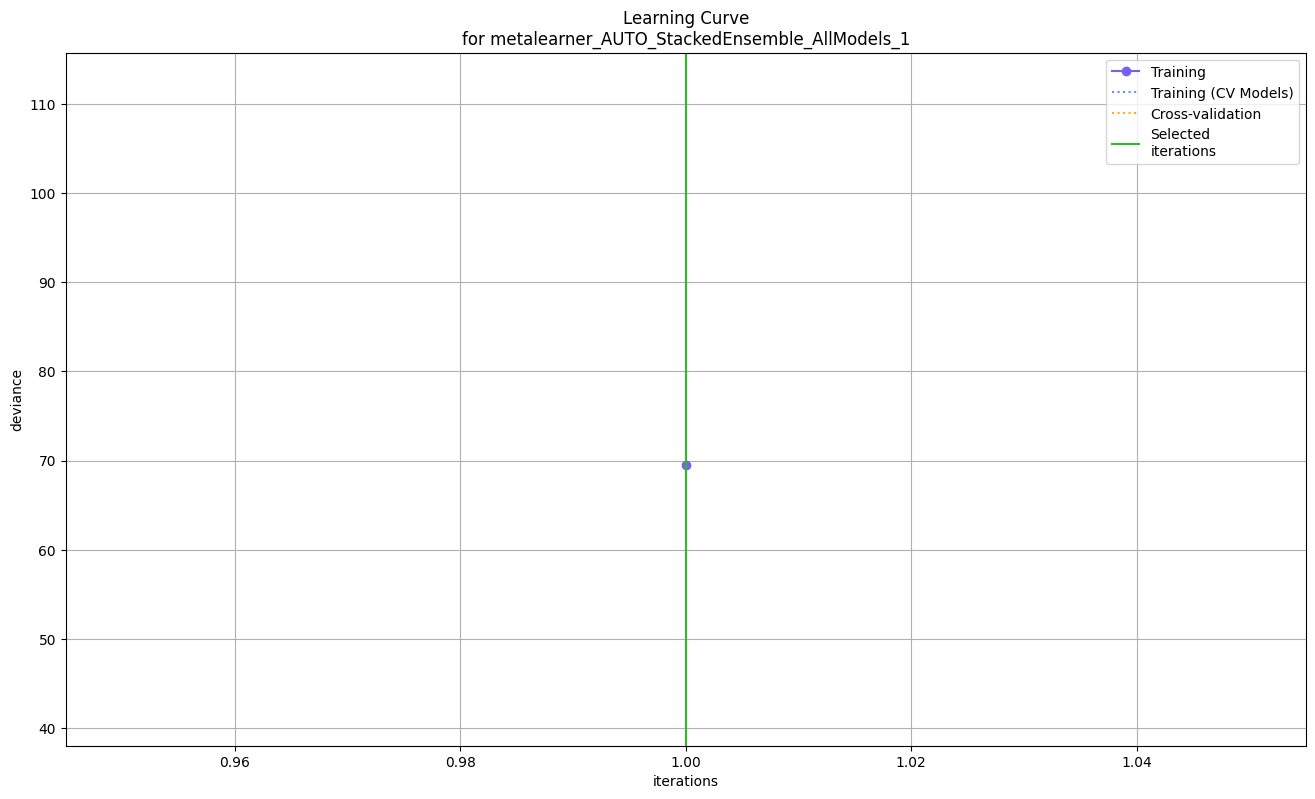

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

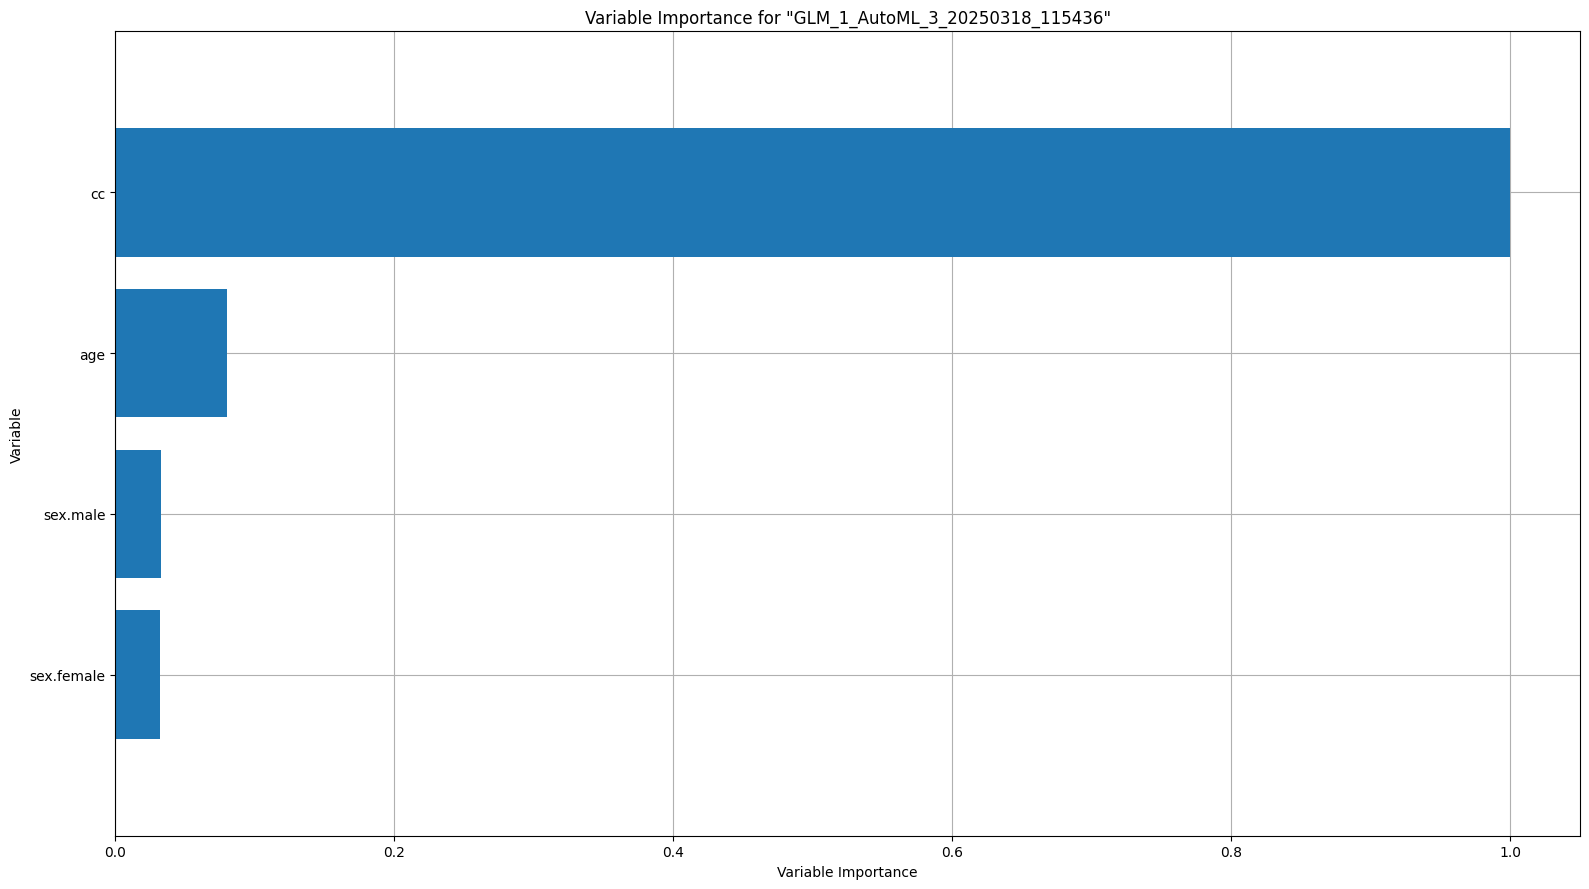

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

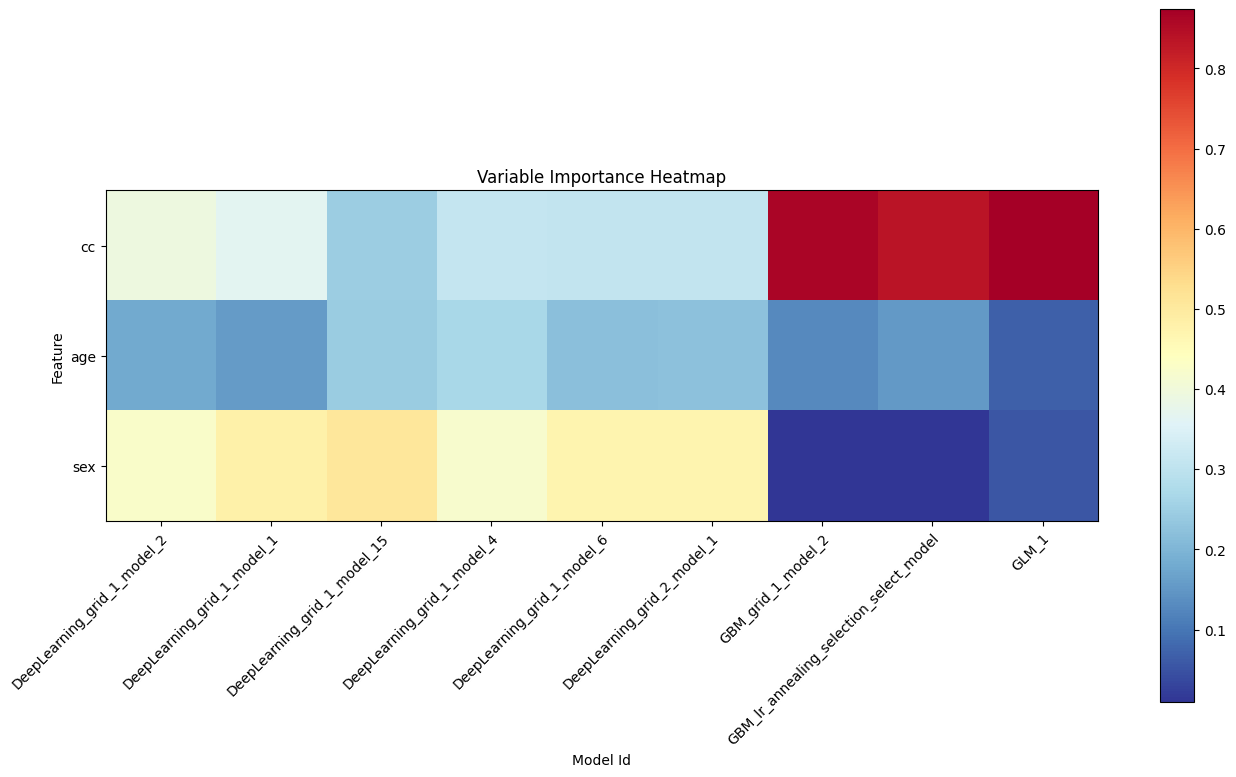

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

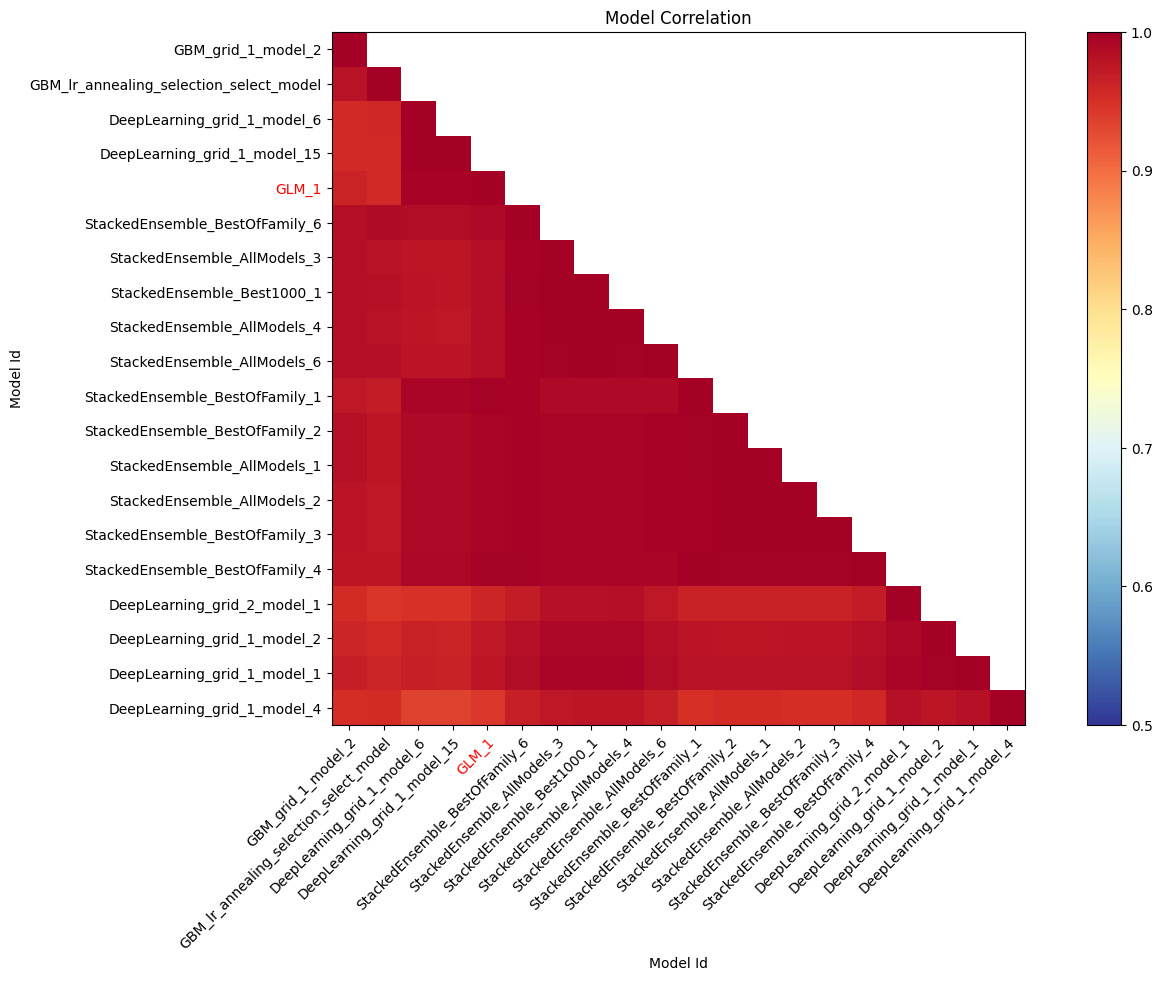

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Incorrect number of arguments; 'cols_py' expects 2 but was passed 3
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_141_sid_8ade (levels (tmp= py_140_sid_8ade (as.factor (cols_py py_139_sid_8ade np.str_('sex'))))))", 'session_id': '_sid_8ade'}


In [30]:
# Explain leader model & compare with all AutoML models
exa = model_cc.explain(test_cc)

# Explain a single H2O model (e.g. leader model from AutoML)
exm = model_cc.leader.explain(test_cc)

In [31]:
model_cc.leaderboard.head()

model_id                                                             rmse      mse      mae     rmsle    mean_residual_deviance
----------------------------------------------------------------  -------  -------  -------  --------  ------------------------
StackedEnsemble_AllModels_1_AutoML_3_20250318_115436              8.42284  70.9442  6.33114  0.129391                   70.9442
StackedEnsemble_BestOfFamily_4_AutoML_3_20250318_115436           8.44311  71.2862  6.30649  0.130115                   71.2862
StackedEnsemble_BestOfFamily_6_AutoML_3_20250318_115436           8.44975  71.3983  6.33932  0.129573                   71.3983
StackedEnsemble_BestOfFamily_3_AutoML_3_20250318_115436           8.47113  71.7601  6.39823  0.130336                   71.7601
StackedEnsemble_AllModels_2_AutoML_3_20250318_115436              8.51338  72.4776  6.45314  0.130146                   72.4776
GLM_1_AutoML_3_20250318_115436                                    8.51463  72.499   6.39133  0.131905                   72.499
StackedEnsemble_BestOfFamily_2_AutoML_3_20250318_115436           8.52686  72.7073  6.40105  0.130752                   72.7073
DeepLearning_grid_1_AutoML_3_20250318_115436_model_1              8.56032  73.2791  6.47787  0.132992                   73.2791
StackedEnsemble_AllModels_6_AutoML_3_20250318_115436              8.576    73.5478  6.51727  0.131634                   73.5478
GBM_lr_annealing_selection_AutoML_3_20250318_115436_select_model  8.59162  73.816   6.52967  0.131154                   73.816
[10 rows x 6 columns]

In [32]:
# Save cc model
h2o.save_model(model_cc.leader,  path="muac_model", force=True)

'/content/muac_model/StackedEnsemble_AllModels_1_AutoML_3_20250318_115436'

## CC-MUAC

In [33]:
# Convert dataframe to H2O frame
df_cc_muac = h2o.H2OFrame(df_cc_muac)

# Split into train & test
splits = df_cc_muac.split_frame(ratios = [0.8], seed = 1)
train_cc_muac = splits[0]
test_cc_muac = splits[1]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
model_cc_muac = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_cc_muac")
model_cc_muac.train(y=y, training_frame=train_cc_muac)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_4_20250318_122518


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# GLM base models (used / total)           1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           0/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 44.67834212244252
RMSE: 6.684185973059287
MAE: 4.9722510965289
RMSLE: 0.1008375708846851
Mean Residual Deviance: 44.67834212244252
R^2: 0.7582507612554708
Null degrees of freedom: 311
Residual degrees of freedom: 307
Null deviance: 57661.578644860085
Residual deviance: 13939.642742202066
AIC: 2082.8581715129803

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 52.97769481581295
RMSE: 7.2785778017283675
MAE: 5.3904770093107555
RMSLE: 0.10998946201543665
Mean Residual Deviance: 52.97769481581295
R^2: 0.7133439428646824
Null degrees of freedom: 311
Residual degrees of freedom: 307
Null deviance: 57959.42420728823
Residual deviance: 16529.04078253364
AIC: 2136.0173881200626

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     434.311   40.0745    407.888       493.43        447.593       388.992       433.65
loglikelihood           0         0          0             0             0             0             0
mae                     5.39171   0.474242   4.94108       5.31373       6.1399        5.05107       5.51277
mean_residual_deviance  52.9864   18.1964    38.5551       51.5642       83.2631       38.9387       52.6111
mse                     52.9864   18.1964    38.5551       51.5642       83.2631       38.9387       52.6111
null_deviance           11591.9   2733.29    10390.4       12797.5       11885.1       15107.6       7778.78
r2                      0.694301  0.123965   0.769888      0.711619      0.560939      0.850273      0.578788
residual_deviance       3305.81   1117.04    2351.86       3661.06       4995.78       2258.45       3261.89
rmse                    7.20168   1.1844     6.20928       7.18082       9.12486       6.24009       7.25335
rmsle                   0.109625  0.0107149  0.103987      0.10614       0.125731      0.0980246     0.114243

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                 rmse      mse      mae     rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
----------------------------------------------------  -------  -------  -------  --------  ------------------------  ------------------  -------------------------  ---------------
XGBoost_grid_1_AutoML_4_20250318_122518_model_61      7.87539  62.0217  6.01872  0.111441                   62.0217                 199                   0.008248  XGBoost
GBM_grid_1_AutoML_4_20250318_122518_model_26          7.9317   62.9119  5.92904  0.110692                   62.9119                  55                   0.018349  GBM
XGBoost_grid_1_AutoML_4_20250318_122518_model_30      8.01336  64.214   5.97505  0.115078                   64.214                  224                   0.011517  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_125     8.04019  64.6447  5.96985  0.114995                   64.6447                 302                   0.00938   XGBoost
GBM_grid_1_AutoML_4_20250318_122518_model_23          8.07239  65.1634  6.25258  0.113409                   65.1634                  55                   0.023637  GBM
XGBoost_grid_1_AutoML_4_20250318_122518_model_9       8.08325  65.3389  5.96454  0.1144                     65.3389                 200                   0.008276  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_51      8.11201  65.8047  5.95504  0.116734                   65.8047                 208                   0.00843   XGBoost
GBM_grid_1_AutoML_4_20250318_122518_model_3           8.13281  66.1426  6.18427  0.112916                   66.1426                  54                   0.018988  GBM
XGBoost_grid_1_AutoML_4_20250318_122518_model_21      8.15029  66.4272  6.06139  0.115178                   66.4272                 328                   0.008475  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_19      8.15933  66.5746  6.00822  0.117759                   66.5746                 456                   0.010683  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_26      8.16299  66.6344  6.11899  0.114665                   66.6344                 498                   0.00886   XGBoost
StackedEnsemble_Best1000_1_AutoML_4_20250318_122518   8.18642  67.0175  6.30154  0.114816                   67.0175                 267                   0.856147  StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_4_20250318_122518  8.19255  67.1178  6.31482  0.114984                   67.1178                 251                   0.408845  StackedEnsemble
DeepLearning_grid_1_AutoML_4_20250318_122518_model_4  8.19386  67.1394  6.37079  0.113682                   67.1394               12018                   0.010214  DeepLearning
StackedEnsemble_AllModels_3_AutoML_4_20250318_122518  8.19458  67.1512  6.31323  0.115022                   67.1512                 384                   0.522144  StackedEnsemble
DeepLearning_1_AutoML_4_20250318_122518               8.19534  67.1636  6.35853  0.114153                   67.1636                  37                   0.008163  DeepLearning
DeepLearning_grid_2_AutoML_4_20250318_122518_model_3  8.20122  67.26    6.45604  0.114246                   67.26                    42                   0.008325  DeepLearning
XGBoost_grid_1_AutoML_4_20250318_122518_model_49      8.21212  67.4389  6.10239  0.118061                   67.4389                 346                   0.009897  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_15      8.23506  67.8162  6.20501  0.118037                   67.8162                 407                   0.009089  XGBoost
XGBoost_grid_1_AutoML_4_20250318_122518_model_29      8.23741  67.8549  6.36211  0.11842                    67.8549                 279                   0.00759   XGBoost
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

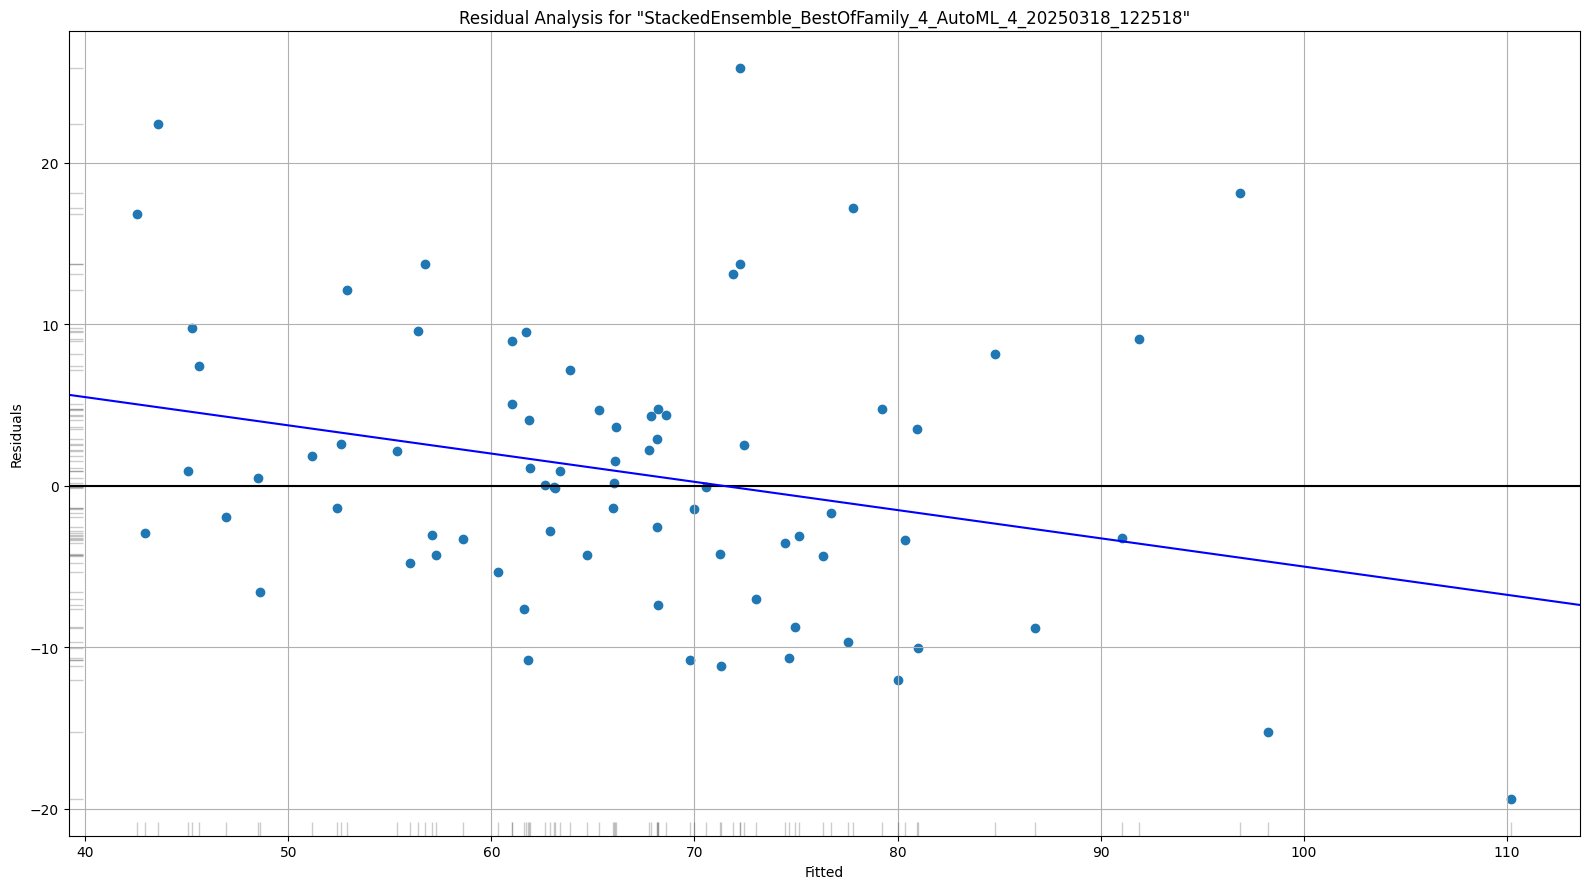

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

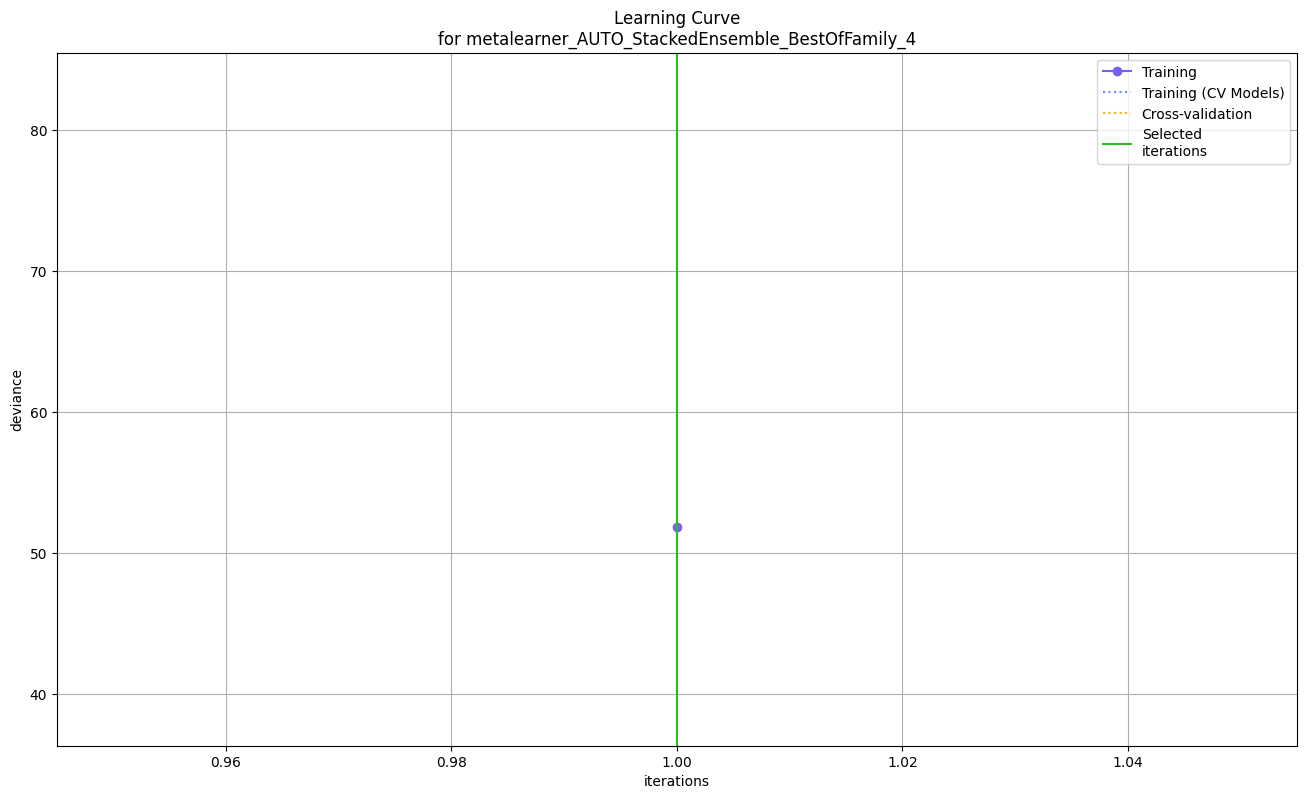

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

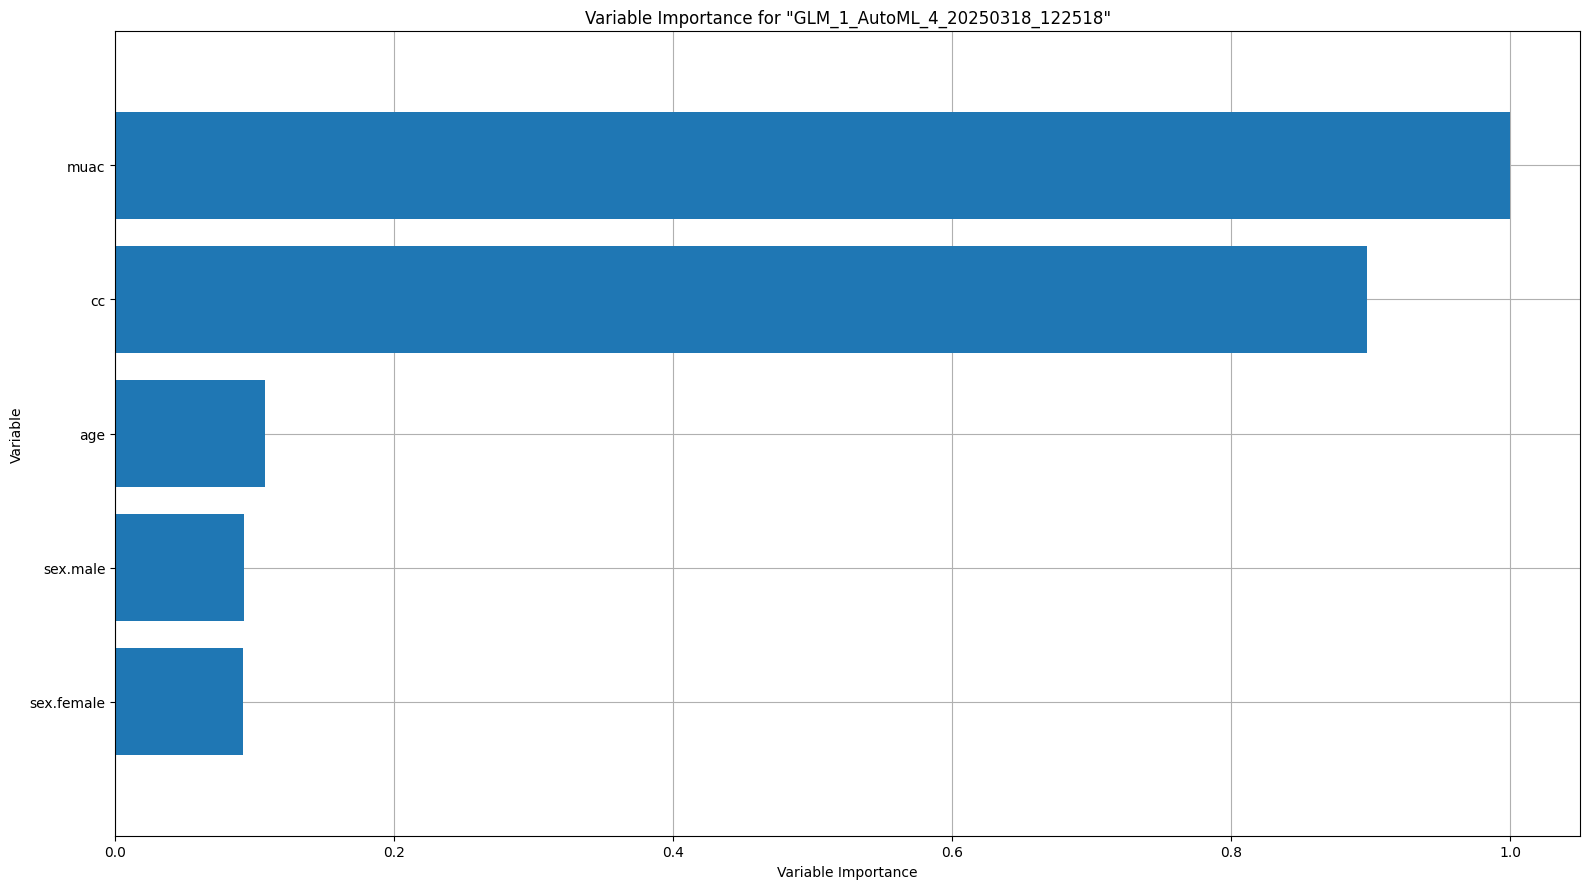

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

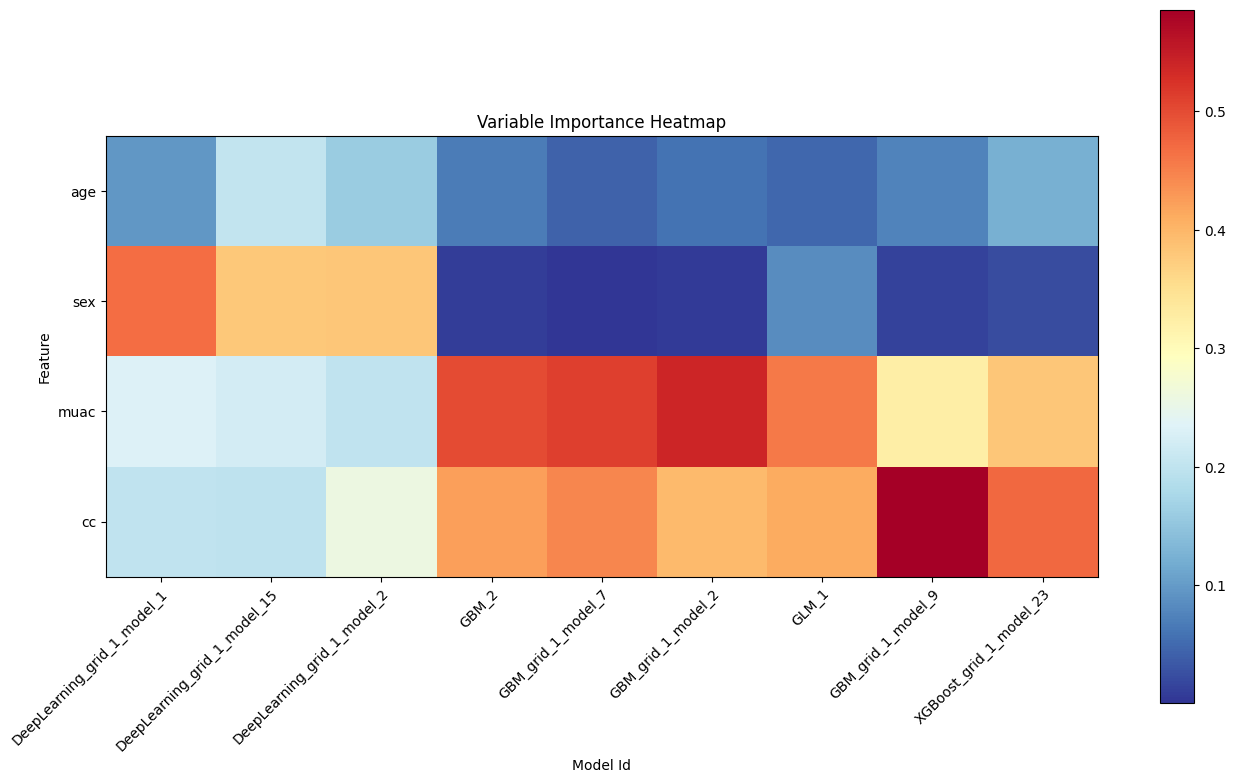

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

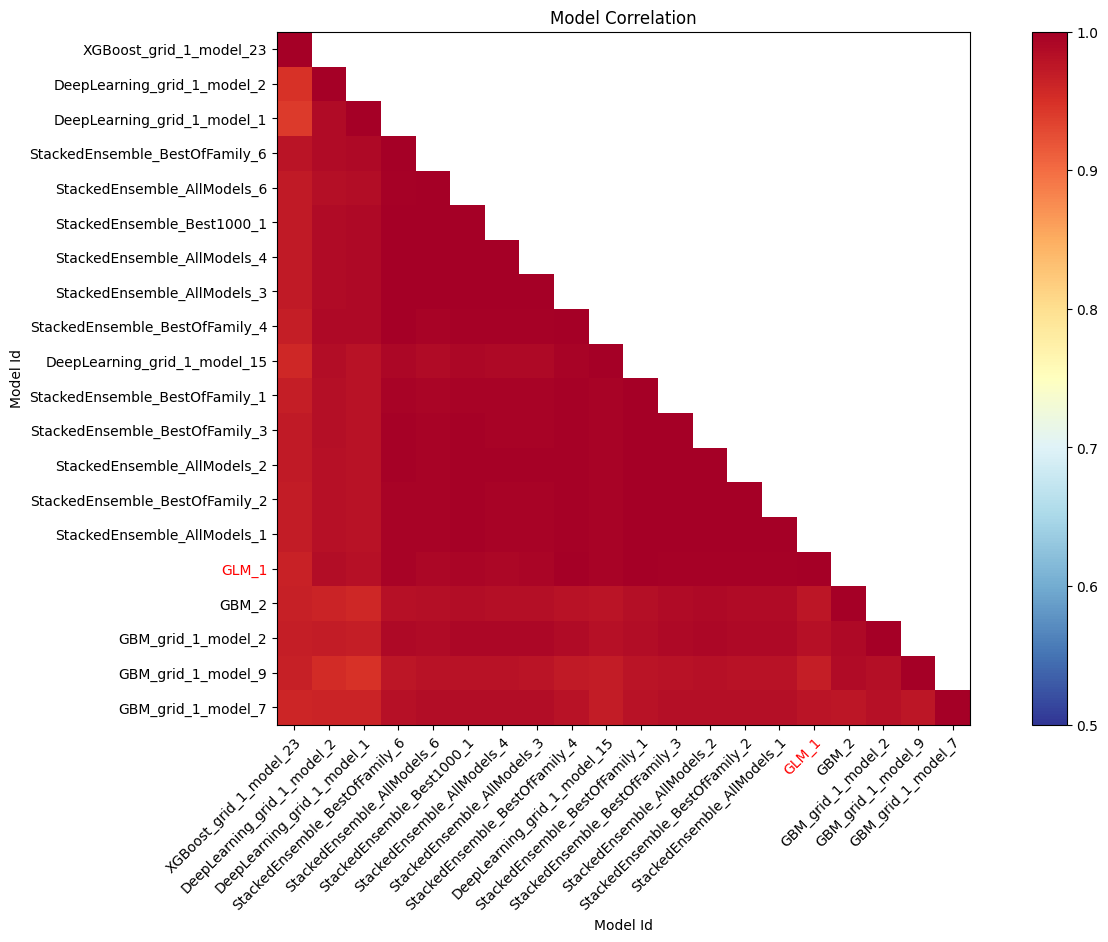

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Incorrect number of arguments; 'cols_py' expects 2 but was passed 3
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_222_sid_8ade (levels (tmp= py_221_sid_8ade (as.factor (cols_py py_220_sid_8ade np.str_('sex'))))))", 'session_id': '_sid_8ade'}


In [37]:
model_cc_muac.leaderboard.head()

model_id                                                    rmse      mse      mae     rmsle    mean_residual_deviance
-------------------------------------------------------  -------  -------  -------  --------  ------------------------
StackedEnsemble_BestOfFamily_4_AutoML_4_20250318_122518  7.27858  52.9777  5.39048  0.109989                   52.9777
StackedEnsemble_BestOfFamily_6_AutoML_4_20250318_122518  7.29688  53.2445  5.50652  0.110391                   53.2445
StackedEnsemble_AllModels_6_AutoML_4_20250318_122518     7.31383  53.4922  5.5093   0.111098                   53.4922
StackedEnsemble_AllModels_1_AutoML_4_20250318_122518     7.32803  53.7     5.47866  0.110596                   53.7
StackedEnsemble_BestOfFamily_2_AutoML_4_20250318_122518  7.33523  53.8055  5.48213  0.1109                     53.8055
GLM_1_AutoML_4_20250318_122518                           7.37221  54.3495  5.50518  0.111582                   54.3495
StackedEnsemble_BestOfFamily_3_AutoML_4_20250318_122518  7.37654  54.4134  5.53151  0.111638                   54.4134
StackedEnsemble_AllModels_2_AutoML_4_20250318_122518     7.412    54.9378  5.55851  0.111615                   54.9378
StackedEnsemble_AllModels_3_AutoML_4_20250318_122518     7.41456  54.9758  5.68027  0.11286                    54.9758
DeepLearning_grid_1_AutoML_4_20250318_122518_model_1     7.41804  55.0274  5.49091  0.112094                   55.0274
[10 rows x 6 columns]

In [38]:
# Save muac-cc model
h2o.save_model(model_cc_muac.leader,  path="muac_model", force=True)

'/content/muac_model/StackedEnsemble_BestOfFamily_4_AutoML_4_20250318_122518'

## MUAC CC BMI

In [39]:
# Convert dataframe to H2O frame
df_cc_muac_bmi = h2o.H2OFrame(df_cc_muac_bmi)

# Split into train & test
splits = df_cc_muac_bmi.split_frame(ratios = [0.8], seed = 1)
train_cc_muac_bmi = splits[0]
test_cc_muac_bmi = splits[1]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [40]:
model_cc_muac_bmi = H2OAutoML(max_runtime_secs=600, seed=1, project_name="weight_prediction_cc_muac_bmi")
model_cc_muac_bmi.train(y=y, training_frame=train_cc_muac_bmi)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_5_20250318_124251


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       3/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       0/1
# DeepLearning base models (used / total)  1/1
# GLM base models (used / total)           1/1
# DRF base models (used / total)           0/2
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 19.382317213761795
RMSE: 4.402535316583139
MAE: 3.364191504800403
RMSLE: 0.06899660799643732
Mean Residual Deviance: 19.382317213761795
R^2: 0.8951245679911155
Null degrees of freedom: 311
Residual degrees of freedom: 308
Null deviance: 57661.578644860085
Residual deviance: 6047.28297069368
AIC: 1820.298328695357

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 31.263522903594946
RMSE: 5.591379338195089
MAE: 4.159944942943331
RMSLE: 0.08418381891499598
Mean Residual Deviance: 31.263522903594946
R^2: 0.8308367655697007
Null degrees of freedom: 311
Residual degrees of freedom: 308
Null deviance: 57959.42420728823
Residual deviance: 9754.219145921623
AIC: 1969.4626735543316

Cross-Validation Metrics Summary: 
                        mean       sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     399.045    39.5462    396.476       452.459       412.521       342.949       390.818
loglikelihood           0          0          0             0             0             0             0
mae                     4.15628    0.503649   4.51219       4.10238       4.69686       3.39012       4.07987
mean_residual_deviance  31.2518    10.8531    33.0425       29.783        47.9807       18.222        27.231
mse                     31.2518    10.8531    33.0425       29.783        47.9807       18.222        27.231
null_deviance           11591.9    2733.29    10390.4       12797.5       11885.1       15107.6       7778.78
r2                      0.819026   0.0695215  0.80279       0.833434      0.746989      0.929933      0.781984
residual_deviance       1950.84    663.378    2015.59       2114.59       2878.84       1056.88       1688.32
rmse                    5.5239     0.960697   5.74826       5.45738       6.92681       4.26872       5.21834
rmsle                   0.0832504  0.0130625  0.0928731     0.0835877     0.0957346     0.0624868     0.0815696

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                    rmse      mse      mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------------------  -------  -------  -------  ---------  ------------------------  ------------------  -------------------------  ---------------
GBM_grid_1_AutoML_5_20250318_124251_model_46             5.87282  34.49    4.41348  0.0818365                   34.49                    55                   0.013063  GBM
XGBoost_grid_1_AutoML_5_20250318_124251_model_2          5.88486  34.6316  4.72556  0.0842594                   34.6316                 264                   0.014818  XGBoost
StackedEnsemble_BestOfFamily_6_AutoML_5_20250318_124251  5.95565  35.4697  4.55721  0.0824579                   35.4697                 425                   0.070027  StackedEnsemble
StackedEnsemble_AllModels_6_AutoML_5_20250318_124251     5.97911  35.7498  4.52102  0.082977                    35.7498                2131                   0.382593  StackedEnsemble
XGBoost_grid_1_AutoML_5_20250318_124251_model_3          5.98476  35.8174  4.65591  0.0840879                   35.8174                 225                   0.011828  XGBoost
GBM_grid_1_AutoML_5_20250318_124251_model_7              6.00316  36.0379  4.738    0.0872049                   36.0379                  52                   0.012965  GBM
StackedEnsemble_BestOfFamily_4_AutoML_5_20250318_124251  6.03865  36.4653  4.6492   0.0834867                   36.4653                 119                   0.063997  StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_5_20250318_124251  6.04752  36.5725  4.53217  0.0855641                   36.5725                 229                   0.042021  StackedEnsemble
GBM_grid_1_AutoML_5_20250318_124251_model_12             6.06104  36.7362  4.56269  0.0862274                   36.7362                  72                   0.018966  GBM
XGBoost_grid_1_AutoML_5_20250318_124251_model_7          6.0668   36.806   4.5416   0.0860147                   36.806                 1511                   0.010219  XGBoost
StackedEnsemble_AllModels_2_AutoML_5_20250318_124251     6.0733   36.885   4.55243  0.0859774                   36.885                  284                   0.0959    StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_5_20250318_124251  6.08628  37.0428  4.56633  0.0866088                   37.0428                 108                   0.034704  StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_5_20250318_124251     6.09097  37.1     4.54065  0.0829582                   37.1                    307                   0.330618  StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_5_20250318_124251     6.09097  37.1     4.54065  0.0829582                   37.1                    254                   0.374266  StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_5_20250318_124251  6.09361  37.132   4.58477  0.0863378                   37.132                  113                   0.044023  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_5_20250318_124251     6.09454  37.1434  4.58548  0.0863642                   37.1434                 123                   0.075346  StackedEnsemble
XGBoost_grid_1_AutoML_5_20250318_124251_model_16         6.10354  37.2531  4.64692  0.0864475                   37.2531                 264                   0.008829  XGBoost
GLM_1_AutoML_5_20250318_124251                           6.10896  37.3193  4.59881  0.086868                    37.3193                  22                   0.004718  GLM
GBM_grid_1_AutoML_5_20250318_124251_model_2              6.1223   37.4825  4.64526  0.0851638                   37.4825                  54                   0.012415  GBM
GBM_grid_1_AutoML_5_20250318_124251_model_24             6.13004  37.5774  4.51328  0.0844108                   37.5774                  50                   0.014357  GBM
[20 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

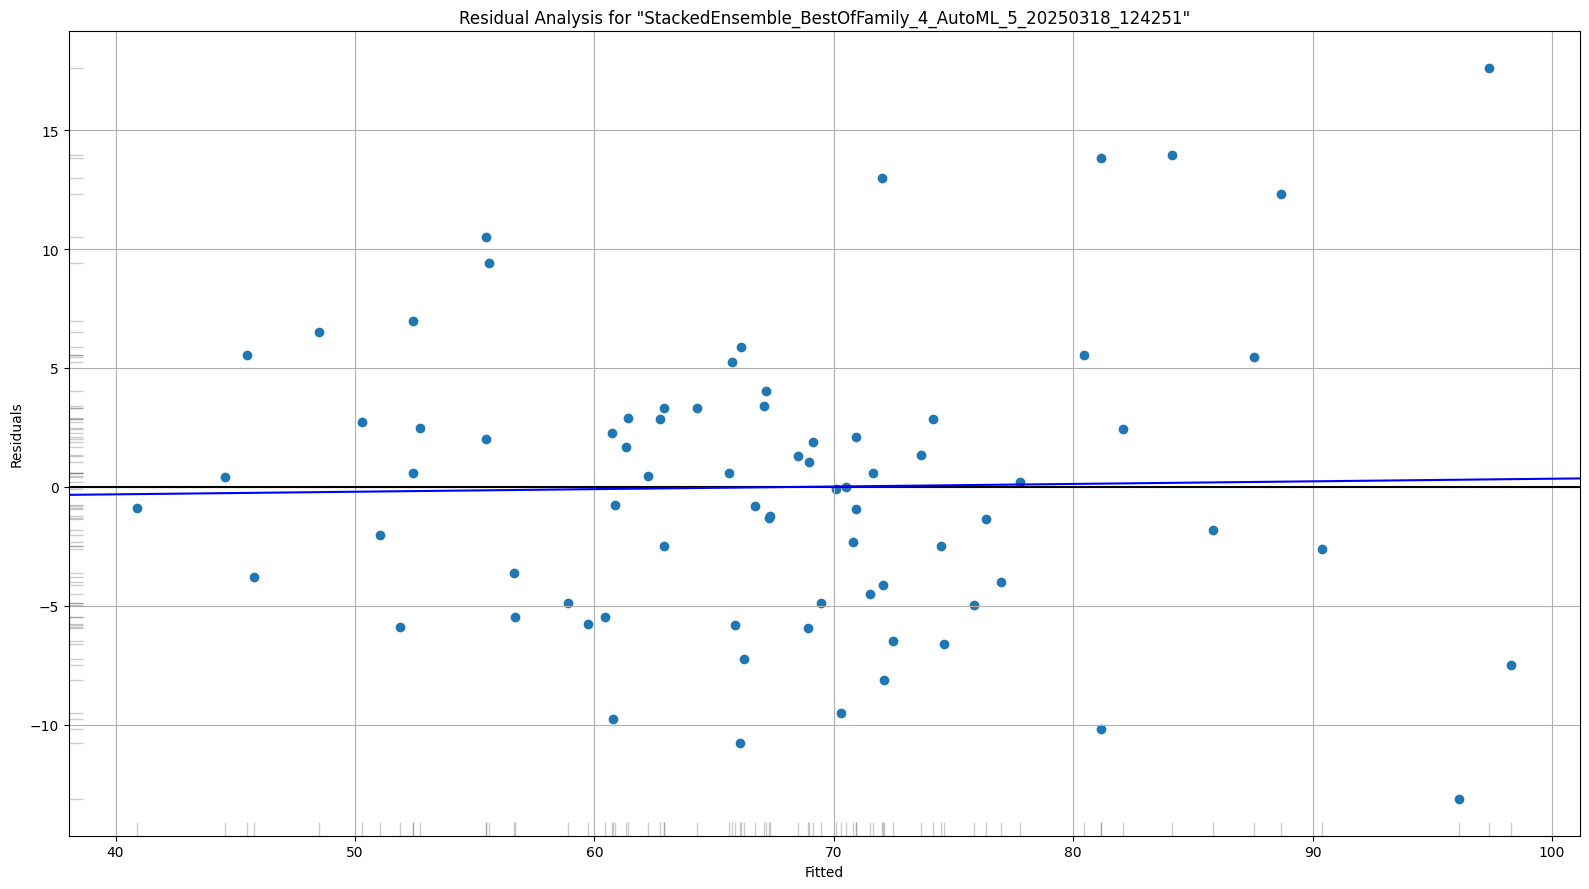

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

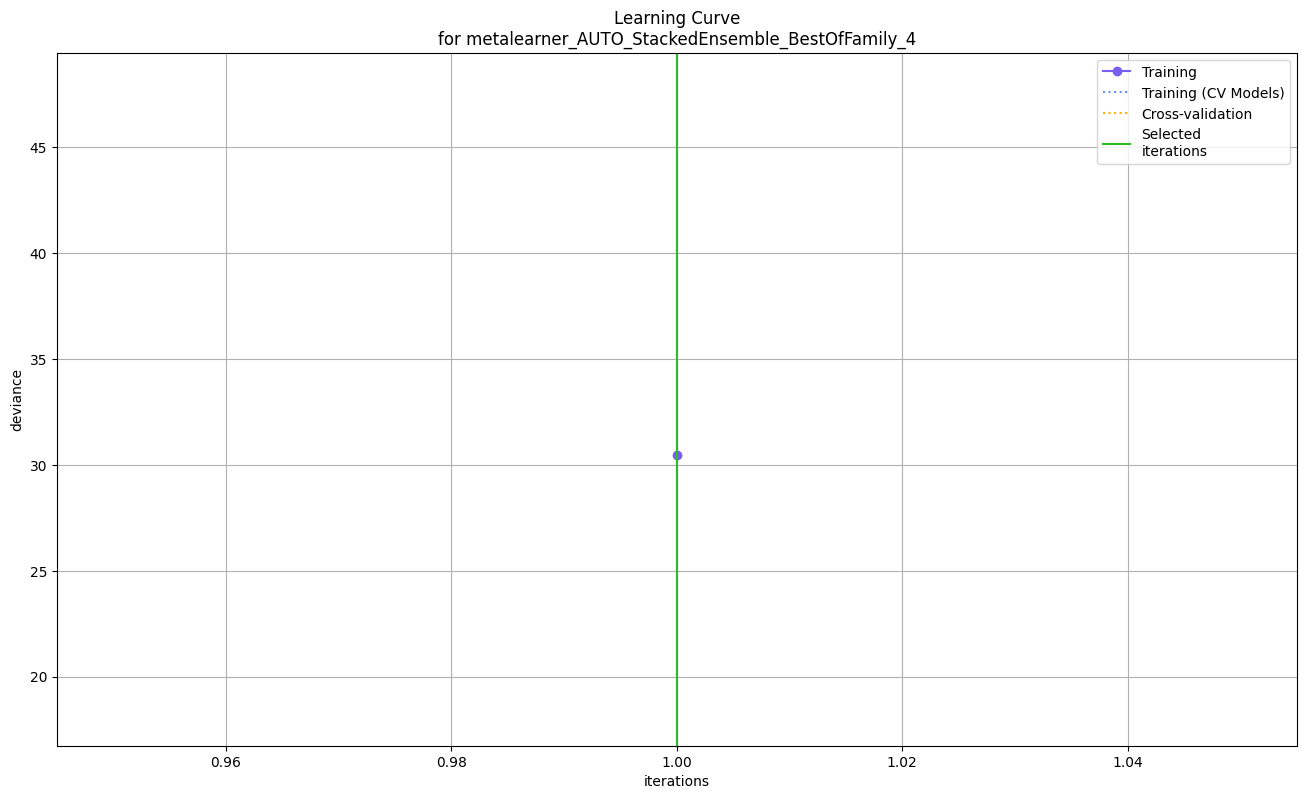

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

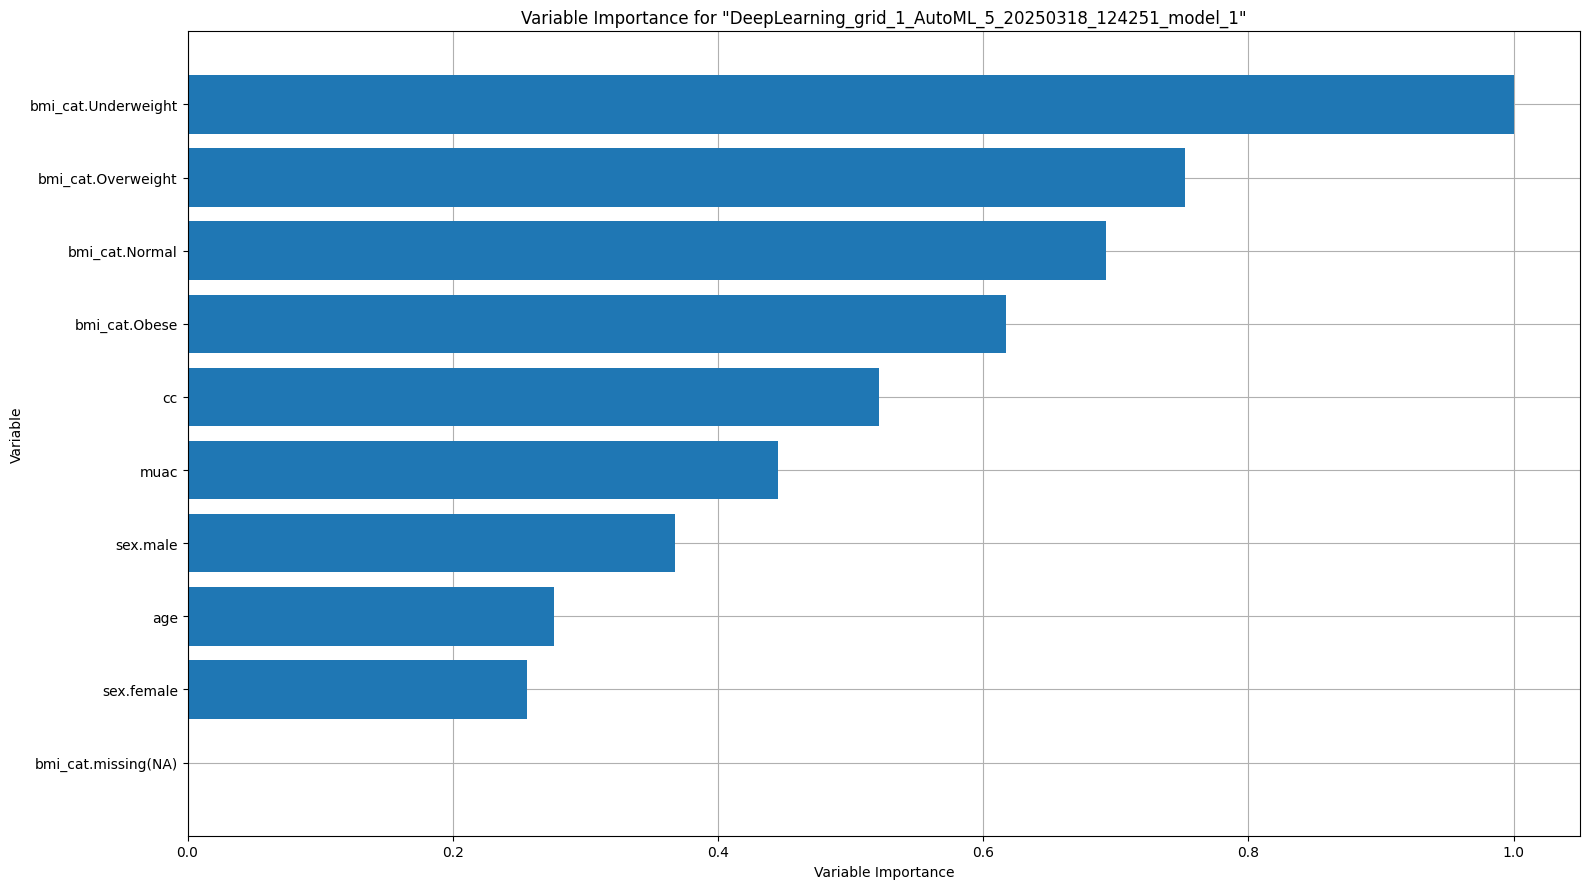

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

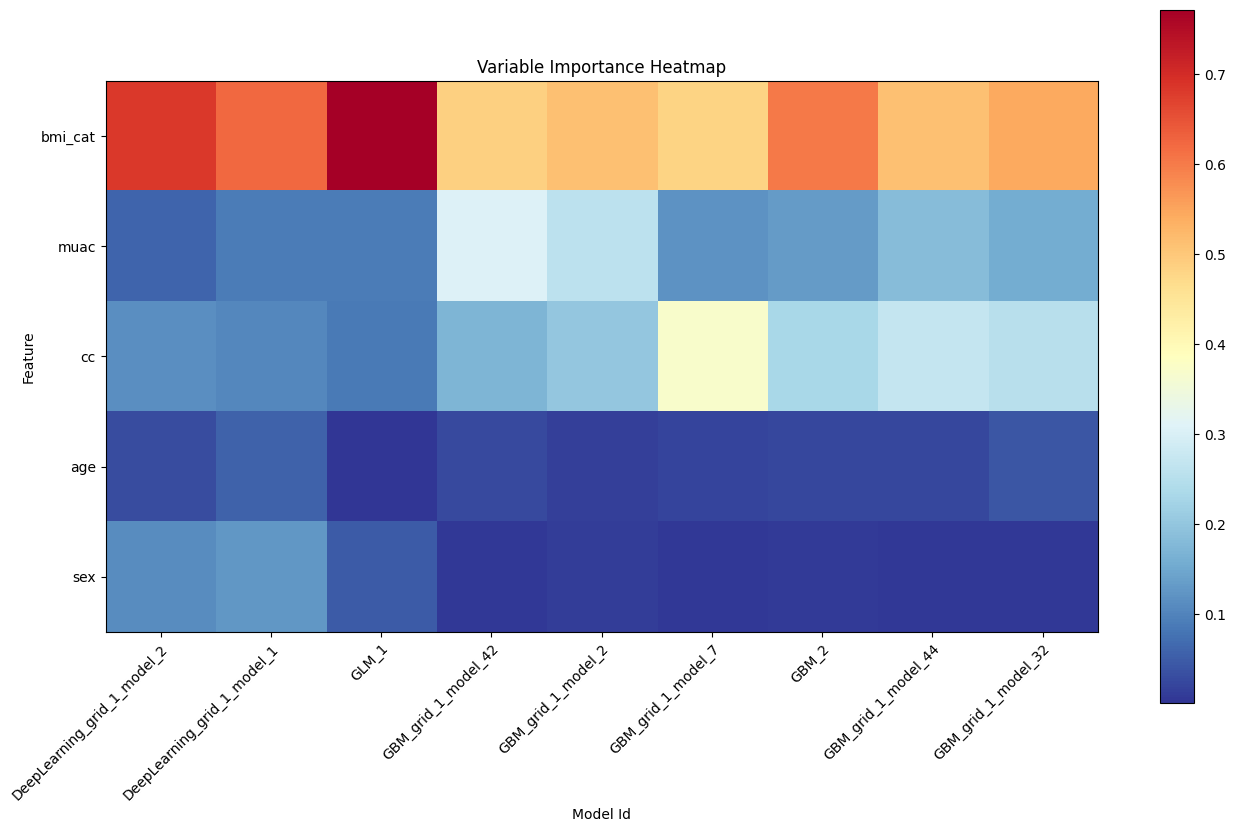

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

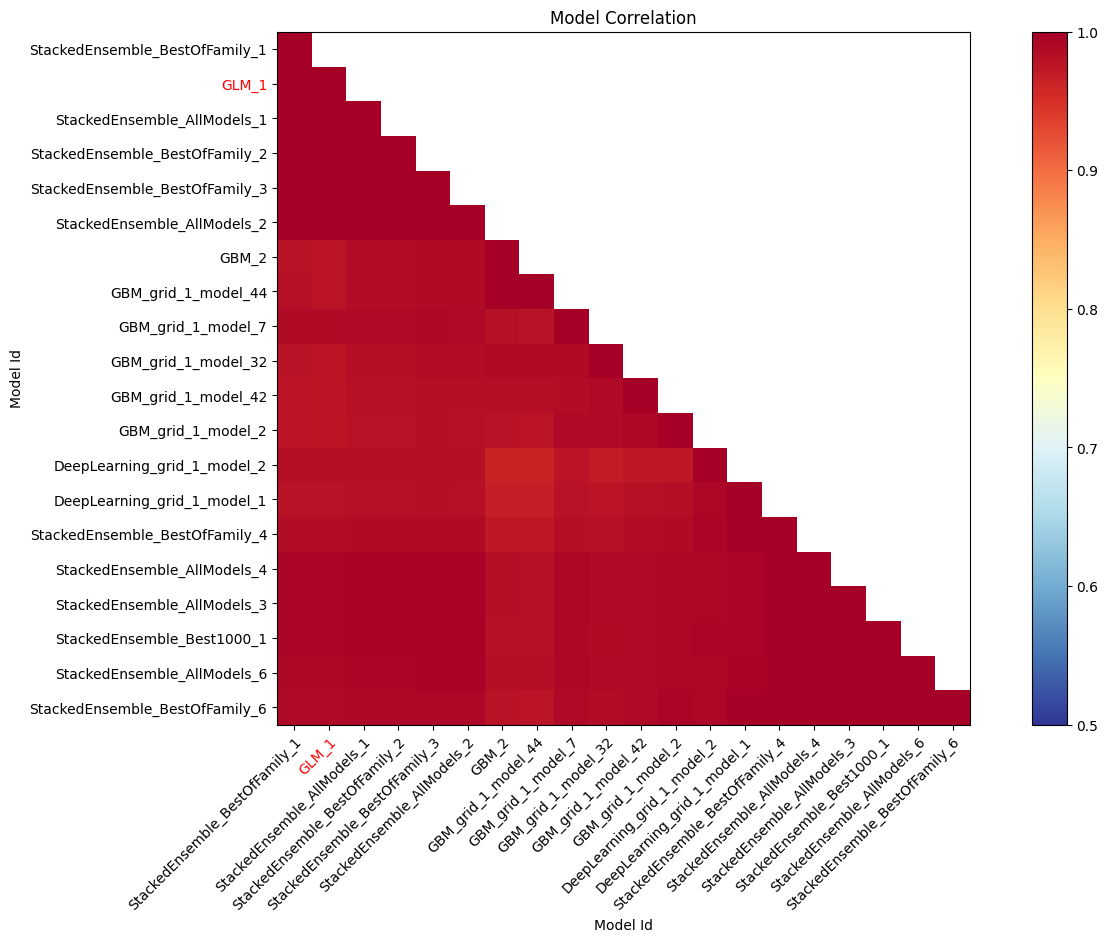

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Incorrect number of arguments; 'cols_py' expects 2 but was passed 3
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_266_sid_8ade (levels (tmp= py_265_sid_8ade (as.factor (cols_py py_264_sid_8ade np.str_('sex'))))))", 'session_id': '_sid_8ade'}


In [41]:
# Explain leader model & compare with all AutoML models
exa = model_cc_muac_bmi.explain(test_cc_muac_bmi)

# Explain a single H2O model (e.g. leader model from AutoML)
exm = model_cc_muac_bmi.leader.explain(test_cc_muac_bmi)

In [42]:
model_cc_muac_bmi.leaderboard.head()

model_id                                                    rmse      mse      mae      rmsle    mean_residual_deviance
-------------------------------------------------------  -------  -------  -------  ---------  ------------------------
StackedEnsemble_BestOfFamily_4_AutoML_5_20250318_124251  5.59138  31.2635  4.15994  0.0841838                   31.2635
StackedEnsemble_BestOfFamily_6_AutoML_5_20250318_124251  5.6155   31.5339  4.16054  0.0847648                   31.5339
StackedEnsemble_AllModels_6_AutoML_5_20250318_124251     5.63683  31.7739  4.10231  0.0848966                   31.7739
DeepLearning_grid_1_AutoML_5_20250318_124251_model_1     5.66706  32.1155  4.27467  0.0856613                   32.1155
StackedEnsemble_BestOfFamily_2_AutoML_5_20250318_124251  5.72973  32.8298  4.2101   0.084957                    32.8298
StackedEnsemble_AllModels_2_AutoML_5_20250318_124251     5.74116  32.9609  4.20737  0.084946                    32.9609
GLM_1_AutoML_5_20250318_124251                           5.75537  33.1243  4.25984  0.0857538                   33.1243
StackedEnsemble_AllModels_1_AutoML_5_20250318_124251     5.7701   33.2941  4.25563  0.0853413                   33.2941
StackedEnsemble_BestOfFamily_3_AutoML_5_20250318_124251  5.77143  33.3094  4.20483  0.0852936                   33.3094
GBM_grid_1_AutoML_5_20250318_124251_model_2              5.80275  33.6719  4.24262  0.0877346                   33.6719
[10 rows x 6 columns]

In [43]:
# Save muac-cc-bmi model
h2o.save_model(model_cc_muac_bmi.leader,  path="muac_model", force=True)

'/content/muac_model/StackedEnsemble_BestOfFamily_4_AutoML_5_20250318_124251'

# Modelling

## Data splitting

Split the data into training and testing sets using train_test_split, stratifying by 'bmi_cat'.



In [ ]:
# Define features (X) and target (y)
features = ["age", "sex", "height", "cc", "muac", "bmi_cat"]
X = df[features]
y = df['weight']

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['bmi_cat'])

## Feature engineering

Engineer new features from existing ones in the training data (`X_train`)



Create interaction terms and transformations for numerical features in X_train, then evaluate the new features for multicollinearity.



In [ ]:
# # Create interaction terms
# X_train['height_bmi'] = X_train['height'] * X_train['bmi']
# X_train['age_bmi'] = X_train['age'] * X_train['bmi']

# # Apply logarithmic transformation to 'age'
# X_train['log_age'] = np.log1p(X_train['age'])

# # Apply polynomial transformation to 'height' (degree 2)
# X_train['height_squared'] = X_train['height'] ** 2



numerical_features = X_train.select_dtypes(include=['number']).columns
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_features
vif_data["VIF"] = [variance_inflation_factor(X_train[numerical_features].values, i) for i in range(len(numerical_features))]

display(vif_data)

# Remove features with high VIF if necessary (threshold > 5 or 10)
# For example:
#if vif_data[vif_data['VIF'] > 10].shape[0] > 0:
#    high_vif_cols = vif_data[vif_data['VIF'] > 10]['feature'].values
#    X_train = X_train.drop(high_vif_cols, axis=1)
#    print(f"Removed features with high VIF: {high_vif_cols}")

feature         VIF
0     age    9.847033
1  height   79.429865
2      cc  176.744224
3    muac  113.310991

**Reasoning**:
Based on the VIF values, several features exhibit high multicollinearity.  I will remove the features with VIF > 10 and continue.



In [ ]:
# high_vif_cols = vif_data[vif_data['VIF'] > 10]['feature'].values
# X_train = X_train.drop(high_vif_cols, axis=1)
# print(f"Removed features with high VIF: {high_vif_cols}")

Removed features with high VIF: ['age' 'height' 'cc' 'muac' 'bmi' 'height_bmi' 'age_bmi' 'log_age'
 'height_squared']


## Data preparation

### Subtask:
Prepare the training and testing datasets for model training.


Apply the same feature engineering steps performed on X_train to X_test, then identify numerical features, fit a RobustScaler to numerical features of X_train, transform numerical features of X_train and X_test using the fitted scaler, and finally one-hot encode categorical features in both X_train and X_test, making sure the same columns are present in both datasets.



In [ ]:
# # Apply the same feature engineering steps to X_test
# X_test['height_bmi'] = X_test['height'] * X_test['bmi']
# X_test['age_bmi'] = X_test['age'] * X_test['bmi']
# X_test['log_age'] = np.log1p(X_test['age'])
# X_test['height_squared'] = X_test['height'] ** 2

# # Identify numerical features in X_train (after feature removal in previous steps)
# numerical_features = X_train.select_dtypes(include=['number']).columns

# #Check if there are numerical features
# if len(numerical_features) > 0:
#     # Fit RobustScaler on numerical features of X_train
#     scaler = RobustScaler()
#     scaler.fit(X_train[numerical_features])
#     # Transform numerical features of X_train and X_test
#     X_train[numerical_features] = scaler.transform(X_train[numerical_features])
#     X_test[numerical_features] = scaler.transform(X_test[numerical_features])
# else:
#     print("No numerical features found in X_train after VIF check. Skipping scaling.")

# One-hot encode categorical features
categorical_cols = ['sex', 'bmi_cat']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure same columns in both datasets
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

display(X_train.head())
display(X_test.head())

age  height    cc  muac  sex_male  bmi_cat_Obese  bmi_cat_Overweight  \
342   45   146.6  38.8  40.0      True           True               False   
196   57   162.1  37.7  35.0     False          False               False   
50    52   157.1  38.0  32.8     False          False                True   
363   65   164.9  35.1  30.3      True          False                True   
246   67   167.2  29.8  32.5     False          False               False   

     bmi_cat_Underweight  
342                False  
196                False  
50                 False  
363                False  
246                False

age  height    cc  muac  sex_male  bmi_cat_Obese  bmi_cat_Overweight  \
299   66  155.20  36.0  32.5      True          False               False   
32    48  165.50  58.0  48.7     False           True               False   
256   68  156.05  36.5  34.5     False          False                True   
355   69  160.00  32.5  35.4      True          False                True   
284   76  155.10  37.9  31.7      True          False               False   

     bmi_cat_Underweight  
299                False  
32                 False  
256                False  
355                False  
284                False

## Model training

Train a baseline linear regression model.


Train a baseline linear regression model, get the coefficients and map them back to original feature names.

In [ ]:
# Initialize the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Get feature importances (coefficients)
feature_importances = pd.Series(model.coef_, index=X_train.columns)

# Display feature importances
display(feature_importances)

age                     0.021826
height                  0.492315
cc                      0.486014
muac                    0.632780
sex_male                0.750352
bmi_cat_Obese          20.904015
bmi_cat_Overweight      9.258936
bmi_cat_Underweight   -10.925518
dtype: float64

## Model training


Train multiple regression models using the most important features.


Train multiple regression models using the selected features from the previous step.  The top 5 features from the previous step's linear regression model will be selected.



In [ ]:
# # Select top 5 features based on absolute coefficient values
# top_n = 5
# feature_importances = pd.Series(model.coef_, index=X_train.columns).abs().sort_values(ascending=False)
# selected_features = feature_importances.head(top_n).index.tolist()

# # Create new training and testing datasets with selected features
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Elastic Net Regression": ElasticNet(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "XGBRegressor": XGBRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "HuberRegressor": HuberRegressor(max_iter=1000),
}

# Train models
trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

## Model optimization


Optimize the hyperparameters of the trained regression models.


Optimize the hyperparameters of the trained regression models using GridSearchCV or RandomizedSearchCV.



In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import randint, uniform

# Define the parameter grids for each model
param_grids = {
    "Linear Regression": {},  # No hyperparameters to tune
    "Ridge Regression": {"alpha": [0.1, 1, 10]},
    "Lasso Regression": {"alpha": [0.1, 1, 10]},
    "Elastic Net Regression": {"alpha": [0.1, 1, 10], "l1_ratio": [0.1, 0.5, 0.9]},
    "Random Forest Regressor": {"n_estimators": randint(50, 200), "max_depth": randint(5, 20)},
    "Gradient Boosting Regressor": {"n_estimators": randint(50, 200), "learning_rate": uniform(0.01, 0.3)},
    "XGBRegressor": {"n_estimators": randint(50, 200), "learning_rate": uniform(0.01, 0.3)},
    "Decision Tree Regressor": {"max_depth": randint(2, 10)},
    "HuberRegressor": {"epsilon": [1.1, 1.35, 1.5], "max_iter": [1000, 2000, 3000]},
}


# Perform hyperparameter tuning for each model
best_models = {}
for name, model in trained_models.items():
    if name in param_grids:
        param_grid = param_grids[name]
        if name in ["Random Forest Regressor", "Gradient Boosting Regressor", "XGBRegressor", "Decision Tree Regressor"]:
            search = RandomizedSearchCV(
                model, param_distributions=param_grid, n_iter=20, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
            )
        else:
            search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

        search.fit(X_train, y_train)

        print(f"Best hyperparameters for {name}: {search.best_params_}")
        print(f"Best score for {name}: {search.best_score_}")
        best_models[name] = search.best_estimator_
    else:
        print(f"No hyperparameters defined for {name}, using default parameters.")
        best_models[name] = model

Best hyperparameters for Linear Regression: {}
Best score for Linear Regression: -24.33207972035604
Best hyperparameters for Ridge Regression: {'alpha': 0.1}
Best score for Ridge Regression: -24.32898068476313
Best hyperparameters for Lasso Regression: {'alpha': 0.1}
Best score for Lasso Regression: -24.973422256323044
Best hyperparameters for Elastic Net Regression: {'alpha': 0.1, 'l1_ratio': 0.9}
Best score for Elastic Net Regression: -26.67992355721873
Best hyperparameters for Random Forest Regressor: {'max_depth': 19, 'n_estimators': 64}
Best score for Random Forest Regressor: -23.74002113927701
Best hyperparameters for Gradient Boosting Regressor: {'learning_rate': np.float64(0.22659963168004743), 'n_estimators': 87}
Best score for Gradient Boosting Regressor: -24.332870465867927
Best hyperparameters for XGBRegressor: {'learning_rate': np.float64(0.19033450352296263), 'n_estimators': 180}
Best score for XGBRegressor: -27.510226540236935
Best hyperparameters for Decision Tree Regre

## Model evaluation

Evaluate the performance of the tuned models on the test set.


Evaluate the performance of the tuned models on the test set using R-squared, MSE, and MAE.



In [ ]:
evaluation_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    evaluation_results[name] = {"R-squared": r2, "MSE": mse, "MAE": mae}

for name, metrics in evaluation_results.items():
    print(f"Model: {name}")
    print(f"  R-squared: {metrics['R-squared']:.4f}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  MAE: {metrics['MAE']:.4f}")

Model: Linear Regression
  R-squared: 0.9095
  MSE: 20.8645
  MAE: 3.3026
Model: Ridge Regression
  R-squared: 0.9095
  MSE: 20.8528
  MAE: 3.2976
Model: Lasso Regression
  R-squared: 0.9089
  MSE: 20.9824
  MAE: 3.2399
Model: Elastic Net Regression
  R-squared: 0.9034
  MSE: 22.2605
  MAE: 3.2362
Model: Random Forest Regressor
  R-squared: 0.8866
  MSE: 26.1258
  MAE: 3.5344
Model: Gradient Boosting Regressor
  R-squared: 0.8877
  MSE: 25.8819
  MAE: 3.6271
Model: XGBRegressor
  R-squared: 0.8913
  MSE: 25.0386
  MAE: 3.4539
Model: Decision Tree Regressor
  R-squared: 0.8355
  MSE: 37.8999
  MAE: 3.8765
Model: HuberRegressor
  R-squared: 0.9021
  MSE: 22.5498
  MAE: 3.3585


In [ ]:
pd.DataFrame(evaluation_results).T.sort_values(by='MAE', ascending=True)

R-squared        MSE       MAE
Elastic Net Regression        0.903393  22.260505  3.236220
Lasso Regression              0.908940  20.982366  3.239880
Ridge Regression              0.909502  20.852845  3.297618
Linear Regression             0.909451  20.864546  3.302597
HuberRegressor                0.902137  22.549817  3.358456
XGBRegressor                  0.891336  25.038611  3.453902
Random Forest Regressor       0.886618  26.125827  3.534377
Gradient Boosting Regressor   0.887677  25.881894  3.627073
Decision Tree Regressor       0.835520  37.899889  3.876460

## Summary:

### 1. Q&A

* **What is the best performing model based on R2 score, mean squared error, and mean absolute error?**  The Linear Regression model achieved the highest R-squared score (0.7258) and the lowest MSE (70.3250) on the test set, indicating it performed best among the models evaluated.

### 2. Data Analysis Key Findings

* **Outliers:** Outliers in 'weight' and 'bmi' were handled using the IQR method with winsorization at the 1st and 99th percentiles.
* **Missing Values:** Six missing values in 'bmi_cat' were imputed using the mode (Normal).
* **Feature Importance:**  Initial feature importance from the baseline Linear Regression model highlighted features like `bmi_cat_Obese`, `bmi_cat_Overweight`, and `religion_Traditional` as having strong relationships with weight.
* **Multicollinearity:**  Features with high Variance Inflation Factors (VIF > 10) were removed (`age`, `height`, `cc`, `muac`, `bmi`, `height_bmi`, `age_bmi`, `log_age`, `height_squared`).  This suggests that a high degree of multicollinearity existed between the original features and the engineered ones.
* **Model Performance:**  The best performing model was Linear Regression with R-squared: 0.7258, MSE: 70.3250, and MAE: 6.9233,  though differences in performance were relatively small across all models.


### 3. Insights or Next Steps

* **Explore Feature Engineering Further:** Investigate alternative feature engineering strategies that mitigate multicollinearity issues more effectively, potentially by using dimensionality reduction techniques like Principal Component Analysis (PCA) or focusing on domain-relevant feature combinations.
* **Consider More Sophisticated Models and Tuning:** Given the relatively small differences in performance across models, particularly among the tree-based methods and linear models, consider more complex modeling techniques like Support Vector Regression or Neural Networks and dedicate more computational resources to an exhaustive hyperparameter search.


# Task
This projects seeks to buid robust models to predict weight using relevant features.
Split the data into a train-test split of 80-20%.  Train the following models: “Support vector machine", "Neural network". Tune the hyperparameters and save the model, which you should use to evaluate the model on test data. The target vector is “weight”. Highlight the best model based on metrics: R2 score, mean squared error, mean absolute error.


## Feature engineering

### Subtask:
Prepare the data for model training by performing necessary feature engineering steps.


**Reasoning**:
Encode categorical features using one-hot encoding, scale numerical features using StandardScaler, and then prepare the data for model training.



In [ ]:
# Identify categorical and numerical features
categorical_features = ['sex', 'religion', 'education_level', 'employment', 'bmi_cat']
numerical_features = ['age', 'height', 'cc', 'muac', 'bmi']

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the testing data
X_test_processed = preprocessor.transform(X_test)

# Convert the processed data back to DataFrames (optional, but helpful for inspection)
# Get feature names after one-hot encoding
feature_names = list(numerical_features)
feature_names.extend(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

# Create DataFrames for the processed data
X_train_processed = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_processed = pd.DataFrame(X_test_processed, columns=feature_names)

display(X_train_processed.head())
display(X_test_processed.head())

age    height        cc      muac       bmi  sex_Female  sex_Male  \
0  0.575487  0.286878  1.239998  2.179188  0.825553         1.0       0.0   
1 -0.280860  0.055084  0.565152  0.433178 -0.460602         1.0       0.0   
2  0.004589 -0.220172  0.309176  2.179188  1.097660         1.0       0.0   
3  0.632577 -0.727222 -1.017244 -1.037146 -1.382651         1.0       0.0   
4 -0.337949  0.098545 -0.063152  0.548047 -0.075400         0.0       1.0   

   religion_Christian  religion_Islam  religion_Traditional  ...  \
0                 1.0             0.0                   0.0  ...   
1                 1.0             0.0                   0.0  ...   
2                 1.0             0.0                   0.0  ...   
3                 1.0             0.0                   0.0  ...   
4                 1.0             0.0                   0.0  ...   

   education_level_Primary  education_level_SSS/SHS/Secondary  \
0                      0.0                                1.0   
1                      0.0                                1.0   
2                      0.0                                1.0   
3                      0.0                                1.0   
4                      1.0                                0.0   

   employment_Employed  employment_Retired  employment_Self employed  \
0                  0.0                 1.0                       0.0   
1                  0.0                 0.0                       1.0   
2                  0.0                 0.0                       1.0   
3                  0.0                 1.0                       0.0   
4                  0.0                 0.0                       1.0   

   employment_Unemployed  bmi_cat_Normal  bmi_cat_Obese  bmi_cat_Overweight  \
0                    0.0             0.0            0.0                 1.0   
1                    0.0             1.0            0.0                 0.0   
2                    0.0             0.0            1.0                 0.0   
3                    0.0             1.0            0.0                 0.0   
4                    0.0             1.0            0.0                 0.0   

   bmi_cat_Underweight  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 23 columns]

age    height        cc      muac       bmi  sex_Female  sex_Male  \
0 -1.194296  0.142007  0.518611  1.030498  0.660474         0.0       1.0   
1  0.004589  0.402775 -0.784539 -1.565544 -1.749670         1.0       0.0   
2 -2.050642  1.373413  0.309176 -0.141167  0.224794         1.0       0.0   
3  0.461307 -0.292608 -0.993974 -0.187115  0.304196         1.0       0.0   
4  0.575487  0.199955 -0.435481 -0.347931 -0.352365         0.0       1.0   

   religion_Christian  religion_Islam  religion_Traditional  ...  \
0                 1.0             0.0                   0.0  ...   
1                 1.0             0.0                   0.0  ...   
2                 1.0             0.0                   0.0  ...   
3                 0.0             1.0                   0.0  ...   
4                 0.0             1.0                   0.0  ...   

   education_level_Primary  education_level_SSS/SHS/Secondary  \
0                      0.0                                1.0   
1                      0.0                                0.0   
2                      1.0                                0.0   
3                      0.0                                0.0   
4                      0.0                                0.0   

   employment_Employed  employment_Retired  employment_Self employed  \
0                  0.0                 0.0                       1.0   
1                  0.0                 0.0                       1.0   
2                  0.0                 0.0                       0.0   
3                  0.0                 0.0                       0.0   
4                  0.0                 0.0                       1.0   

   employment_Unemployed  bmi_cat_Normal  bmi_cat_Obese  bmi_cat_Overweight  \
0                    0.0             0.0            0.0                 1.0   
1                    0.0             0.0            0.0                 0.0   
2                    1.0             0.0            0.0                 1.0   
3                    1.0             0.0            0.0                 1.0   
4                    0.0             1.0            0.0                 0.0   

   bmi_cat_Underweight  
0                  0.0  
1                  1.0  
2                  0.0  
3                  0.0  
4                  0.0  

[5 rows x 23 columns]

## Model training

### Subtask:
Train a Support Vector Machine (SVM) and a Neural Network (NN) model on the preprocessed training data.


**Reasoning**:
Train the SVM and Neural Network models using the preprocessed training data.



In [ ]:
# Initialize and train the SVM model
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

# Initialize and train the Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

## Model optimization

### Subtask:
Optimize the hyperparameters of the pre-trained SVM and Neural Network models using GridSearchCV.


**Reasoning**:
Optimize the hyperparameters of the pre-trained SVM and Neural Network models using GridSearchCV.



In [ ]:
# Define parameter grids for SVM and NN
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}

param_grid_nn = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (32,16)],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [1000, 2000],
}

# Create GridSearchCV objects
grid_search_svm = GridSearchCV(SVR(), param_grid_svm, cv=5, scoring='neg_mean_squared_error')
grid_search_nn = GridSearchCV(MLPRegressor(random_state=42), param_grid_nn, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV objects to the training data
grid_search_svm.fit(X_train, y_train)
grid_search_nn.fit(X_train, y_train)

# Get the best models and hyperparameters
best_svm_model = grid_search_svm.best_estimator_
best_svm_params = grid_search_svm.best_params_
best_nn_model = grid_search_nn.best_estimator_
best_nn_params = grid_search_nn.best_params_

print(f"Best SVM Hyperparameters: {best_svm_params}")
print(f"Best NN Hyperparameters: {best_nn_params}")

# Save the best models
joblib.dump(best_svm_model, 'best_svm_model.pkl')
joblib.dump(best_nn_model, 'best_nn_model.pkl')

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/usr/local/lib/python3.11/dist-pac

## Model evaluation

### Subtask:
Evaluate the performance of the optimized SVM and Neural Network models on the test data.


**Reasoning**:
Load the saved models and evaluate them on the test data. Calculate the R-squared, Mean Squared Error, and Mean Absolute Error for both models.



In [ ]:
# Load the saved models
best_svm_model = joblib.load('best_svm_model.pkl')
best_nn_model = joblib.load('best_nn_model.pkl')

# Predict on the test data
y_pred_svm = best_svm_model.predict(X_test_processed)
y_pred_nn = best_nn_model.predict(X_test_processed)

# Calculate evaluation metrics
r2_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
mae_svm = mean_absolute_error(y_test, y_pred_svm)

r2_nn = r2_score(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)

# Store the results
results = {
    'SVM': {'R2': r2_svm, 'MSE': mse_svm, 'MAE': mae_svm},
    'NN': {'R2': r2_nn, 'MSE': mse_nn, 'MAE': mae_nn}
}

print(results)

{'SVM': {'R2': 0.9923210370187665, 'MSE': 1.2924963070505104, 'MAE': 0.5011491227614857}, 'NN': {'R2': 0.9623289095451687, 'MSE': 6.340666755970443, 'MAE': 0.8232919201742853}}


## Data visualization

### Subtask:
Visualize the performance metrics (R2, MSE, MAE) of the SVM and NN models.


**Reasoning**:
Visualize the performance metrics (R2, MSE, MAE) of the SVM and NN models using bar charts.



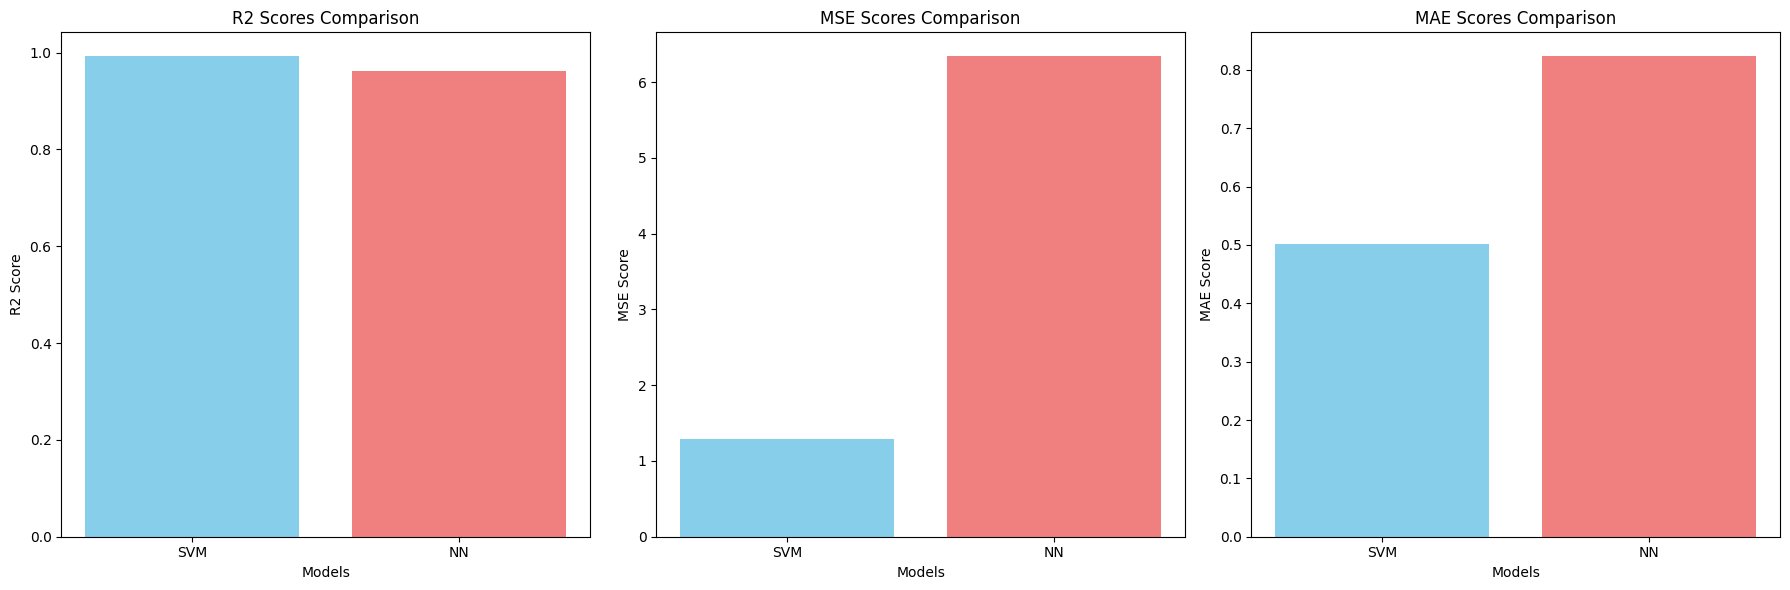

In [ ]:
# Data for plotting
models = ['SVM', 'NN']
r2_scores = [results['SVM']['R2'], results['NN']['R2']]
mse_scores = [results['SVM']['MSE'], results['NN']['MSE']]
mae_scores = [results['SVM']['MAE'], results['NN']['MAE']]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot R2 scores
axes[0].bar(models, r2_scores, color=['skyblue', 'lightcoral'])
axes[0].set_title('R2 Scores Comparison')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('R2 Score')

# Plot MSE scores
axes[1].bar(models, mse_scores, color=['skyblue', 'lightcoral'])
axes[1].set_title('MSE Scores Comparison')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('MSE Score')

# Plot MAE scores
axes[2].bar(models, mae_scores, color=['skyblue', 'lightcoral'])
axes[2].set_title('MAE Scores Comparison')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('MAE Score')

plt.tight_layout()
plt.show()

## Summary:

### 1. Q&A

* **What is the best model for predicting weight based on the provided features?**  The SVM model is the best performer, achieving an R2 score of 0.992, MSE of 1.29, and MAE of 0.50 on the test data. This is significantly better than the Neural Network model's performance.

### 2. Data Analysis Key Findings

* **SVM outperforms NN:** The Support Vector Machine model significantly outperformed the Neural Network model across all evaluation metrics (R2, MSE, MAE).  The SVM achieved an R2 of 0.992, MSE of 1.29, and MAE of 0.50, while the NN achieved an R2 of 0.962, MSE of 6.34, and MAE of 0.82.
* **Missing BMI Category values filled with mode:** Six missing values in the 'bmi_cat' column were filled with the mode of that column.
* **Outliers capped using IQR:** Outliers in 'age', 'height', 'weight', 'muac', and 'bmi' were capped using the IQR method to prevent their undue influence on the models.
* **Optimal SVM Hyperparameters:** GridSearchCV identified the best hyperparameters for the SVM as `{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}`.
* **Optimal NN Hyperparameters:**  The best hyperparameters for the NN were found to be `{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'max_iter': 2000, 'solver': 'adam'}`.  However, the NN model showed convergence warnings, suggesting further tuning might be beneficial.

### 3. Insights or Next Steps

* **Further investigate NN convergence:** The repeated convergence warnings during NN training suggest that increasing `max_iter` or experimenting with different optimization algorithms and learning rates might improve its performance and stability.  A more extensive hyperparameter search might be needed.
* **Explore feature importance:** Analyze feature importance for the SVM model to identify the key predictors of weight, which could provide further insights into the underlying relationships within the data.
